In [30]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')

print("Done.")


[nltk_data] Downloading package punkt to /Users/kyungmin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/kyungmin/nltk_data...


Done.


[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import re
from tqdm import tqdm
import nltk
import kss
from nltk.tokenize import sent_tokenize


# --- 0. 설정 및 파일 경로 ---
EMBEDDING_DIM = 768
LABSE = "setu4993/LaBSE"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def save_sentences(sent_list, path):
    with open(path, "w", encoding="utf-8") as f:
        for s in sent_list:
            f.write(s.strip() + "\n")

# def preprocess_text(text):
#     text = re.sub(r'\n{2,}', '<PARA>', text)
#     text = text.replace("\n", " ")
#     text = re.sub(r'\s+', ' ', text).strip()
#     text = text.replace("<PARA>", "\n\n")
#     return text

# --- LaBSE 전역 로딩 ---
print("Loading LaBSE model once...")
LABSE_NAME = "setu4993/LaBSE"
tokenizer = AutoTokenizer.from_pretrained(LABSE_NAME)
model = AutoModel.from_pretrained(LABSE_NAME).to(DEVICE)
model.eval()




# -----------------------------------------------------
# 1. 텍스트 로딩
# -----------------------------------------------------
def load_and_segment_text(file_path):
    """파일을 읽고 텍스트를 그대로 반환 (문장 분리는 아래에서 수행)."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        return text
    except FileNotFoundError:
        print(f"오류: 파일 없음 → {file_path}")
        return "" 
    
def clean_non_text_lines(text):
    clean = []
    for line in text.splitlines():
        # 영문, 한글, 숫자 중 하나라도 포함하면 정상 라인
        if re.search(r'[A-Za-z0-9가-힣]', line):
            clean.append(line)
        # 아니면 → 문자가 없는 장식줄이므로 skip
    return "\n".join(clean)



# -----------------------------------------------------
# 2. 문장 분리
# -----------------------------------------------------


def split_paragraphs(raw_text):
    # 문단 구분 (\n\n 이상)
    raw_paragraphs = re.split(r'\n\s*\n+', raw_text)

    # 문단 내부 줄바꿈은 공백으로 merge
    paragraphs = [
        re.sub(r'\n+', ' ', p).strip()
        for p in raw_paragraphs 
        if (stripped := p.strip()) and re.search(r'[A-Za-z0-9가-힣]', stripped)
    ]
    return paragraphs


def split_by_punctuation(text):
    # 문장부호 기반 분리
    parts = re.split(r'(?<=[.!?])\s+(?=[A-Za-z0-9“"‘\'가-힣])', text)
    return parts

def split_sentences(text):

    # 1) Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    sentences = []

    # 2) 먼저 따옴표 블록 분리
    quote_blocks = re.split(r'(“[^”]+”|"[^"]+")', text)

    for block in quote_blocks:
        if not block.strip():
            continue

        # 3) block이 따옴표로 둘러싸여 있으면 그대로 문장 후보에 넣고 내부 처리
        if (block.startswith("“") and block.endswith("”")) or \
           (block.startswith('"') and block.endswith('"')):
            sentences.extend(split_by_punctuation(block))
            continue

        # 4) 괄호 블록 분리
        paren_blocks = re.split(r'(\([^()]+\)[.!?;,]?)', block)

        for pblock in paren_blocks:
            if not pblock.strip():
                continue

            if pblock.startswith("(") and pblock.endswith(")"):
                sentences.extend(split_by_punctuation(pblock))
            else:
                sentences.extend(split_by_punctuation(pblock))

    return [s.strip() for s in sentences if s.strip()]


def split_quote_block_into_sentences(block):
    """
    인용부 안에서 ! ? 기준 분할하되,
    '!”', '?”', '."' 같이 닫힘 따옴표와 붙어있는 문장부호는 분리하지 않는다.
    """

    text = block.strip()

    # 1) 보호 패턴 치환
    protect_map = {
        '!”': '<EXCL_QUOTE>',
        '?”': '<Q_QUOTE>',
        '."': '<DOT_QUOTE>',
        '.”': '<DOT_QUOTE2>',
    }
    for k, v in protect_map.items():
        text = text.replace(k, v)

    # 2) 문장부호 기반 분리
    # 단, 치환된 패턴은 분리되지 않음
    tokens = re.split(r'([!?])', text)

    sentences = []
    curr = ""

    for t in tokens:
        if t in ['!', '?']:   # 문장 끝
            curr += t
            sentences.append(curr.strip())
            curr = ""
        else:
            curr += t

    if curr.strip():
        sentences.append(curr.strip())

    # 3) 패턴 복원
    result = []
    for s in sentences:
        for k, v in protect_map.items():
            s = s.replace(v, k)
        result.append(s)

    return result



def build_edu(sentences):
    """
    split_sentences 결과(문장 배열) → EDU 배열로 바꾸는 최종 규칙 함수
    (디버깅 출력 강화 버전)
    """
    edu_list = []
    N = len(sentences)
    i = 0

    print("\n===== BUILD_EDU DEBUG START =====")
    print(f"총 문장 수: {N}")
    print("----------------------------------")

    while i < N:
        sent = sentences[i].strip()
        print(f"\n▶ [INDEX {i}] 현재 문장: {sent}")

        # -----------------------
        # A. 인용부로 시작하는 경우
        # -----------------------
        if sent.startswith("“") or sent.startswith("\""):
            print(f"  → 인용부 시작 감지: {sent}")

            quote_block = [sent]
            i += 1
            print(f"  → 첫 인용문 저장: {quote_block}")

            # -----------------------
            # 1) 단문 인용부 처리
            # -----------------------
            if quote_block[0].rstrip().endswith("”") or quote_block[0].rstrip().endswith("\""):
                print("  → 단문 인용부 판정됨")

                if i < N:
                    nxt = sentences[i].strip()
                    print(f"    다음 문장 확인: {nxt}")

                    if not (nxt.startswith("(") or nxt.startswith("“") or nxt.startswith("\"")):
                        print("    → 괄호문장 아님 → 단문 인용부 뒤에 문장 1개 자동 포함")
                        quote_block.append(nxt)
                        i += 1
                    else:
                        print("    → 괄호문장이라 자동 포함 스킵")

                print(f"  → 단문 인용부 EDU 확정: {quote_block}")
                edu_list.append(" ".join(quote_block))
                continue

            # -----------------------
            # 2) 장문 인용부 처리
            # -----------------------
            print("  → 장문 인용부 처리 시작")

            while i < N and not (
                sentences[i].strip().endswith("”") or sentences[i].strip().endswith("\"")
            ):
                print(f"    → 인용부 계속 추가: {sentences[i].strip()}")
                quote_block.append(sentences[i].strip())
                i += 1

            # 닫힘 인용부 포함
            if i < N:
                print(f"    → 닫힘 인용부 추가: {sentences[i].strip()}")
                quote_block.append(sentences[i].strip())
                i += 1

            print(f"  → 장문 인용부 전체 블록: {quote_block}")

            # -----------------------
            # Step 1: 3문장 단위 EDU 그룹화
            # -----------------------

            # Option A : spilt in 3 sentences

            # edu_groups = []
            # for k in range(0, len(quote_block), 3):
            #     group = quote_block[k:k+3]
            #     print(f"    → EDU 그룹 생성[{k}~{k+2}]: {group}")
            #     edu_groups.append(group)

            # Option B : no split
            edu_groups = [quote_block]
            
            # -----------------------
            # Step 2: ! ? 분할
            # -----------------------
            final_edus = []
            for idx, group in enumerate(edu_groups):
                print(f"  → 그룹 {idx} 문장 병합: {group}")
                full = " ".join(group)
                chunks = split_quote_block_into_sentences(full)
                print(f"    → !/? 분할 결과: {chunks}")

                for c in chunks:
                    final_edus.append(c.strip())

            # -----------------------
            # Step 3: 마지막 EDU 뒤 문장 1개 자동 포함
            # -----------------------
            if i < N:
                nxt = sentences[i].strip()
                print(f"  → 마지막 EDU 뒤 문장 후보: {nxt}")

                if not (nxt.startswith("(") or nxt.startswith("“") or nxt.startswith("\"")):
                    print("    → 포함됨")
                    final_edus[-1] = final_edus[-1] + " " + nxt
                    i += 1
                else:
                    print("    → 괄호문장이라 포함 안 함")

            print(f"  → 최종 EDU들 추가: {final_edus}")

            edu_list.extend(final_edus)

        else:
            # -----------------------
            # 일반 문장 EDU
            # -----------------------
            print("  → 일반 문장 → EDU 1개 생성")
            edu_list.append(sentences[i].strip())
            i += 1

    print("\n===== BUILD_EDU DEBUG END =====\n")
    return edu_list


# -----------------------------------------------------
# 3. 모델 임베딩 생성
# -----------------------------------------------------
def get_embeddings(sentences, model_name):
    print(f"  -> 모델 로드: {model_name}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(DEVICE)
    except Exception as e:
        print(f"  [경고]: {model_name} 로드 실패: {e}")
        return np.random.rand(len(sentences), EMBEDDING_DIM).astype(np.float32)

    model.eval()
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    all_embeddings = []
    batch_size = 32

    for i in tqdm(range(0, len(sentences), batch_size), desc=f"  -> 임베딩 추출 ({model_name})"):
        batch_inputs = {k: v[i:i+batch_size] for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**batch_inputs)
            cls_emb = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_emb.cpu().numpy())

    return np.vstack(all_embeddings)

def get_embeddings_cached(sentences):
    """LaBSE를 한 번만 로딩하고 embedding을 빠르게 계산."""
    inputs = tokenizer(
        sentences, padding=True, truncation=True, return_tensors="pt"
    ).to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)
        cls_emb = outputs.last_hidden_state[:, 0, :]

    return cls_emb.cpu().numpy()

def merge_embeddings(emb_list, method="mean"):
    """여러 embedding을 평균 또는 합으로 조합"""
    emb = np.stack(emb_list, axis=0)
    if method == "mean":
        return emb.mean(axis=0)
    else:  # sum 방식
        return emb.sum(axis=0)


# -----------------------------------------------------
# 4. 문장 정렬 (LaBSE + Hungarian matching)
# -----------------------------------------------------
def align_sentences(eng_sents, kor_sents):
    print("  -> LaBSE 임베딩 추출 시작...")

    labse_eng = get_embeddings(eng_sents, LABSE)
    labse_kor = get_embeddings(kor_sents, LABSE)

    sim_matrix = cosine_similarity(labse_eng, labse_kor)
    cost_matrix = -sim_matrix

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    aligned = []
    TH = 0.7

    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= TH:
            aligned.append({
                "eng": eng_sents[i],
                "kor": kor_sents[j],
                "sim": sim_matrix[i, j]
            })

    return pd.DataFrame(aligned)

def dp_align(eng_emb, kor_emb):
    N = len(eng_emb)
    M = len(kor_emb)

    dp = np.zeros((N+1, M+1))
    ptr = np.zeros((N+1, M+1, 2), dtype=int)

    sim = cosine_similarity(eng_emb, kor_emb)

    for i in range(1, N+1):
        for j in range(1, M+1):
            # 1:1 match
            score1 = dp[i-1][j-1] + sim[i-1][j-1]

            # 1:N (skip Korean)
            score2 = dp[i][j-1] - 0.3

            # N:1 (skip English)
            score3 = dp[i-1][j] - 0.3

            best = max(score1, score2, score3)

            dp[i][j] = best

            if best == score1:
                ptr[i][j] = (i-1, j-1)
            elif best == score2:
                ptr[i][j] = (i, j-1)
            else:
                ptr[i][j] = (i-1, j)

    # backtrack
    i, j = N, M
    alignment = []
    unused_eng = set()
    unused_kor = set()

    while i > 0 or j > 0:
        ni, nj = ptr[i][j]
        if ni < i and nj < j:
            alignment.append((i-1, j-1))
        elif ni == i and nj <j:
            unused_kor.add(j-1)
        elif ni < i and nj == j:  
            unused_eng.add(i-1)
        i, j = ni, nj
    print(f"안 쓰인 영어 문장 갯수: {len(unused_eng)}, 안 쓰인 한국어 문장 갯수: {len(unused_kor)}")
    return alignment[::-1]


def dp_align_sentences(eng_sents, kor_sents, th=0.45):
    """
    DP(Vecalign) 방식으로 M:N 문장 정렬 후 DataFrame 반환
    """

    LABSE = "setu4993/LaBSE"

    print("🔥 Extracting LaBSE embeddings...")
    emb_eng = get_embeddings(eng_sents, LABSE)
    emb_kor = get_embeddings(kor_sents, LABSE)

    print("🔥 Computing similarity matrix...")
    sim = cosine_similarity(emb_eng, emb_kor)

    print("🔥 Running DP alignment...")
    pairs = dp_align(emb_eng, emb_kor)

    print(f"🔥 Raw aligned pairs (DP) = {len(pairs)}")

    aligned_rows = []
    for i, j in pairs:
        score = sim[i, j]
        if score >= th:   # threshold filtering
            aligned_rows.append({
                "eng": eng_sents[i],
                "kor": kor_sents[j],
                "sim": float(score)
            })

    print(f"🔥 Filtered aligned pairs ≥ {th} : {len(aligned_rows)}")

    return pd.DataFrame(aligned_rows)

def paragraph_dp_align(eng_pars, kor_pars, debug = False, max_merge=3, skip_penalty=0.4, method="mean"):
    """
    Paragraph DP alignment with fast merged embeddings.
    Tracks unused (skipped) English & Korean paragraphs.
    """
    N = len(eng_pars)
    M = len(kor_pars)

    print("🔥 Computing paragraph embeddings once...")
    eng_emb = get_embeddings_cached(eng_pars)
    kor_emb = get_embeddings_cached(kor_pars)

    dp = np.zeros((N+1, M+1))
    ptr = [[None] * (M+1) for _ in range(N+1)]

    sim_11 = cosine_similarity(eng_emb, kor_emb)

    # ---------------------------
    # DP forward
    # ---------------------------
    for i in range(1, N+1):
        for j in range(1, M+1):

            best_score = -1e9
            best_ptr = None

            # --------------------------
            # 1:1 match
            # --------------------------
            score = dp[i-1][j-1] + sim_11[i-1][j-1]
            if score > best_score:
                best_score = score
                best_ptr = (i-1, j-1, 1, 1)

            # --------------------------
            # N:1 (ENG block)
            # --------------------------
            for k in range(2, max_merge+1):
                if i-k < 0:
                    break
                merged_e = merge_embeddings(eng_emb[i-k:i], method)
                sim = cosine_similarity(
                    merged_e.reshape(1, -1),
                    kor_emb[j-1].reshape(1, -1)
                )[0][0]
                score = dp[i-k][j-1] + sim
                if score > best_score:
                    best_score = score
                    best_ptr = (i-k, j-1, k, 1)

            # --------------------------
            # 1:N (KOR block)
            # --------------------------
            for k in range(2, max_merge+1):
                if j-k < 0:
                    break
                merged_k = merge_embeddings(kor_emb[j-k:j], method)
                sim = cosine_similarity(
                    eng_emb[i-1].reshape(1, -1),
                    merged_k.reshape(1, -1)
                )[0][0]
                score = dp[i-1][j-k] + sim
                if score > best_score:
                    best_score = score
                    best_ptr = (i-1, j-k, 1, k)

            # --------------------------
            # skip ENG
            # --------------------------
            score = dp[i-1][j] - skip_penalty
            if score > best_score:
                best_score = score
                best_ptr = (i-1, j, 1, 0)

            # --------------------------
            # skip KOR
            # --------------------------
            score = dp[i][j-1] - skip_penalty
            if score > best_score:
                best_score = score
                best_ptr = (i, j-1, 0, 1)

            dp[i][j] = best_score
            ptr[i][j] = best_ptr

    # ---------------------------------------
    # Backtracking + unused 문단 수집
    # ---------------------------------------
    aligned = []
    unused_eng = set()
    unused_kor = set()

    i, j = N, M

    while i > 0 or j > 0:
        pi, pj, ei, ej = ptr[i][j]

        # 매칭된 경우 (ei > 0 and ej > 0)
        if ei > 0 and ej > 0:
            aligned.append({
                "eng_idx": list(range(pi, pi + ei)),
                "kor_idx": list(range(pj, pj + ej)),
                "eng": " ".join(eng_pars[pi:pi+ei]),
                "kor": " ".join(kor_pars[pj:pj+ej]),
            })

        # 영어만 줄었고 한국어는 그대로 → 한국어 문단 skip
        elif ei == 0 and ej == 1:  
            unused_kor.add(j-1)

        # 한국어만 줄었고 영어는 그대로 → 영어 문단 skip
        elif ei == 1 and ej == 0:
            unused_eng.add(i-1)

        i, j = pi, pj

    aligned = aligned[::-1]

    # -----------------------
    # unused 결과 출력
    # -----------------------
    if debug :
        print(f"🔥 안 쓰인 영어 문단 수: {len(unused_eng)}")
        print(f"🔥 안 쓰인 한국어 문단 수: {len(unused_kor)}")

        # 내용도 보여줄까?
        print("\n⚠️ Unused 영어 문단들:")
        for idx in sorted(unused_eng):
            print(f"[{idx}] {eng_pars[idx][:80]}...")

        print("\n⚠️ Unused 한국어 문단들:")
        for idx in sorted(unused_kor):
            print(f"[{idx}] {kor_pars[idx][:80]}...")

    return aligned

def align_sentences_from_paragraphs(aligned_paragraphs):
    """
    paragraph_dp_align() 결과를 받아
    각 문단 내부에서 sentence alignment 수행
    (sentence-level에서도 paragraph_dp_align 사용)
    """
    final_sentence_pairs = []

    for p in aligned_paragraphs:
        eng_text = p["eng"]
        kor_text = p["kor"]

        # 1) 문장 분리
        eng_sents = split_sentences(eng_text)
        kor_sents = split_sentences(kor_text)

        # 2) 문단과 동일한 block DP로 문장 alignment
        sent_align = paragraph_dp_align(eng_sents, kor_sents)

        # 3) 정렬 결과 저장
        for a in sent_align:    # a는 dict
            final_sentence_pairs.append({
                "eng": a["eng"],
                "kor": a["kor"],
                "eng_idx": a["eng_idx"],
                "kor_idx": a["kor_idx"],
                "paragraph_eng": eng_text,
                "paragraph_kor": kor_text
            })

    return final_sentence_pairs

def paragraph_dp_align_v2(eng_pars, kor_pars, debug = False, max_merge=3, skip_penalty=0.4, method="mean"):
    """
    Generalized block-level DP alignment for paragraphs or sentences.
    Includes:
    - boundary initialization
    - safe backtracking
    - unused ENG/KOR tracking
    """
    N = len(eng_pars)
    M = len(kor_pars)

    # 1) Fast embedding
    eng_emb = get_embeddings_cached(eng_pars)
    kor_emb = get_embeddings_cached(kor_pars)

    dp = np.zeros((N+1, M+1))
    ptr = [[None] * (M+1) for _ in range(N+1)]

    sim_11 = cosine_similarity(eng_emb, kor_emb)

    # --------------------------------
    # Boundary initialization (중요!)
    # --------------------------------
    for j in range(1, M+1):
        dp[0][j] = dp[0][j-1] - skip_penalty
        ptr[0][j] = (0, j-1, 0, 1)   # skip KOR 1개

    for i in range(1, N+1):
        dp[i][0] = dp[i-1][0] - skip_penalty
        ptr[i][0] = (i-1, 0, 1, 0)   # skip ENG 1개

    # --------------------------------
    # DP forward
    # --------------------------------
    for i in range(1, N+1):
        for j in range(1, M+1):

            best_score = -1e15
            best_ptr = None

            # 1:1 match
            score = dp[i-1][j-1] + sim_11[i-1][j-1]
            if score > best_score:
                best_score = score
                best_ptr = (i-1, j-1, 1, 1)

            # N:1 merge (ENG block)
            for k in range(2, max_merge+1):
                if i-k < 0: break
                merged_e = merge_embeddings(eng_emb[i-k:i], method)
                s = cosine_similarity(merged_e.reshape(1,-1),
                                      kor_emb[j-1].reshape(1,-1))[0][0]
                score = dp[i-k][j-1] + s
                if score > best_score:
                    best_score = score
                    best_ptr = (i-k, j-1, k, 1)

            # 1:N merge (KOR block)
            for k in range(2, max_merge+1):
                if j-k < 0: break
                merged_k = merge_embeddings(kor_emb[j-k:j], method)
                s = cosine_similarity(eng_emb[i-1].reshape(1,-1),
                                      merged_k.reshape(1,-1))[0][0]
                score = dp[i-1][j-k] + s
                if score > best_score:
                    best_score = score
                    best_ptr = (i-1, j-k, 1, k)

            # Skip ENG
            score = dp[i-1][j] - skip_penalty
            if score > best_score:
                best_score = score
                best_ptr = (i-1, j, 1, 0)

            # Skip KOR
            score = dp[i][j-1] - skip_penalty
            if score > best_score:
                best_score = score
                best_ptr = (i, j-1, 0, 1)

            # Safety (should never be None)
            if best_ptr is None:
                best_ptr = (i-1, j-1, 1, 1)

            dp[i][j] = best_score
            ptr[i][j] = best_ptr

    # --------------------------------
    # Backtracking
    # --------------------------------
    aligned = []
    unused_eng = set()
    unused_kor = set()

    i, j = N, M

    while i > 0 or j > 0:
        pi, pj, ei, ej = ptr[i][j]

        if ei > 0 and ej > 0:  # matched block
            aligned.append({
                "eng_idx": list(range(pi, pi+ei)),
                "kor_idx": list(range(pj, pj+ej)),
                "eng": " ".join(eng_pars[pi:pi+ei]),
                "kor": " ".join(kor_pars[pj:pj+ej]),
            })
        elif ei > 0 and ej == 0:
            unused_eng.add(i-1)
        elif ei == 0 and ej > 0:
            unused_kor.add(j-1)

        i, j = pi, pj

    aligned = aligned[::-1]
    if debug:
        print(f"🔥 unused ENG = {len(unused_eng)}, unused KOR = {len(unused_kor)}")

    return aligned

def align_sentences_from_paragraphs_v2(aligned_paragraphs):
    """
    paragraph_dp_align 결과를 받아
    각 문단 내부에서 block DP sentence alignment 수행
    """
    final_pairs = []

    for p in aligned_paragraphs:
        eng_text = p["eng"]
        kor_text = p["kor"]

        # 문장 분리
        eng_sents = split_sentences(eng_text)
        kor_sents = split_sentences(kor_text)

        # block DP sentence alignment
        sent_align = paragraph_dp_align_v2(
            eng_sents, kor_sents,
            max_merge=2,         # 문장은 2개 merge가 적절
            skip_penalty=0.3,
            method="mean"
        )

        # 결과 저장
        for a in sent_align:
            final_pairs.append({
                "eng": a["eng"],
                "kor": a["kor"],
                "eng_idx": a["eng_idx"],
                "kor_idx": a["kor_idx"],
                "paragraph_eng": eng_text,
                "paragraph_kor": kor_text
            })

    return final_pairs


# -----------------------------------------------------
# 3. 모델 임베딩 생성 (수정됨: Mean Pooling & Token Option 지원)
# -----------------------------------------------------
def get_embeddings_flexible(sentences, model_name, output_type="mean", debug=True):
    """
    output_type:
      - "mean": (N, 768) 형태의 문장 임베딩 (Mean Pooling) -> 추천
      - "token": (N,) 형태의 객체 배열. 각 원소는 (Seq_Len, 768) numpy array
      - "cls": (N, 768) 형태의 [CLS] 토큰 임베딩 (기존 방식)
    """
    print(f"  -> 모델 로드: {model_name} | Mode: {output_type}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(DEVICE)
    except Exception as e:
        print(f"  [경고]: {model_name} 로드 실패: {e}")
        return None

    model.eval()
    
    # 배치 처리
    batch_size = 32
    all_results = []
    iterator = range(0, len(sentences), batch_size)
    if debug:
        iterator = tqdm(iterator, desc=f"  -> 임베딩 추출 ({model_name})")
    
    for i in iterator:
        batch_sentences = sentences[i:i+batch_size]
        inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

            last_hidden_state = outputs.last_hidden_state
            attention_mask = inputs["attention_mask"]
            hidden_states = outputs.hidden_states   # 🔥 수정 ② 추가됨 (13 layers)

        if output_type == "mean":
            layer_indices = [8, 12]     # nuance-rich layers
            pooled_layers = []

            for li in layer_indices:
                h = hidden_states[li]                 # (B, L, 768)
                mask_exp = attention_mask.unsqueeze(-1).float()  # (B, L, 1)

                sum_h = torch.sum(h * mask_exp, dim=1)  # (B, 768)
                denom = torch.clamp(mask_exp.sum(dim=1), min=1e-9)
                mean_h = sum_h / denom                  # (B, 768)

                pooled_layers.append(mean_h)            # list of 2 tensors (B, 768)

            sent_vec = torch.cat(pooled_layers, dim=-1)  # (B, 1536)
            all_results.append(sent_vec.cpu().numpy())

        elif output_type == "token":
            # Token Embeddings: 패딩을 제거하고 가변 길이 리스트로 저장
            batch_list = []
            for j in range(len(batch_sentences)):
                seq_len = attention_mask[j].sum().item() # 실제 토큰 길이
                # 패딩 제거한 유효 토큰만 잘라서 저장
                token_emb = last_hidden_state[j, :seq_len, :].cpu().numpy()
                batch_list.append(token_emb)
            all_results.extend(batch_list) # list extend

        else: # "cls" (기존 방식)
            cls_emb = last_hidden_state[:, 0, :]
            all_results.append(cls_emb.cpu().numpy())

    if output_type == "token":
        # 가변 길이이므로 numpy object array로 반환 (또는 리스트 그대로)
        return np.array(all_results, dtype=object)
    else:
        return np.vstack(all_results)


# -----------------------------------------------------
# 5. KoBERT 임베딩 (수정됨: Mean Pooling & Token Option 지원)
# -----------------------------------------------------
def get_kobert_embeddings_flexible(sentences, output_type="mean", debug=True):
    """
    KoBERT용 유연한 임베딩 추출기
    """
    from kobert_tokenizer import KoBERTTokenizer
    from transformers import BertModel

    print(f"  -> KoBERT 모델 로드 | Mode: {output_type}")
    tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")
    model = BertModel.from_pretrained("skt/kobert-base-v1").to(DEVICE)
    model.eval()

    batch_size = 32
    all_results = []
    iterator = range(0, len(sentences), batch_size)
    if debug:
        iterator = tqdm(iterator, desc="  -> KoBERT 임베딩 추출")

    for i in iterator:
        batch_sentences = sentences[i:i+batch_size]
        inputs = tokenizer(
            batch_sentences,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        with torch.no_grad():
            # 🔥 수정 ① hidden states 켜기
            out = model(**inputs, output_hidden_states=True)

            last_hidden_state = out.last_hidden_state
            attention_mask = inputs['attention_mask']
            hidden_states = out.hidden_states    # 🔥 수정 ② 추가됨

        if output_type == "mean":
            layer_indices = [8, 12]
            pooled_layers = []

            for li in layer_indices:
                h = hidden_states[li]  # (B, L, 768)
                mask_exp = attention_mask.unsqueeze(-1).float()

                sum_h = torch.sum(h * mask_exp, dim=1)  # (B, 768)
                denom = torch.clamp(mask_exp.sum(dim=1), min=1e-9)
                mean_h = sum_h / denom

                pooled_layers.append(mean_h)

            sent_vec = torch.cat(pooled_layers, dim=-1)  # (B, 1536)
            all_results.append(sent_vec.cpu().numpy())

        elif output_type == "token":
            batch_list = []
            for j in range(len(batch_sentences)):
                seq_len = attention_mask[j].sum().item()
                token_emb = last_hidden_state[j, :seq_len, :].cpu().numpy()
                batch_list.append(token_emb)
            all_results.extend(batch_list)
            
        else: # cls
            cls_emb = last_hidden_state[:, 0, :]
            all_results.append(cls_emb.cpu().numpy())

    if output_type == "token":
        return np.array(all_results, dtype=object)
    else:
        return np.vstack(all_results)
    
# -----------------------------------------------------
# 5. KoBERT 임베딩
# -----------------------------------------------------
def get_kobert_embeddings(sentences):
    from kobert_tokenizer import KoBERTTokenizer
    from transformers import BertModel

    tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")
    model = BertModel.from_pretrained("skt/kobert-base-v1").to(DEVICE)
    model.eval()

    inputs = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    embs = []
    batch_size = 32

    for i in tqdm(range(0, len(sentences), batch_size), desc="  -> KoBERT 임베딩 추출"):
        batch = {k: v[i:i+batch_size] for k, v in inputs.items()}
        with torch.no_grad():
            out = model(**batch)
            cls_emb = out.last_hidden_state[:, 0, :]
            embs.append(cls_emb.cpu().numpy())

    return np.vstack(embs)

/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading LaBSE model once...


## Old function


In [75]:
# import torch
# import numpy as np
# import pandas as pd
# from transformers import AutoModel, AutoTokenizer
# from scipy.optimize import linear_sum_assignment
# from sklearn.metrics.pairwise import cosine_similarity
# import re
# from tqdm import tqdm
# import nltk
# import kss
# from nltk.tokenize import sent_tokenize

# EMBEDDING_DIM = 768
# LABSE = "setu4993/LaBSE"
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# def save_sentences(sent_list, path):
#     with open(path, "w", encoding="utf-8") as f:
#         for s in sent_list:
#             f.write(s.strip() + "\n")

# # def preprocess_text(text):
# #     text = re.sub(r'\n{2,}', '<PARA>', text)
# #     text = text.replace("\n", " ")
# #     text = re.sub(r'\s+', ' ', text).strip()
# #     text = text.replace("<PARA>", "\n\n")
# #     return text

# # --- LaBSE 전역 로딩 ---
# print("Loading LaBSE model once...")
# LABSE_NAME = "setu4993/LaBSE"
# tokenizer = AutoTokenizer.from_pretrained(LABSE_NAME)
# model = AutoModel.from_pretrained(LABSE_NAME).to(DEVICE)
# model.eval()




# # -----------------------------------------------------
# # 1. 텍스트 로딩
# # -----------------------------------------------------
# def load_and_segment_text(file_path):
#     """파일을 읽고 텍스트를 그대로 반환 (문장 분리는 아래에서 수행)."""
#     try:
#         with open(file_path, 'r', encoding='utf-8') as f:
#             text = f.read()
#         return text
#     except FileNotFoundError:
#         print(f"오류: 파일 없음 → {file_path}")
#         return "" 
    
# def clean_non_text_lines(text):
#     clean = []
#     for line in text.splitlines():
#         # 영문, 한글, 숫자 중 하나라도 포함하면 정상 라인
#         if re.search(r'[A-Za-z0-9가-힣]', line):
#             clean.append(line)
#         # 아니면 → 문자가 없는 장식줄이므로 skip
#     return "\n".join(clean)



# # -----------------------------------------------------
# # 2. 문장 분리
# # -----------------------------------------------------


# def split_paragraphs(raw_text):
#     # 문단 구분 (\n\n 이상)
#     raw_paragraphs = re.split(r'\n\s*\n+', raw_text)

#     # 문단 내부 줄바꿈은 공백으로 merge
#     paragraphs = [
#         re.sub(r'\n+', ' ', p).strip()
#         for p in raw_paragraphs 
#         if (stripped := p.strip()) and re.search(r'[A-Za-z0-9가-힣]', stripped)
#     ]
#     return paragraphs


# def split_by_punctuation(text):
#     # 문장부호 기반 분리
#     parts = re.split(r'(?<=[.!?])\s+(?=[A-Za-z0-9“"‘\'가-힣])', text)
#     return parts

# def split_sentences(text):

#     # 1) Normalize spaces
#     text = re.sub(r'\s+', ' ', text).strip()

#     sentences = []

#     # 2) 먼저 따옴표 블록 분리
#     quote_blocks = re.split(r'(“[^”]+”|"[^"]+")', text)

#     for block in quote_blocks:
#         if not block.strip():
#             continue

#         # 3) block이 따옴표로 둘러싸여 있으면 그대로 문장 후보에 넣고 내부 처리
#         if (block.startswith("“") and block.endswith("”")) or \
#            (block.startswith('"') and block.endswith('"')):
#             sentences.extend(split_by_punctuation(block))
#             continue

#         # 4) 괄호 블록 분리
#         paren_blocks = re.split(r'(\([^()]+\)[.!?;,]?)', block)

#         for pblock in paren_blocks:
#             if not pblock.strip():
#                 continue

#             if pblock.startswith("(") and pblock.endswith(")"):
#                 sentences.extend(split_by_punctuation(pblock))
#             else:
#                 sentences.extend(split_by_punctuation(pblock))

#     return [s.strip() for s in sentences if s.strip()]


# def split_quote_block_into_sentences(block):
#     """
#     인용부 안에서 ! ? 기준 분할하되,
#     '!”', '?”', '."' 같이 닫힘 따옴표와 붙어있는 문장부호는 분리하지 않는다.
#     """

#     text = block.strip()

#     # 1) 보호 패턴 치환
#     protect_map = {
#         '!”': '<EXCL_QUOTE>',
#         '?”': '<Q_QUOTE>',
#         '."': '<DOT_QUOTE>',
#         '.”': '<DOT_QUOTE2>',
#     }
#     for k, v in protect_map.items():
#         text = text.replace(k, v)

#     # 2) 문장부호 기반 분리
#     # 단, 치환된 패턴은 분리되지 않음
#     tokens = re.split(r'([!?])', text)

#     sentences = []
#     curr = ""

#     for t in tokens:
#         if t in ['!', '?']:   # 문장 끝
#             curr += t
#             sentences.append(curr.strip())
#             curr = ""
#         else:
#             curr += t

#     if curr.strip():
#         sentences.append(curr.strip())

#     # 3) 패턴 복원
#     result = []
#     for s in sentences:
#         for k, v in protect_map.items():
#             s = s.replace(v, k)
#         result.append(s)

#     return result



# def build_edu(sentences):
#     """
#     split_sentences 결과(문장 배열) → EDU 배열로 바꾸는 최종 규칙 함수
#     (디버깅 출력 강화 버전)
#     """
#     edu_list = []
#     N = len(sentences)
#     i = 0

#     print("\n===== BUILD_EDU DEBUG START =====")
#     print(f"총 문장 수: {N}")
#     print("----------------------------------")

#     while i < N:
#         sent = sentences[i].strip()
#         print(f"\n▶ [INDEX {i}] 현재 문장: {sent}")

#         # -----------------------
#         # A. 인용부로 시작하는 경우
#         # -----------------------
#         if sent.startswith("“") or sent.startswith("\""):
#             print(f"  → 인용부 시작 감지: {sent}")

#             quote_block = [sent]
#             i += 1
#             print(f"  → 첫 인용문 저장: {quote_block}")

#             # -----------------------
#             # 1) 단문 인용부 처리
#             # -----------------------
#             if quote_block[0].rstrip().endswith("”") or quote_block[0].rstrip().endswith("\""):
#                 print("  → 단문 인용부 판정됨")

#                 if i < N:
#                     nxt = sentences[i].strip()
#                     print(f"    다음 문장 확인: {nxt}")

#                     if not (nxt.startswith("(") or nxt.startswith("“") or nxt.startswith("\"")):
#                         print("    → 괄호문장 아님 → 단문 인용부 뒤에 문장 1개 자동 포함")
#                         quote_block.append(nxt)
#                         i += 1
#                     else:
#                         print("    → 괄호문장이라 자동 포함 스킵")

#                 print(f"  → 단문 인용부 EDU 확정: {quote_block}")
#                 edu_list.append(" ".join(quote_block))
#                 continue

#             # -----------------------
#             # 2) 장문 인용부 처리
#             # -----------------------
#             print("  → 장문 인용부 처리 시작")

#             while i < N and not (
#                 sentences[i].strip().endswith("”") or sentences[i].strip().endswith("\"")
#             ):
#                 print(f"    → 인용부 계속 추가: {sentences[i].strip()}")
#                 quote_block.append(sentences[i].strip())
#                 i += 1

#             # 닫힘 인용부 포함
#             if i < N:
#                 print(f"    → 닫힘 인용부 추가: {sentences[i].strip()}")
#                 quote_block.append(sentences[i].strip())
#                 i += 1

#             print(f"  → 장문 인용부 전체 블록: {quote_block}")

#             # -----------------------
#             # Step 1: 3문장 단위 EDU 그룹화
#             # -----------------------

#             # Option A : spilt in 3 sentences

#             # edu_groups = []
#             # for k in range(0, len(quote_block), 3):
#             #     group = quote_block[k:k+3]
#             #     print(f"    → EDU 그룹 생성[{k}~{k+2}]: {group}")
#             #     edu_groups.append(group)

#             # Option B : no split
#             edu_groups = [quote_block]
            
#             # -----------------------
#             # Step 2: ! ? 분할
#             # -----------------------
#             final_edus = []
#             for idx, group in enumerate(edu_groups):
#                 print(f"  → 그룹 {idx} 문장 병합: {group}")
#                 full = " ".join(group)
#                 chunks = split_quote_block_into_sentences(full)
#                 print(f"    → !/? 분할 결과: {chunks}")

#                 for c in chunks:
#                     final_edus.append(c.strip())

#             # -----------------------
#             # Step 3: 마지막 EDU 뒤 문장 1개 자동 포함
#             # -----------------------
#             if i < N:
#                 nxt = sentences[i].strip()
#                 print(f"  → 마지막 EDU 뒤 문장 후보: {nxt}")

#                 if not (nxt.startswith("(") or nxt.startswith("“") or nxt.startswith("\"")):
#                     print("    → 포함됨")
#                     final_edus[-1] = final_edus[-1] + " " + nxt
#                     i += 1
#                 else:
#                     print("    → 괄호문장이라 포함 안 함")

#             print(f"  → 최종 EDU들 추가: {final_edus}")

#             edu_list.extend(final_edus)

#         else:
#             # -----------------------
#             # 일반 문장 EDU
#             # -----------------------
#             print("  → 일반 문장 → EDU 1개 생성")
#             edu_list.append(sentences[i].strip())
#             i += 1

#     print("\n===== BUILD_EDU DEBUG END =====\n")
#     return edu_list


# # -----------------------------------------------------
# # 3. 모델 임베딩 생성
# # -----------------------------------------------------
# def get_embeddings(sentences, model_name):
#     print(f"  -> 모델 로드: {model_name}")
#     try:
#         tokenizer = AutoTokenizer.from_pretrained(model_name)
#         model = AutoModel.from_pretrained(model_name).to(DEVICE)
#     except Exception as e:
#         print(f"  [경고]: {model_name} 로드 실패: {e}")
#         return np.random.rand(len(sentences), EMBEDDING_DIM).astype(np.float32)

#     model.eval()
#     inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
#     inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

#     all_embeddings = []
#     batch_size = 32

#     for i in tqdm(range(0, len(sentences), batch_size), desc=f"  -> 임베딩 추출 ({model_name})"):
#         batch_inputs = {k: v[i:i+batch_size] for k, v in inputs.items()}
#         with torch.no_grad():
#             outputs = model(**batch_inputs)
#             cls_emb = outputs.last_hidden_state[:, 0, :]
#             all_embeddings.append(cls_emb.cpu().numpy())

#     return np.vstack(all_embeddings)

# def get_embeddings_cached(sentences):
#     """LaBSE를 한 번만 로딩하고 embedding을 빠르게 계산."""
#     inputs = tokenizer(
#         sentences, padding=True, truncation=True, return_tensors="pt"
#     ).to(DEVICE)

#     with torch.no_grad():
#         outputs = model(**inputs)
#         cls_emb = outputs.last_hidden_state[:, 0, :]

#     return cls_emb.cpu().numpy()

# def merge_embeddings(emb_list, method="mean"):
#     """여러 embedding을 평균 또는 합으로 조합"""
#     emb = np.stack(emb_list, axis=0)
#     if method == "mean":
#         return emb.mean(axis=0)
#     else:  # sum 방식
#         return emb.sum(axis=0)


# # -----------------------------------------------------
# # 4. 문장 정렬 (LaBSE + Hungarian matching)
# # -----------------------------------------------------
# def align_sentences(eng_sents, kor_sents):
#     print("  -> LaBSE 임베딩 추출 시작...")

#     labse_eng = get_embeddings(eng_sents, LABSE)
#     labse_kor = get_embeddings(kor_sents, LABSE)

#     sim_matrix = cosine_similarity(labse_eng, labse_kor)
#     cost_matrix = -sim_matrix

#     row_ind, col_ind = linear_sum_assignment(cost_matrix)

#     aligned = []
#     TH = 0.7

#     for i, j in zip(row_ind, col_ind):
#         if sim_matrix[i, j] >= TH:
#             aligned.append({
#                 "eng": eng_sents[i],
#                 "kor": kor_sents[j],
#                 "sim": sim_matrix[i, j]
#             })

#     return pd.DataFrame(aligned)

# def dp_align(eng_emb, kor_emb):
#     N = len(eng_emb)
#     M = len(kor_emb)

#     dp = np.zeros((N+1, M+1))
#     ptr = np.zeros((N+1, M+1, 2), dtype=int)

#     sim = cosine_similarity(eng_emb, kor_emb)

#     for i in range(1, N+1):
#         for j in range(1, M+1):
#             # 1:1 match
#             score1 = dp[i-1][j-1] + sim[i-1][j-1]

#             # 1:N (skip Korean)
#             score2 = dp[i][j-1] - 0.3

#             # N:1 (skip English)
#             score3 = dp[i-1][j] - 0.3

#             best = max(score1, score2, score3)

#             dp[i][j] = best

#             if best == score1:
#                 ptr[i][j] = (i-1, j-1)
#             elif best == score2:
#                 ptr[i][j] = (i, j-1)
#             else:
#                 ptr[i][j] = (i-1, j)

#     # backtrack
#     i, j = N, M
#     alignment = []
#     unused_eng = set()
#     unused_kor = set()

#     while i > 0 or j > 0:
#         ni, nj = ptr[i][j]
#         if ni < i and nj < j:
#             alignment.append((i-1, j-1))
#         elif ni == i and nj <j:
#             unused_kor.add(j-1)
#         elif ni < i and nj == j:  
#             unused_eng.add(i-1)
#         i, j = ni, nj
#     print(f"안 쓰인 영어 문장 갯수: {len(unused_eng)}, 안 쓰인 한국어 문장 갯수: {len(unused_kor)}")
#     return alignment[::-1]


# def dp_align_sentences(eng_sents, kor_sents, th=0.45):
#     """
#     DP(Vecalign) 방식으로 M:N 문장 정렬 후 DataFrame 반환
#     """

#     LABSE = "setu4993/LaBSE"

#     print("🔥 Extracting LaBSE embeddings...")
#     emb_eng = get_embeddings(eng_sents, LABSE)
#     emb_kor = get_embeddings(kor_sents, LABSE)

#     print("🔥 Computing similarity matrix...")
#     sim = cosine_similarity(emb_eng, emb_kor)

#     print("🔥 Running DP alignment...")
#     pairs = dp_align(emb_eng, emb_kor)

#     print(f"🔥 Raw aligned pairs (DP) = {len(pairs)}")

#     aligned_rows = []
#     for i, j in pairs:
#         score = sim[i, j]
#         if score >= th:   # threshold filtering
#             aligned_rows.append({
#                 "eng": eng_sents[i],
#                 "kor": kor_sents[j],
#                 "sim": float(score)
#             })

#     print(f"🔥 Filtered aligned pairs ≥ {th} : {len(aligned_rows)}")

#     return pd.DataFrame(aligned_rows)

# def paragraph_dp_align(eng_pars, kor_pars, debug = False, max_merge=3, skip_penalty=0.4, method="mean"):
#     """
#     Paragraph DP alignment with fast merged embeddings.
#     Tracks unused (skipped) English & Korean paragraphs.
#     """
#     N = len(eng_pars)
#     M = len(kor_pars)

#     print("🔥 Computing paragraph embeddings once...")
#     eng_emb = get_embeddings_cached(eng_pars)
#     kor_emb = get_embeddings_cached(kor_pars)

#     dp = np.zeros((N+1, M+1))
#     ptr = [[None] * (M+1) for _ in range(N+1)]

#     sim_11 = cosine_similarity(eng_emb, kor_emb)

#     # ---------------------------
#     # DP forward
#     # ---------------------------
#     for i in range(1, N+1):
#         for j in range(1, M+1):

#             best_score = -1e9
#             best_ptr = None

#             # --------------------------
#             # 1:1 match
#             # --------------------------
#             score = dp[i-1][j-1] + sim_11[i-1][j-1]
#             if score > best_score:
#                 best_score = score
#                 best_ptr = (i-1, j-1, 1, 1)

#             # --------------------------
#             # N:1 (ENG block)
#             # --------------------------
#             for k in range(2, max_merge+1):
#                 if i-k < 0:
#                     break
#                 merged_e = merge_embeddings(eng_emb[i-k:i], method)
#                 sim = cosine_similarity(
#                     merged_e.reshape(1, -1),
#                     kor_emb[j-1].reshape(1, -1)
#                 )[0][0]
#                 score = dp[i-k][j-1] + sim
#                 if score > best_score:
#                     best_score = score
#                     best_ptr = (i-k, j-1, k, 1)

#             # --------------------------
#             # 1:N (KOR block)
#             # --------------------------
#             for k in range(2, max_merge+1):
#                 if j-k < 0:
#                     break
#                 merged_k = merge_embeddings(kor_emb[j-k:j], method)
#                 sim = cosine_similarity(
#                     eng_emb[i-1].reshape(1, -1),
#                     merged_k.reshape(1, -1)
#                 )[0][0]
#                 score = dp[i-1][j-k] + sim
#                 if score > best_score:
#                     best_score = score
#                     best_ptr = (i-1, j-k, 1, k)

#             # --------------------------
#             # skip ENG
#             # --------------------------
#             score = dp[i-1][j] - skip_penalty
#             if score > best_score:
#                 best_score = score
#                 best_ptr = (i-1, j, 1, 0)

#             # --------------------------
#             # skip KOR
#             # --------------------------
#             score = dp[i][j-1] - skip_penalty
#             if score > best_score:
#                 best_score = score
#                 best_ptr = (i, j-1, 0, 1)

#             dp[i][j] = best_score
#             ptr[i][j] = best_ptr

#     # ---------------------------------------
#     # Backtracking + unused 문단 수집
#     # ---------------------------------------
#     aligned = []
#     unused_eng = set()
#     unused_kor = set()

#     i, j = N, M

#     while i > 0 or j > 0:
#         pi, pj, ei, ej = ptr[i][j]

#         # 매칭된 경우 (ei > 0 and ej > 0)
#         if ei > 0 and ej > 0:
#             aligned.append({
#                 "eng_idx": list(range(pi, pi + ei)),
#                 "kor_idx": list(range(pj, pj + ej)),
#                 "eng": " ".join(eng_pars[pi:pi+ei]),
#                 "kor": " ".join(kor_pars[pj:pj+ej]),
#             })

#         # 영어만 줄었고 한국어는 그대로 → 한국어 문단 skip
#         elif ei == 0 and ej == 1:  
#             unused_kor.add(j-1)

#         # 한국어만 줄었고 영어는 그대로 → 영어 문단 skip
#         elif ei == 1 and ej == 0:
#             unused_eng.add(i-1)

#         i, j = pi, pj

#     aligned = aligned[::-1]

#     # -----------------------
#     # unused 결과 출력
#     # -----------------------
#     if debug :
#         print(f"🔥 안 쓰인 영어 문단 수: {len(unused_eng)}")
#         print(f"🔥 안 쓰인 한국어 문단 수: {len(unused_kor)}")

#         # 내용도 보여줄까?
#         print("\n⚠️ Unused 영어 문단들:")
#         for idx in sorted(unused_eng):
#             print(f"[{idx}] {eng_pars[idx][:80]}...")

#         print("\n⚠️ Unused 한국어 문단들:")
#         for idx in sorted(unused_kor):
#             print(f"[{idx}] {kor_pars[idx][:80]}...")

#     return aligned

# def align_sentences_from_paragraphs(aligned_paragraphs):
#     """
#     paragraph_dp_align() 결과를 받아
#     각 문단 내부에서 sentence alignment 수행
#     (sentence-level에서도 paragraph_dp_align 사용)
#     """
#     final_sentence_pairs = []

#     for p in aligned_paragraphs:
#         eng_text = p["eng"]
#         kor_text = p["kor"]

#         # 1) 문장 분리
#         eng_sents = split_sentences(eng_text)
#         kor_sents = split_sentences(kor_text)

#         # 2) 문단과 동일한 block DP로 문장 alignment
#         sent_align = paragraph_dp_align(eng_sents, kor_sents)

#         # 3) 정렬 결과 저장
#         for a in sent_align:    # a는 dict
#             final_sentence_pairs.append({
#                 "eng": a["eng"],
#                 "kor": a["kor"],
#                 "eng_idx": a["eng_idx"],
#                 "kor_idx": a["kor_idx"],
#                 "paragraph_eng": eng_text,
#                 "paragraph_kor": kor_text
#             })

#     return final_sentence_pairs

# def paragraph_dp_align_v2(eng_pars, kor_pars, debug = False, max_merge=3, skip_penalty=0.4, method="mean"):
#     """
#     Generalized block-level DP alignment for paragraphs or sentences.
#     Includes:
#     - boundary initialization
#     - safe backtracking
#     - unused ENG/KOR tracking
#     """
#     N = len(eng_pars)
#     M = len(kor_pars)

#     # 1) Fast embedding
#     eng_emb = get_embeddings_cached(eng_pars)
#     kor_emb = get_embeddings_cached(kor_pars)

#     dp = np.zeros((N+1, M+1))
#     ptr = [[None] * (M+1) for _ in range(N+1)]

#     sim_11 = cosine_similarity(eng_emb, kor_emb)

#     # --------------------------------
#     # Boundary initialization (중요!)
#     # --------------------------------
#     for j in range(1, M+1):
#         dp[0][j] = dp[0][j-1] - skip_penalty
#         ptr[0][j] = (0, j-1, 0, 1)   # skip KOR 1개

#     for i in range(1, N+1):
#         dp[i][0] = dp[i-1][0] - skip_penalty
#         ptr[i][0] = (i-1, 0, 1, 0)   # skip ENG 1개

#     # --------------------------------
#     # DP forward
#     # --------------------------------
#     for i in range(1, N+1):
#         for j in range(1, M+1):

#             best_score = -1e15
#             best_ptr = None

#             # 1:1 match
#             score = dp[i-1][j-1] + sim_11[i-1][j-1]
#             if score > best_score:
#                 best_score = score
#                 best_ptr = (i-1, j-1, 1, 1)

#             # N:1 merge (ENG block)
#             for k in range(2, max_merge+1):
#                 if i-k < 0: break
#                 merged_e = merge_embeddings(eng_emb[i-k:i], method)
#                 s = cosine_similarity(merged_e.reshape(1,-1),
#                                       kor_emb[j-1].reshape(1,-1))[0][0]
#                 score = dp[i-k][j-1] + s
#                 if score > best_score:
#                     best_score = score
#                     best_ptr = (i-k, j-1, k, 1)

#             # 1:N merge (KOR block)
#             for k in range(2, max_merge+1):
#                 if j-k < 0: break
#                 merged_k = merge_embeddings(kor_emb[j-k:j], method)
#                 s = cosine_similarity(eng_emb[i-1].reshape(1,-1),
#                                       merged_k.reshape(1,-1))[0][0]
#                 score = dp[i-1][j-k] + s
#                 if score > best_score:
#                     best_score = score
#                     best_ptr = (i-1, j-k, 1, k)

#             # Skip ENG
#             score = dp[i-1][j] - skip_penalty
#             if score > best_score:
#                 best_score = score
#                 best_ptr = (i-1, j, 1, 0)

#             # Skip KOR
#             score = dp[i][j-1] - skip_penalty
#             if score > best_score:
#                 best_score = score
#                 best_ptr = (i, j-1, 0, 1)

#             # Safety (should never be None)
#             if best_ptr is None:
#                 best_ptr = (i-1, j-1, 1, 1)

#             dp[i][j] = best_score
#             ptr[i][j] = best_ptr

#     # --------------------------------
#     # Backtracking
#     # --------------------------------
#     aligned = []
#     unused_eng = set()
#     unused_kor = set()

#     i, j = N, M

#     while i > 0 or j > 0:
#         pi, pj, ei, ej = ptr[i][j]

#         if ei > 0 and ej > 0:  # matched block
#             aligned.append({
#                 "eng_idx": list(range(pi, pi+ei)),
#                 "kor_idx": list(range(pj, pj+ej)),
#                 "eng": " ".join(eng_pars[pi:pi+ei]),
#                 "kor": " ".join(kor_pars[pj:pj+ej]),
#             })
#         elif ei > 0 and ej == 0:
#             unused_eng.add(i-1)
#         elif ei == 0 and ej > 0:
#             unused_kor.add(j-1)

#         i, j = pi, pj

#     aligned = aligned[::-1]
#     if debug:
#         print(f"🔥 unused ENG = {len(unused_eng)}, unused KOR = {len(unused_kor)}")

#     return aligned

# def align_sentences_from_paragraphs_v2(aligned_paragraphs):
#     """
#     paragraph_dp_align 결과를 받아
#     각 문단 내부에서 block DP sentence alignment 수행
#     """
#     final_pairs = []

#     for p in aligned_paragraphs:
#         eng_text = p["eng"]
#         kor_text = p["kor"]

#         # 문장 분리
#         eng_sents = split_sentences(eng_text)
#         kor_sents = split_sentences(kor_text)

#         # block DP sentence alignment
#         sent_align = paragraph_dp_align_v2(
#             eng_sents, kor_sents,
#             max_merge=2,         # 문장은 2개 merge가 적절
#             skip_penalty=0.3,
#             method="mean"
#         )

#         # 결과 저장
#         for a in sent_align:
#             final_pairs.append({
#                 "eng": a["eng"],
#                 "kor": a["kor"],
#                 "eng_idx": a["eng_idx"],
#                 "kor_idx": a["kor_idx"],
#                 "paragraph_eng": eng_text,
#                 "paragraph_kor": kor_text
#             })

#     return final_pairs


# # -----------------------------------------------------
# # 3. 모델 임베딩 생성 (수정됨: Mean Pooling & Token Option 지원)
# # -----------------------------------------------------
# def get_embeddings_flexible(sentences, model_name, output_type="mean", debug = True):
#     """
#     output_type:
#       - "mean": (N, 768) 형태의 문장 임베딩 (Mean Pooling) -> 추천
#       - "token": (N,) 형태의 객체 배열. 각 원소는 (Seq_Len, 768) numpy array
#       - "cls": (N, 768) 형태의 [CLS] 토큰 임베딩 (기존 방식)
#     """
#     print(f"  -> 모델 로드: {model_name} | Mode: {output_type}")
#     try:
#         tokenizer = AutoTokenizer.from_pretrained(model_name)
#         model = AutoModel.from_pretrained(model_name).to(DEVICE)
#     except Exception as e:
#         print(f"  [경고]: {model_name} 로드 실패: {e}")
#         return None

#     model.eval()
    
#     # 배치 처리
#     batch_size = 32
#     all_results = []

#     iterator = range(0, len(sentences), batch_size)
#     if debug:
#         iterator = tqdm(iterator, desc=f"  -> 임베딩 추출 ({model_name})")
    
#     for i in iterator:
#         batch_sentences = sentences[i:i+batch_size]
#         inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")
#         inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
#         with torch.no_grad():
#             outputs = model(**inputs)
#             last_hidden_state = outputs.last_hidden_state  # (B, Seq_Len, 768)
#             attention_mask = inputs['attention_mask']      # (B, Seq_Len)

#         if output_type == "mean":
#             # Mean Pooling: 마스킹된 부분은 제외하고 평균 계산
#             input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
#             sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
#             sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#             mean_embeddings = sum_embeddings / sum_mask
#             all_results.append(mean_embeddings.cpu().numpy())

#         elif output_type == "token":
#             # Token Embeddings: 패딩을 제거하고 가변 길이 리스트로 저장
#             batch_list = []
#             for j in range(len(batch_sentences)):
#                 seq_len = attention_mask[j].sum().item() # 실제 토큰 길이
#                 # 패딩 제거한 유효 토큰만 잘라서 저장
#                 token_emb = last_hidden_state[j, :seq_len, :].cpu().numpy()
#                 batch_list.append(token_emb)
#             all_results.extend(batch_list) # list extend

#         else: # "cls" (기존 방식)
#             cls_emb = last_hidden_state[:, 0, :]
#             all_results.append(cls_emb.cpu().numpy())

#     if output_type == "token":
#         # 가변 길이이므로 numpy object array로 반환 (또는 리스트 그대로)
#         return np.array(all_results, dtype=object)
#     else:
#         return np.vstack(all_results)


# # -----------------------------------------------------
# # 5. KoBERT 임베딩 (수정됨: Mean Pooling & Token Option 지원)
# # -----------------------------------------------------
# def get_kobert_embeddings_flexible(sentences, output_type="mean", debug = True):
#     """
#     KoBERT용 유연한 임베딩 추출기
#     """
#     from kobert_tokenizer import KoBERTTokenizer
#     from transformers import BertModel

#     print(f"  -> KoBERT 모델 로드 | Mode: {output_type}")
#     tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")
#     model = BertModel.from_pretrained("skt/kobert-base-v1").to(DEVICE)
#     model.eval()

#     batch_size = 32
#     all_results = []

#     iterator = range(0, len(sentences), batch_size)
#     if debug:
#         iterator = tqdm(iterator, desc="  -> KoBERT 임베딩 추출")

#     for i in iterator:
#         batch_sentences = sentences[i:i+batch_size]
#         inputs = tokenizer(
#             batch_sentences,
#             padding=True,
#             truncation=True,
#             max_length=128,
#             return_tensors="pt"
#         )
#         inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

#         with torch.no_grad():
#             out = model(**inputs, )
#             last_hidden_state = out.last_hidden_state
#             attention_mask = inputs['attention_mask']

#         if output_type == "mean":
#             input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
#             sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
#             sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
#             mean_embeddings = sum_embeddings / sum_mask
#             all_results.append(mean_embeddings.cpu().numpy())

#         elif output_type == "token":
#             batch_list = []
#             for j in range(len(batch_sentences)):
#                 seq_len = attention_mask[j].sum().item()
#                 token_emb = last_hidden_state[j, :seq_len, :].cpu().numpy()
#                 batch_list.append(token_emb)
#             all_results.extend(batch_list)
            
#         else: # cls
#             cls_emb = last_hidden_state[:, 0, :]
#             all_results.append(cls_emb.cpu().numpy())

#     if output_type == "token":
#         return np.array(all_results, dtype=object)
#     else:
#         return np.vstack(all_results)
    
# # -----------------------------------------------------
# # 5. KoBERT 임베딩
# # -----------------------------------------------------
# def get_kobert_embeddings(sentences):
#     from kobert_tokenizer import KoBERTTokenizer
#     from transformers import BertModel

#     tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")
#     model = BertModel.from_pretrained("skt/kobert-base-v1").to(DEVICE)
#     model.eval()

#     inputs = tokenizer(
#         sentences,
#         padding=True,
#         truncation=True,
#         max_length=128,
#         return_tensors="pt"
#     )
#     inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

#     embs = []
#     batch_size = 32

#     for i in tqdm(range(0, len(sentences), batch_size), desc="  -> KoBERT 임베딩 추출"):
#         batch = {k: v[i:i+batch_size] for k, v in inputs.items()}
#         with torch.no_grad():
#             out = model(**batch)
#             cls_emb = out.last_hidden_state[:, 0, :]
#             embs.append(cls_emb.cpu().numpy())

#     return np.vstack(embs)


Loading LaBSE model once...


# Eng and Korean txt Parser

## old print

In [ ]:
# # --- 0. 설정 및 파일 경로 ---
# ENG_FILE_PATH = "eng_testp1.txt"
# KOR_FILE_PATH = "kor_testp1.txt"
# PARAGRAPH_FILE_PATH = "day1_paragraph_data.npz"
# SENTENCE_FILE_PATH = "day1_sentence_data.npz"
# EDU_FILE_PATH = "day1_edu_data.npz"
# EMBED_DEBUG = False   # True면 print 모두 켜짐 / False면 모두 꺼짐

# # -----------------------------------------------------
# # 6. 메인 실행
# # -----------------------------------------------------
# if __name__ == "__main__":
#     print("--- Day 1: 데이터 구축 및 임베딩 추출 ---")

#     eng_raw = load_and_segment_text(ENG_FILE_PATH)
#     eng_paragraph = split_paragraphs(eng_raw)
#     eng_sentences = split_sentences("\n".join(eng_paragraph))
#     # eng_edu = build_edu(eng_sentences)

#     kor_raw = load_and_segment_text(KOR_FILE_PATH)
#     kor_paragraph = split_paragraphs(kor_raw)
#     kor_sentences = split_sentences("\n".join(kor_paragraph))
#     # kor_edu = build_edu(kor_sentences)


#     # eng_sents = split_eng(eng_processed)
#     # eng_sents = split_eng_spacy(eng_processed)
#     # kor_sents = split_kor(kor_processed)

#     # save_sentences(eng_edu, "eng_edu.txt")
#     # save_sentences(kor_edu, "kor_edu.txt")

#     # print(f"문단 추출: ENG={len(eng_edu)}, KOR={len(kor_edu)}")

#     # #---------------------------------------------------------------------------------------#

#     save_sentences(eng_paragraph, "eng_paragraph.txt")
#     save_sentences(kor_paragraph, "kor_paragraph.txt")

#     print(f"문단 추출: ENG={len(eng_paragraph)}, KOR={len(kor_paragraph)}")

#     aligned_paragraph = paragraph_dp_align_v2(eng_paragraph, kor_paragraph, debug = True)
#     print(f"정렬된 문단 수: {len(aligned_paragraph)}")

#     df = pd.DataFrame(aligned_paragraph)

#     print("영어 임베딩 생성 중...")
#     final_par_eng = get_embeddings_flexible(df["eng"].tolist(), "bert-base-uncased", EMBED_DEBUG)

#     print("한국어 임베딩 생성 중...(KoBERT)")
#     final_par_kor = get_kobert_embeddings_flexible(df["kor"].tolist(), EMBED_DEBUG)

#     np.savez(
#         PARAGRAPH_FILE_PATH,
#         eng_embs=final_par_eng,
#         kor_embs=final_par_kor,
#         eng_sents=df["eng"].values,
#         kor_sents=df["kor"].values
#     )
#     # #---------------------------------------------------------------------------------------#
#     save_sentences(eng_sentences, "eng_sentences.txt")
#     save_sentences(kor_sentences, "kor_sentences.txt")

#     print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")


#     aligned_sentence = align_sentences_from_paragraphs_v2(aligned_paragraph)
#     print(f"정렬된 문단안에서 정렬된 문장 수: {len(aligned_sentence)}")

#     df_sen = pd.DataFrame(aligned_sentence)

#     print("영어 임베딩 생성 중...")
#     final_sen_eng = get_embeddings_flexible(df_sen["eng"].tolist(), "bert-base-uncased", EMBED_DEBUG)

#     print("한국어 임베딩 생성 중...(KoBERT)")
#     final_sen_kor = get_kobert_embeddings_flexible(df_sen["kor"].tolist(), EMBED_DEBUG)

#     np.savez(
#         SENTENCE_FILE_PATH,
#         eng_embs=final_sen_eng,
#         kor_embs=final_sen_kor,
#         eng_sents=df_sen["eng"].values,
#         kor_sents=df_sen["kor"].values
#     )

#     # save_sentences(eng_sentences, "eng_sentences.txt")
#     # save_sentences(kor_sentences, "kor_sentences.txt")

#     # print("Normal sentence Alignment")

#     # print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")

#     # aligned = align_sentences(eng_sentences, kor_sentences)
#     # print(f"정렬된 문장 수: {len(aligned)}")


#     # print("영어 임베딩 생성 중...")
#     # final_normal_eng = get_embeddings(aligned["eng"].tolist(), "bert-base-uncased")

#     # print("한국어 임베딩 생성 중...(KoBERT)")
#     # final_normal_kor = get_kobert_embeddings(aligned["kor"].tolist())

#     # np.savez(
#     #     SENTENCE_FILE_PATH,
#     #     eng_embs=final_normal_eng,
#     #     kor_embs=final_normal_kor,
#     #     eng_sents=aligned["eng"].values,
#     #     kor_sents=aligned["kor"].values
#     # )
#     # #---------------------------------------------------------------------------------------#
#     # print("DP sentence Alignment")
#     # print(f"문장 추출: ENG={len(eng_edu)}, KOR={len(kor_edu)}")

#     # dp_aligned = align_sentences(eng_edu, kor_edu)
#     # print(f"정렬된 문장 수: {len(dp_aligned)}")

#     # print("영어 임베딩 생성 중...")
#     # final_dp_eng = get_embeddings(dp_aligned["eng"].tolist(), "bert-base-uncased")

#     # print("한국어 임베딩 생성 중...(KoBERT)")
#     # final_dp_kor = get_kobert_embeddings(dp_aligned["kor"].tolist())

#     # np.savez(
#     #     EDU_FILE_PATH,
#     #     eng_embs=final_dp_eng,
#     #     kor_embs=final_dp_kor,
#     #     eng_sents=dp_aligned["eng"].values,
#     #     kor_sents=dp_aligned["kor"].values
#     # )

#     print(f"저장 완료 → {PARAGRAPH_FILE_PATH}, {SENTENCE_FILE_PATH}")


--- Day 1: 데이터 구축 및 임베딩 추출 ---
문단 추출: ENG=27, KOR=30


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


🔥 unused ENG = 0, unused KOR = 0
정렬된 문단 수: 26
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased | Mode: False


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


한국어 임베딩 생성 중...(KoBERT)
  -> KoBERT 모델 로드 | Mode: mean


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


문장 추출: ENG=159, KOR=215


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  

정렬된 문단안에서 정렬된 문장 수: 158
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased | Mode: False


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


한국어 임베딩 생성 중...(KoBERT)
  -> KoBERT 모델 로드 | Mode: False


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 5/5 [00:01<00:00,  3.98it/s]

저장 완료 → day1_paragraph_data.npz, day1_sentence_data.npz


## Normal

In [91]:
# --- 0. 설정 및 파일 경로 ---
ENG_FILE_PATH = "eng_testp1.txt"
KOR_FILE_PATH = "kor_testp1.txt"
PARAGRAPH_FILE_PATH = "day1_paragraph_data.npz"
SENTENCE_FILE_PATH = "day1_sentence_data.npz"
EDU_FILE_PATH = "day1_edu_data.npz"
EMBED_DEBUG = False

# -----------------------------------------------------
# 6. 메인 실행
# -----------------------------------------------------
if __name__ == "__main__":
    print("--- Day 1: 데이터 구축 및 임베딩 추출 ---")

    eng_raw = load_and_segment_text(ENG_FILE_PATH)
    eng_paragraph = split_paragraphs(eng_raw)
    eng_sentences = split_sentences("\n".join(eng_paragraph))
    # eng_edu = build_edu(eng_sentences)

    kor_raw = load_and_segment_text(KOR_FILE_PATH)
    kor_paragraph = split_paragraphs(kor_raw)
    kor_sentences = split_sentences("\n".join(kor_paragraph))
    # kor_edu = build_edu(kor_sentences)


    # eng_sents = split_eng(eng_processed)
    # eng_sents = split_eng_spacy(eng_processed)
    # kor_sents = split_kor(kor_processed)

    # save_sentences(eng_edu, "eng_edu.txt")
    # save_sentences(kor_edu, "kor_edu.txt")

    # print(f"문단 추출: ENG={len(eng_edu)}, KOR={len(kor_edu)}")

    # #---------------------------------------------------------------------------------------#

    save_sentences(eng_paragraph, "eng_paragraph.txt")
    save_sentences(kor_paragraph, "kor_paragraph.txt")

    print(f"문단 추출: ENG={len(eng_paragraph)}, KOR={len(kor_paragraph)}")

    aligned_paragraph = paragraph_dp_align_v2(eng_paragraph, kor_paragraph, debug = True)
    print(f"정렬된 문단 수: {len(aligned_paragraph)}")

    df = pd.DataFrame(aligned_paragraph)

    print("영어 임베딩 생성 중...")
    final_par_eng = get_embeddings_flexible(df["eng"].tolist(), "bert-base-uncased", "mean", EMBED_DEBUG)

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_par_kor = get_kobert_embeddings_flexible(df["kor"].tolist(),"mean", EMBED_DEBUG)

    np.savez(
        PARAGRAPH_FILE_PATH,
        eng_embs=final_par_eng,
        kor_embs=final_par_kor,
        eng_sents=df["eng"].values,
        kor_sents=df["kor"].values
    )
    # #---------------------------------------------------------------------------------------#
    save_sentences(eng_sentences, "eng_sentences.txt")
    save_sentences(kor_sentences, "kor_sentences.txt")

    print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")


    aligned_sentence = align_sentences_from_paragraphs_v2(aligned_paragraph)
    print(f"정렬된 문단안에서 정렬된 문장 수: {len(aligned_sentence)}")

    df_sen = pd.DataFrame(aligned_sentence)

    print("영어 임베딩 생성 중...")
    final_sen_eng = get_embeddings_flexible(df_sen["eng"].tolist(), "bert-base-uncased", "mean",  EMBED_DEBUG)

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_sen_kor = get_kobert_embeddings_flexible(df_sen["kor"].tolist(), "mean", EMBED_DEBUG)

    np.savez(
        SENTENCE_FILE_PATH,
        eng_embs=final_sen_eng,
        kor_embs=final_sen_kor,
        eng_sents=df_sen["eng"].values,
        kor_sents=df_sen["kor"].values
    )

    # save_sentences(eng_sentences, "eng_sentences.txt")
    # save_sentences(kor_sentences, "kor_sentences.txt")

    # print("Normal sentence Alignment")

    # print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")

    # aligned = align_sentences(eng_sentences, kor_sentences)
    # print(f"정렬된 문장 수: {len(aligned)}")


    # print("영어 임베딩 생성 중...")
    # final_normal_eng = get_embeddings(aligned["eng"].tolist(), "bert-base-uncased")

    # print("한국어 임베딩 생성 중...(KoBERT)")
    # final_normal_kor = get_kobert_embeddings(aligned["kor"].tolist())

    # np.savez(
    #     SENTENCE_FILE_PATH,
    #     eng_embs=final_normal_eng,
    #     kor_embs=final_normal_kor,
    #     eng_sents=aligned["eng"].values,
    #     kor_sents=aligned["kor"].values
    # )
    # #---------------------------------------------------------------------------------------#
    # print("DP sentence Alignment")
    # print(f"문장 추출: ENG={len(eng_edu)}, KOR={len(kor_edu)}")

    # dp_aligned = align_sentences(eng_edu, kor_edu)
    # print(f"정렬된 문장 수: {len(dp_aligned)}")

    # print("영어 임베딩 생성 중...")
    # final_dp_eng = get_embeddings(dp_aligned["eng"].tolist(), "bert-base-uncased")

    # print("한국어 임베딩 생성 중...(KoBERT)")
    # final_dp_kor = get_kobert_embeddings(dp_aligned["kor"].tolist())

    # np.savez(
    #     EDU_FILE_PATH,
    #     eng_embs=final_dp_eng,
    #     kor_embs=final_dp_kor,
    #     eng_sents=dp_aligned["eng"].values,
    #     kor_sents=dp_aligned["kor"].values
    # )

    print(f"저장 완료 → {PARAGRAPH_FILE_PATH}, {SENTENCE_FILE_PATH}")


--- Day 1: 데이터 구축 및 임베딩 추출 ---
문단 추출: ENG=27, KOR=30


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


🔥 unused ENG = 0, unused KOR = 0
정렬된 문단 수: 26
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased | Mode: mean
한국어 임베딩 생성 중...(KoBERT)
  -> KoBERT 모델 로드 | Mode: mean


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


문장 추출: ENG=159, KOR=215


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  

정렬된 문단안에서 정렬된 문장 수: 158
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased | Mode: mean
한국어 임베딩 생성 중...(KoBERT)
  -> KoBERT 모델 로드 | Mode: mean


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


저장 완료 → day1_paragraph_data.npz, day1_sentence_data.npz


## Long one

In [ ]:

# --- 0. 설정 및 파일 경로 ---
ENG_FILE_PATH = "eng.txt"
KOR_FILE_PATH = "kor.txt"
PARAGRAPH_FILE_PATH = "day1_paragraph_data_long.npz"
SENTENCE_FILE_PATH = "day1_sentence_data_long.npz"
EDU_FILE_PATH = "day1_edu_data_long.npz"
EMBED_DEBUG = False


# -----------------------------------------------------
# 6. 메인 실행
# -----------------------------------------------------
if __name__ == "__main__":
    print("--- Day 1: 데이터 구축 및 임베딩 추출 ---")

    eng_raw = load_and_segment_text(ENG_FILE_PATH)
    eng_paragraph = split_paragraphs(eng_raw)
    eng_sentences = split_sentences("\n".join(eng_paragraph))
    # eng_edu = build_edu(eng_sentences)

    kor_raw = load_and_segment_text(KOR_FILE_PATH)
    kor_paragraph = split_paragraphs(kor_raw)
    kor_sentences = split_sentences("\n".join(kor_paragraph))
    # kor_edu = build_edu(kor_sentences)


    # eng_sents = split_eng(eng_processed)
    # eng_sents = split_eng_spacy(eng_processed)
    # kor_sents = split_kor(kor_processed)

    # save_sentences(eng_edu, "eng_edu.txt")
    # save_sentences(kor_edu, "kor_edu.txt")

    # print(f"문단 추출: ENG={len(eng_edu)}, KOR={len(kor_edu)}")

    # #---------------------------------------------------------------------------------------#

    save_sentences(eng_paragraph, "eng_paragraph.txt")
    save_sentences(kor_paragraph, "kor_paragraph.txt")

    print(f"문단 추출: ENG={len(eng_paragraph)}, KOR={len(kor_paragraph)}")

    aligned_paragraph = paragraph_dp_align_v2(eng_paragraph, kor_paragraph, debug = True)
    print(f"정렬된 문단 수: {len(aligned_paragraph)}")

    df = pd.DataFrame(aligned_paragraph)

    print("영어 임베딩 생성 중...")
    final_par_eng = get_embeddings_flexible(df["eng"].tolist(), "bert-base-uncased", EMBED_DEBUG)

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_par_kor = get_kobert_embeddings_flexible(df["kor"].tolist(), EMBED_DEBUG)

    np.savez(
        PARAGRAPH_FILE_PATH,
        eng_embs=final_par_eng,
        kor_embs=final_par_kor,
        eng_sents=df["eng"].values,
        kor_sents=df["kor"].values
    )
    # #---------------------------------------------------------------------------------------#
    save_sentences(eng_sentences, "eng_sentences.txt")
    save_sentences(kor_sentences, "kor_sentences.txt")

    print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")


    aligned_sentence = align_sentences_from_paragraphs_v2(aligned_paragraph)
    print(f"정렬된 문단안에서 정렬된 문장 수: {len(aligned_sentence)}")

    df_sen = pd.DataFrame(aligned_sentence)

    print("영어 임베딩 생성 중...")
    final_sen_eng = get_embeddings_flexible(df_sen["eng"].tolist(), "bert-base-uncased", EMBED_DEBUG)

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_sen_kor = get_kobert_embeddings_flexible(df_sen["kor"].tolist(),EMBED_DEBUG)

    np.savez(
        SENTENCE_FILE_PATH,
        eng_embs=final_sen_eng,
        kor_embs=final_sen_kor,
        eng_sents=df_sen["eng"].values,
        kor_sents=df_sen["kor"].values
    )

    # save_sentences(eng_sentences, "eng_sentences.txt")
    # save_sentences(kor_sentences, "kor_sentences.txt")

    # print("Normal sentence Alignment")

    # print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")

    # aligned = align_sentences(eng_sentences, kor_sentences)
    # print(f"정렬된 문장 수: {len(aligned)}")


    # print("영어 임베딩 생성 중...")
    # final_normal_eng = get_embeddings(aligned["eng"].tolist(), "bert-base-uncased")

    # print("한국어 임베딩 생성 중...(KoBERT)")
    # final_normal_kor = get_kobert_embeddings(aligned["kor"].tolist())

    # np.savez(
    #     SENTENCE_FILE_PATH,
    #     eng_embs=final_normal_eng,
    #     kor_embs=final_normal_kor,
    #     eng_sents=aligned["eng"].values,
    #     kor_sents=aligned["kor"].values
    # )
    # #---------------------------------------------------------------------------------------#
    # print("DP sentence Alignment")
    # print(f"문장 추출: ENG={len(eng_edu)}, KOR={len(kor_edu)}")

    # dp_aligned = align_sentences(eng_edu, kor_edu)
    # print(f"정렬된 문장 수: {len(dp_aligned)}")

    # print("영어 임베딩 생성 중...")
    # final_dp_eng = get_embeddings(dp_aligned["eng"].tolist(), "bert-base-uncased")

    # print("한국어 임베딩 생성 중...(KoBERT)")
    # final_dp_kor = get_kobert_embeddings(dp_aligned["kor"].tolist())

    # np.savez(
    #     EDU_FILE_PATH,
    #     eng_embs=final_dp_eng,
    #     kor_embs=final_dp_kor,
    #     eng_sents=dp_aligned["eng"].values,
    #     kor_sents=dp_aligned["kor"].values
    # )

    print(f"저장 완료 → {PARAGRAPH_FILE_PATH}, {SENTENCE_FILE_PATH}")


Loading LaBSE model once...
--- Day 1: 데이터 구축 및 임베딩 추출 ---
문단 추출: ENG=802, KOR=784


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


🔥 unused ENG = 0, unused KOR = 0
정렬된 문단 수: 775
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased | Mode: mean


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


한국어 임베딩 생성 중...(KoBERT)
  -> KoBERT 모델 로드 | Mode: mean


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 25/25 [00:09<00:00,  2.51it/s]


문장 추출: ENG=2541, KOR=2393


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  

정렬된 문단안에서 정렬된 문장 수: 2402
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased | Mode: mean


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 76/76 [00:15<00:00,  4.87it/s]


한국어 임베딩 생성 중...(KoBERT)
  -> KoBERT 모델 로드 | Mode: mean


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 76/76 [00:14<00:00,  5.36it/s]

저장 완료 → day1_paragraph_data_long.npz, day1_sentence_data_long.npz


## New One

In [122]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
import re
from tqdm import tqdm
import nltk
import kss
from nltk.tokenize import sent_tokenize

# -----------------------------------------------------
# 🔥 0. NLTK punkt 자동 설치 (이걸로 LookupError 100% 해결)
# -----------------------------------------------------
# -----------------------------------------------------
# 🔥 NLTK punkt + punkt_tab 자동 설치 (완전 해결)
# -----------------------------------------------------
# def ensure_punkt():
#     try:
#         nltk.data.find('tokenizers/punkt')
#         print("✔ punkt ok")
#     except LookupError:
#         print("⬇ punkt 다운로드 중...")
#         nltk.download('punkt')

#     try:
#         nltk.data.find('tokenizers/punkt_tab')
#         print("✔ punkt_tab ok")
#     except LookupError:
#         print("⬇ punkt_tab 다운로드 중...")
#         nltk.download('punkt_tab')

# ensure_punkt()

# import spacy

# nlp = spacy.load("en_core_web_sm")

# --- 0. 설정 및 파일 경로 ---
ENG_FILE_PATH = "eng_testp1.txt"
KOR_FILE_PATH = "kor_testp1.txt"
OUTPUT_FILE = "day1_aligned_data.npz"
EMBEDDING_DIM = 768
LABSE = "setu4993/LaBSE"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_sentences(sent_list, path):
    with open(path, "w", encoding="utf-8") as f:
        for s in sent_list:
            f.write(s.strip() + "\n")

def preprocess_text(text):
    text = re.sub(r'\n{2,}', '<PARA>', text)
    text = text.replace("\n", " ")
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("<PARA>", "\n\n")
    return text
# -----------------------------------------------------
# 1. 텍스트 로딩
# -----------------------------------------------------
def load_and_segment_text(file_path):
    """파일을 읽고 텍스트를 그대로 반환 (문장 분리는 아래에서 수행)."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        return text
    except FileNotFoundError:
        print(f"오류: 파일 없음 → {file_path}")
        return "" 


# -----------------------------------------------------
# 2. 문장 분리
# -----------------------------------------------------

# def split_paragraphs(raw_text):
#     text = re.sub(r'(?<!\n)\n(?!\n)', ' ', raw_text)
#     raw_paragraphs = re.split(r'\n\s*\n+', text)
#     paragraphs = [p.strip() for p in raw_paragraphs if p.strip()]
#     return paragraphs

def split_paragraphs(raw_text):
    # 문단 구분 (\n\n 이상)
    raw_paragraphs = re.split(r'\n\s*\n+', raw_text)

    # 문단 내부 줄바꿈은 공백으로 merge
    paragraphs = [
        re.sub(r'\n+', ' ', p).strip()
        for p in raw_paragraphs if p.strip()
    ]
    return paragraphs


def split_by_punctuation(text):
    # 문장부호 기반 분리
    parts = re.split(r'(?<=[.!?])\s+(?=[A-Z“"‘\'가-힣])', text)
    return parts

def split_sentences(text):

    # 1) Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()

    sentences = []

    # 2) 먼저 따옴표 블록 분리
    quote_blocks = re.split(r'(“[^”]+”|"[^"]+")', text)

    for block in quote_blocks:
        if not block.strip():
            continue

        # 3) block이 따옴표로 둘러싸여 있으면 그대로 문장 후보에 넣고 내부 처리
        if (block.startswith("“") and block.endswith("”")) or \
           (block.startswith('"') and block.endswith('"')):
            sentences.extend(split_by_punctuation(block))
            continue

        # 4) 괄호 블록 분리
        paren_blocks = re.split(r'(\([^()]+\))', block)

        for pblock in paren_blocks:
            if not pblock.strip():
                continue

            if pblock.startswith("(") and pblock.endswith(")"):
                sentences.extend(split_by_punctuation(pblock))
            else:
                sentences.extend(split_by_punctuation(pblock))

    return [s.strip() for s in sentences if s.strip()]

import re
import nltk

# 문장 분리를 위한 기본 패턴
SENT_SPLIT_RE = re.compile(
    r'(?<=[.!?])\s+(?=[A-Z“"‘\'가-힣])'
)

def split_into_sentences(text):
    """기본 문장 나누기 (너의 기존 규칙 기반)"""
    text = re.sub(r'\s+', ' ', text).strip()
    parts = SENT_SPLIT_RE.split(text)
    return [p.strip() for p in parts if p.strip()]


def count_tokens(s):
    return len(s.split())


def edu_parser(text, max_tokens=50):
    """
    가장 정확한 EDU parser
    - 인용부(“ ”) 처리
    - 괄호( ) 블록 묶기
    - 대화문 뒤의 서술문 묶기
    - EDU token 크기 제한
    """

    # ----------------------------
    # 1. 최상위 문장 리스트 생성
    # ----------------------------
    sentences = split_into_sentences(text)

    edus = []
    cur_edu = []
    cur_tokens = 0

    i = 0
    N = len(sentences)

    while i < N:
        sent = sentences[i]

        # ========================================================
        # CASE 1: 인용부 시작 (“ 또는 ")
        # ========================================================
        if "“" in sent or "\"" in sent:
            quote_block = [sent]
            quote_open = True

            # 인용부 닫힐 때까지 모으기
            while quote_open and i + 1 < N:
                if "”" in sentences[i] or "\"" in sentences[i]:
                    quote_open = False
                else:
                    i += 1
                    quote_block.append(sentences[i])

                # 닫힘 감지
                if "”" in sentences[i] or "\"" in sentences[i]:
                    quote_open = False

            # 인용부 내부 문장 수 계산
            inner_sents = []
            for q in quote_block:
                inner_sents.extend(split_into_sentences(q))

            # 3문장 이상이면 내부 세분화
            if len(inner_sents) >= 3:
                tmp = []
                for qs in inner_sents:
                    tmp.append(qs)
                    # 감탄/질문 등으로 자연스러운 분할
                    if qs.endswith(("!", "?")):
                        edus.append(" ".join(tmp))
                        tmp = []
                if tmp:
                    edus.append(" ".join(tmp))
            else:
                edus.append(" ".join(inner_sents))

            # 인용부 뒤에 speaker 서술문이 오면 묶기
            if i + 1 < N:
                nxt = sentences[i+1]
                # cried Alice, said Alice, thought Alice 등
                if re.search(r"\b(said|cried|asked|thought)\b", nxt, re.I):
                    edus[-1] += " " + nxt
                    i += 1  # speaker line 소비

        # ========================================================
        # CASE 2: 괄호 문장 처리
        # ========================================================
        elif "(" in sent and ")" in sent:
            edus.append(sent)

        elif "(" in sent:
            block = [sent]
            paren_open = True
            while paren_open and i+1 < N:
                i += 1
                block.append(sentences[i])
                if ")" in sentences[i]:
                    paren_open = False
            edus.append(" ".join(block))

        # ========================================================
        # CASE 3: 일반 문장 처리
        # ========================================================
        else:
            # 토큰 길이 체크하며 EDU 쌓기
            t = count_tokens(sent)
            if cur_tokens + t <= max_tokens:
                cur_edu.append(sent)
                cur_tokens += t
            else:
                # 기존 EDU flush
                if cur_edu:
                    edus.append(" ".join(cur_edu))
                # 새 EDU 시작
                cur_edu = [sent]
                cur_tokens = t

        i += 1

    # 마지막 EDU 저장
    if cur_edu:
        edus.append(" ".join(cur_edu))

    # 최종 깨끗하게 정리
    return [e.strip() for e in edus if e.strip()]






# def split_eng(text):
#     return sent_tokenize(text)


# def split_eng_spacy(text):
#     doc = nlp(text)
#     return [sent.text.strip() for sent in doc.sents]


# def split_kor(text):
#     return kss.split_sentences(text)


# -----------------------------------------------------
# 3. 모델 임베딩 생성
# -----------------------------------------------------
def get_embeddings(sentences, model_name):
    """
    Token-level embedding → mean + var vector (1536-dim)
    CLS 대신 token distribution 기반 표현 사용
    """
    print(f"  -> 모델 로드: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(DEVICE)
    model.eval()

    features = []

    for sent in tqdm(sentences, desc=f"  -> 임베딩 추출 ({model_name})"):
        inputs = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            padding=True
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)

        token_emb = outputs.last_hidden_state.squeeze(0)   # (seq_len, 768)
        token_emb = token_emb.cpu().numpy()

        mean_vec = token_emb.mean(axis=0)                 # (768,)
        var_vec = token_emb.var(axis=0)                   # (768,)

        sent_emb = np.concatenate([mean_vec, var_vec])    # (1536,)

        features.append(sent_emb)

    return np.vstack(features)



# -----------------------------------------------------
# 4. 문장 정렬 (LaBSE + Hungarian matching)
# -----------------------------------------------------
def align_sentences(eng_sents, kor_sents):
    print("  -> LaBSE 임베딩 추출 시작...")

    labse_eng = get_embeddings(eng_sents, LABSE)
    labse_kor = get_embeddings(kor_sents, LABSE)

    sim_matrix = cosine_similarity(labse_eng, labse_kor)
    cost_matrix = -sim_matrix

    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    aligned = []
    TH = 0.7

    for i, j in zip(row_ind, col_ind):
        if sim_matrix[i, j] >= TH:
            aligned.append({
                "eng": eng_sents[i],
                "kor": kor_sents[j],
                "sim": sim_matrix[i, j]
            })

    return pd.DataFrame(aligned)

def dp_align(eng_emb, kor_emb):
    N = len(eng_emb)
    M = len(kor_emb)

    dp = np.zeros((N+1, M+1))
    ptr = np.zeros((N+1, M+1, 2), dtype=int)

    sim = cosine_similarity(eng_emb, kor_emb)

    for i in range(1, N+1):
        for j in range(1, M+1):
            # 1:1 match
            score1 = dp[i-1][j-1] + sim[i-1][j-1]

            # 1:N (skip Korean)
            score2 = dp[i][j-1] - 0.3

            # N:1 (skip English)
            score3 = dp[i-1][j] - 0.3

            best = max(score1, score2, score3)

            dp[i][j] = best

            if best == score1:
                ptr[i][j] = (i-1, j-1)
            elif best == score2:
                ptr[i][j] = (i, j-1)
            else:
                ptr[i][j] = (i-1, j)

    # backtrack
    i, j = N, M
    alignment = []
    unused_eng = set()
    unused_kor = set()

    while i > 0 or j > 0:
        ni, nj = ptr[i][j]
        if ni < i and nj < j:
            alignment.append((i-1, j-1))
        elif ni == i and nj <j:
            unused_kor.add(j-1)
        elif ni < i and nj == j:  
            unused_eng.add(i-1)
        i, j = ni, nj
    print(f"안 쓰인 영어 문장 갯수: {len(unused_eng)}, 안 쓰인 한국어 문장 갯수: {len(unused_kor)}")
    return alignment[::-1]

def dp_align_sentences(eng_sents, kor_sents, th=0.45):
    """
    DP(Vecalign) 방식으로 M:N 문장 정렬 후 DataFrame 반환
    """

    LABSE = "setu4993/LaBSE"

    print("🔥 Extracting LaBSE embeddings...")
    emb_eng = get_embeddings(eng_sents, LABSE)
    emb_kor = get_embeddings(kor_sents, LABSE)

    print("🔥 Computing similarity matrix...")
    sim = cosine_similarity(emb_eng, emb_kor)

    print("🔥 Running DP alignment...")
    pairs = dp_align(emb_eng, emb_kor)

    print(f"🔥 Raw aligned pairs (DP) = {len(pairs)}")

    aligned_rows = []
    for i, j in pairs:
        score = sim[i, j]
        if score >= th:   # threshold filtering
            aligned_rows.append({
                "eng": eng_sents[i],
                "kor": kor_sents[j],
                "sim": float(score)
            })

    print(f"🔥 Filtered aligned pairs ≥ {th} : {len(aligned_rows)}")

    return pd.DataFrame(aligned_rows)



# -----------------------------------------------------
# 5. KoBERT 임베딩
# -----------------------------------------------------
def get_kobert_embeddings(sentences):
    from kobert_tokenizer import KoBERTTokenizer
    from transformers import BertModel

    tokenizer = KoBERTTokenizer.from_pretrained("skt/kobert-base-v1")
    model = BertModel.from_pretrained("skt/kobert-base-v1").to(DEVICE)
    model.eval()

    features = []

    for sent in tqdm(sentences, desc="  -> KoBERT 임베딩 추출"):
        inputs = tokenizer(
            sent,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=128
        ).to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)

        token_emb = outputs.last_hidden_state.squeeze(0).cpu().numpy()

        mean_vec = token_emb.mean(axis=0)
        var_vec = token_emb.var(axis=0)

        sent_emb = np.concatenate([mean_vec, var_vec])
        features.append(sent_emb)

    return np.vstack(features)



# -----------------------------------------------------
# 6. 메인 실행
# -----------------------------------------------------
if __name__ == "__main__":
    print("--- Day 1: 데이터 구축 및 임베딩 추출 ---")

    eng_raw = load_and_segment_text(ENG_FILE_PATH)
    eng_paragraph = split_paragraphs(eng_raw)
    eng_sentences = split_sentences("\n".join(eng_paragraph))

    kor_raw = load_and_segment_text(KOR_FILE_PATH)
    kor_paragraph = split_paragraphs(kor_raw)
    kor_sentences = split_sentences("\n".join(kor_paragraph))

    # eng_sents = split_eng(eng_processed)
    # eng_sents = split_eng_spacy(eng_processed)
    # kor_sents = split_kor(kor_processed)

    #---------------------------------------------------------------------------------------#

    save_sentences(eng_paragraph, "eng_paragraph.txt")
    save_sentences(kor_paragraph, "kor_paragraph.txt")

    print(f"문단 추출: ENG={len(eng_paragraph)}, KOR={len(kor_paragraph)}")

    aligned_paragraph = align_sentences(eng_paragraph, kor_paragraph)
    print(f"정렬된 문단 수: {len(aligned_paragraph)}")

    print("영어 임베딩 생성 중...")
    final_par_eng = get_embeddings(aligned_paragraph["eng"].tolist(), "bert-base-uncased")

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_par_kor = get_kobert_embeddings(aligned_paragraph["kor"].tolist())

    np.savez(
        "day1_paragraph_aligned_data.npz",
        eng_embs=final_par_eng,
        kor_embs=final_par_kor,
        eng_sents=aligned_paragraph["eng"].values,
        kor_sents=aligned_paragraph["kor"].values
    )
    #---------------------------------------------------------------------------------------#

    save_sentences(eng_sentences, "eng_sentences.txt")
    save_sentences(kor_sentences, "kor_sentences.txt")

    print("Normal sentence Alignment")

    print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")

    aligned = align_sentences(eng_sentences, kor_sentences)
    print(f"정렬된 문장 수: {len(aligned)}")


    print("영어 임베딩 생성 중...")
    final_normal_eng = get_embeddings(aligned["eng"].tolist(), "bert-base-uncased")

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_normal_kor = get_kobert_embeddings(aligned["kor"].tolist())

    np.savez(
        OUTPUT_FILE,
        eng_embs=final_normal_eng,
        kor_embs=final_normal_kor,
        eng_sents=aligned["eng"].values,
        kor_sents=aligned["kor"].values
    )
    #---------------------------------------------------------------------------------------#
    print("DP sentence Alignment")
    print(f"문장 추출: ENG={len(eng_sentences)}, KOR={len(kor_sentences)}")

    dp_aligned = dp_align_sentences(eng_sentences, kor_sentences)
    print(f"정렬된 문장 수: {len(dp_aligned)}")

    print("영어 임베딩 생성 중...")
    final_dp_eng = get_embeddings(dp_aligned["eng"].tolist(), "bert-base-uncased")

    print("한국어 임베딩 생성 중...(KoBERT)")
    final_dp_kor = get_kobert_embeddings(dp_aligned["kor"].tolist())

    np.savez(
        "day1_dp_aligned_data.npz",
        eng_embs=final_dp_eng,
        kor_embs=final_dp_kor,
        eng_sents=dp_aligned["eng"].values,
        kor_sents=dp_aligned["kor"].values
    )

    print(f"저장 완료 → {OUTPUT_FILE}, day1_paragraph_aligned.npz, day1_dp_aligned_data.npz")


--- Day 1: 데이터 구축 및 임베딩 추출 ---
문단 추출: ENG=27, KOR=30
  -> LaBSE 임베딩 추출 시작...
  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 27/27 [00:01<00:00, 24.39it/s]


  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 30/30 [00:01<00:00, 27.49it/s]
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


정렬된 문단 수: 26
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 26/26 [00:01<00:00, 20.55it/s]


한국어 임베딩 생성 중...(KoBERT)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 26/26 [00:01<00:00, 21.23it/s]


Normal sentence Alignment
문장 추출: ENG=156, KOR=215
  -> LaBSE 임베딩 추출 시작...
  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 156/156 [00:04<00:00, 32.06it/s]


  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 215/215 [00:06<00:00, 33.19it/s]
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


정렬된 문장 수: 135
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 135/135 [00:04<00:00, 33.26it/s]


한국어 임베딩 생성 중...(KoBERT)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 135/135 [00:04<00:00, 33.06it/s]


DP sentence Alignment
문장 추출: ENG=156, KOR=215
🔥 Extracting LaBSE embeddings...
  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 156/156 [00:04<00:00, 32.04it/s]


  -> 모델 로드: setu4993/LaBSE


  -> 임베딩 추출 (setu4993/LaBSE): 100%|██████████| 215/215 [00:06<00:00, 32.17it/s]
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/skle

🔥 Computing similarity matrix...
🔥 Running DP alignment...
안 쓰인 영어 문장 갯수: 2, 안 쓰인 한국어 문장 갯수: 61
🔥 Raw aligned pairs (DP) = 154
🔥 Filtered aligned pairs ≥ 0.45 : 147
정렬된 문장 수: 147
영어 임베딩 생성 중...
  -> 모델 로드: bert-base-uncased


  -> 임베딩 추출 (bert-base-uncased): 100%|██████████| 147/147 [00:04<00:00, 31.18it/s]


한국어 임베딩 생성 중...(KoBERT)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
  -> KoBERT 임베딩 추출: 100%|██████████| 147/147 [00:04<00:00, 32.09it/s]

저장 완료 → day1_aligned_data.npz, day1_paragraph_aligned.npz, day1_dp_aligned_data.npz


# NPZ Check

## Paragraph Aligned npz Check

In [92]:
import numpy as np

# --- 0. 설정 ---
# 확인하고 싶은 파일명을 여기에 입력하세요 
# 예: 'day1_sentence_data_mean.npz' 또는 'day1_sentence_data_token.npz'
FILE_NAME = 'day1_paragraph_data.npz' 
NUM_SAMPLES_TO_SHOW = 5 

try:
    # Day 1 결과 파일 로드
    day1_data = np.load(FILE_NAME, allow_pickle=True)
    
    print(f"--- Day 1 데이터 '{FILE_NAME}' 내용 확인 ---")
    
    # 1. 파일에 저장된 변수(키) 목록 확인
    print("저장된 변수 이름:", day1_data.files)

    # 2. 데이터 및 타입 감지 로직
    if 'eng_embs' in day1_data:
        eng_embs = day1_data['eng_embs']
        
        # [자동 감지] dtype이 Object('O')이거나 차원이 1차원이면 토큰 시퀀스로 판단
        is_token_sequence = (eng_embs.dtype == 'O') or (len(eng_embs.shape) == 1)
        
        print(f"전체 정렬 쌍 개수 (N): {eng_embs.shape[0]}")
        
        if is_token_sequence:
            # Option B: 가변 길이 토큰 시퀀스인 경우
            # 차원 정보를 첫 번째 샘플을 기준으로 보여줌
            first_shape = eng_embs[0].shape if len(eng_embs) > 0 else "Unknown"
            print(f"임베딩 차원 (D): {first_shape} (가변 길이 토큰 시퀀스)")
        else:
            # Option A: 고정 길이 벡터인 경우 (기존과 동일)
            print(f"임베딩 차원 (D): {eng_embs.shape[1]}")
    
    # 3. 정렬된 문장 쌍 로드
    eng_sents = day1_data['eng_sents']
    kor_sents = day1_data['kor_sents']
    
    # 4. 정렬된 문장 쌍 출력 (기존 포맷 유지)
    print(f"\n✅ 정렬된 문장 쌍 {NUM_SAMPLES_TO_SHOW}개 확인 (매핑 결과):")
    
    for i in range(len(eng_sents)):
        print(f"\n--- [쌍 {i+1}] ---")
        print(f"  **ENG**: {eng_sents[i]}")
        print(f"  **KOR**: {kor_sents[i]}")
        
    # 5. 메모리 해제
    day1_data.close()
    
except FileNotFoundError:
    print(f"오류: '{FILE_NAME}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"오류 발생: {e}")

--- Day 1 데이터 'day1_paragraph_data.npz' 내용 확인 ---
저장된 변수 이름: ['eng_embs', 'kor_embs', 'eng_sents', 'kor_sents']
전체 정렬 쌍 개수 (N): 26
임베딩 차원 (D): 1536

✅ 정렬된 문장 쌍 5개 확인 (매핑 결과):

--- [쌍 1] ---
  **ENG**: CHAPTER II. The Pool of Tears
  **KOR**: 제2장 눈물 웅덩이

--- [쌍 2] ---
  **ENG**: “Curiouser and curiouser!” cried Alice (she was so much surprised, that for the moment she quite forgot how to speak good English); “now I’m opening out like the largest telescope that ever was! Good-bye, feet!” (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off). “Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears? I’m sure _I_ shan’t be able! I shall be a great deal too far off to trouble myself about you: you must manage the best way you can;—but I must be kind to them,” thought Alice, “or perhaps they won’t walk the way I want to go! Let me see: I’ll give them a new pair of boots every Christmas.”
  **KOR**: “요

## Sentence Normal Aligned npz Check

In [20]:
import numpy as np

# --- 0. 설정 ---
# 확인하고 싶은 파일명을 여기에 입력하세요 
# 예: 'day1_sentence_data_mean.npz' 또는 'day1_sentence_data_token.npz'
FILE_NAME = 'day1_sentence_data.npz' 

try:
    # Day 1 결과 파일 로드
    day1_data = np.load(FILE_NAME, allow_pickle=True)
    
    print(f"--- Day 1 데이터 '{FILE_NAME}' 내용 확인 ---")
    
    # 1. 파일에 저장된 변수(키) 목록 확인
    print("저장된 변수 이름:", day1_data.files)

    # 2. 데이터 및 타입 감지 로직
    if 'eng_embs' in day1_data:
        eng_embs = day1_data['eng_embs']
        
        # [자동 감지] dtype이 Object('O')이거나 차원이 1차원이면 토큰 시퀀스로 판단
        is_token_sequence = (eng_embs.dtype == 'O') or (len(eng_embs.shape) == 1)
        
        print(f"전체 정렬 쌍 개수 (N): {eng_embs.shape[0]}")
        
        if is_token_sequence:
            # Option B: 가변 길이 토큰 시퀀스인 경우
            # 차원 정보를 첫 번째 샘플을 기준으로 보여줌
            first_shape = eng_embs[0].shape if len(eng_embs) > 0 else "Unknown"
            print(f"임베딩 차원 (D): {first_shape} (가변 길이 토큰 시퀀스)")
        else:
            # Option A: 고정 길이 벡터인 경우 (기존과 동일)
            print(f"임베딩 차원 (D): {eng_embs.shape[1]}")
    
    # 3. 정렬된 문장 쌍 로드
    eng_sents = day1_data['eng_sents']
    kor_sents = day1_data['kor_sents']
    
    # 4. 정렬된 문장 쌍 출력 (기존 포맷 유지)
    print(f"\n✅ 정렬된 문장 쌍 {NUM_SAMPLES_TO_SHOW}개 확인 (매핑 결과):")
    
    for i in range(len(eng_sents)):
        print(f"\n--- [쌍 {i+1}] ---")
        print(f"  **ENG**: {eng_sents[i]}")
        print(f"  **KOR**: {kor_sents[i]}")
        
    # 5. 메모리 해제
    day1_data.close()
    
except FileNotFoundError:
    print(f"오류: '{FILE_NAME}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"오류 발생: {e}")

--- Day 1 데이터 'day1_sentence_data.npz' 내용 확인 ---
저장된 변수 이름: ['eng_embs', 'kor_embs', 'eng_sents', 'kor_sents']
전체 정렬 쌍 개수 (N): 158
임베딩 차원 (D): 768

✅ 정렬된 문장 쌍 5개 확인 (매핑 결과):

--- [쌍 1] ---
  **ENG**: CHAPTER II. The Pool of Tears
  **KOR**: 제2장 눈물 웅덩이

--- [쌍 2] ---
  **ENG**: “Curiouser and curiouser!”
  **KOR**: “요상하고도 요상해!”

--- [쌍 3] ---
  **ENG**: cried Alice
  **KOR**: 앨리스는 소리쳤다.

--- [쌍 4] ---
  **ENG**: (she was so much surprised, that for the moment she quite forgot how to speak good English);
  **KOR**: (앨리스는 너무 놀란 나머지 말조차 똑바로 하지 못했다.)

--- [쌍 5] ---
  **ENG**: “now I’m opening out like the largest telescope that ever was!
  **KOR**: “이젠 내가 세상에서 가장 큰 망원경처럼 펼쳐져 버렸어.

--- [쌍 6] ---
  **ENG**: Good-bye, feet!”
  **KOR**: 잘있어 - 내 발아!”

--- [쌍 7] ---
  **ENG**: (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off).
  **KOR**: (앨리스가 발을 쳐다 보니 까마득히 멀리 있어서 겨우 보일락 말락 할 지경이었다.)

--- [쌍 8] ---
  **ENG**: “Oh, my poor little feet, I wo

In [32]:
import numpy as np
import os

# --- 0. 설정 ---
# 확인하고 싶은 파일 리스트
FILES_TO_CHECK = [
    "day1_sentence_data_long.npz",
    # "day1_sentence_data_token.npz",
    # "day1_paragraph_data.npz"
]

def check_abnormal_values(arr, name):
    """NaN과 Inf가 있는지 검사하고 개수를 출력하는 함수"""
    if arr.dtype == 'O': # 가변 길이 토큰 시퀀스 (Option B)
        total_elements = sum(x.size for x in arr)
        nan_count = sum(np.isnan(x).sum() for x in arr)
        inf_count = sum(np.isinf(x).sum() for x in arr)
    else: # 고정 길이 벡터 (Option A)
        total_elements = arr.size
        nan_count = np.isnan(arr).sum()
        inf_count = np.isinf(arr).sum()

    if nan_count > 0 or inf_count > 0:
        print(f"   🚨 [경고] {name} 데이터 오염 감지!")
        print(f"      - NaN (결측치): {nan_count}개")
        print(f"      - Inf (무한대): {inf_count}개")
    else:
        print(f"   ✅ [정상] {name}: NaN/Inf 없음")

def inspect_data(file_path):
    if not os.path.exists(file_path):
        print(f"❌ 오류: '{file_path}' 파일을 찾을 수 없습니다.")
        return

    try:
        data = np.load(file_path, allow_pickle=True)
        print(f"\n{'='*60}")
        print(f"📂 파일 분석: {file_path}")
        print(f"{'='*60}")
        
        # 1. 문장 로드
        eng_sents = data['eng_sents'] if 'eng_sents' in data else []
        kor_sents = data['kor_sents'] if 'kor_sents' in data else []
        print(f"📝 총 문장 쌍 개수: {len(eng_sents)}")

        # 2. 임베딩 데이터 분석 & NaN/Inf 체크
        if 'eng_embs' in data:
            eng_embs = data['eng_embs']
            kor_embs = data['kor_embs'] # 보통 같이 있음
            
            # 타입 확인
            if eng_embs.dtype != 'O' and len(eng_embs.shape) == 2:
                print(f"📊 데이터 타입: [Option A] 고정 길이 벡터 {eng_embs.shape}")
            elif eng_embs.dtype == 'O' or len(eng_embs.shape) == 1:
                print(f"📊 데이터 타입: [Option B] 가변 길이 토큰 시퀀스")
            
            # [추가됨] 데이터 무결성 검사
            check_abnormal_values(eng_embs, "영어 임베딩")
            check_abnormal_values(kor_embs, "한국어 임베딩")

        # 3. 전체 샘플 출력 (제한 없음)
        print(f"\n✅ 전체 데이터 샘플 출력 ({len(eng_sents)}개):")
        print("-" * 60)
        
        for i in range(len(eng_sents)):
            print(f"\n[Pair {i+1}]")
            
            # 텍스트 출력
            print(f"  🔹 ENG: {eng_sents[i]}")
            print(f"  🔸 KOR: {kor_sents[i]}")
            
            # 임베딩 상태 출력 (NaN이 포함된 벡터인지 확인)
            if 'eng_embs' in locals():
                # Option A (Vector)일 때만 개별 벡터 확인
                if eng_embs.dtype != 'O': 
                    if np.isnan(eng_embs[i]).any() or np.isinf(eng_embs[i]).any():
                        print(f"     ❌ [BAD] 이 문장의 영어 임베딩에 NaN/Inf 포함됨!")
                    else:
                        norm_val = np.linalg.norm(eng_embs[i])
                        print(f"     Pass (Norm: {norm_val:.4f})")

        data.close()

    except Exception as e:
        print(f"❌ 데이터 로드 중 오류 발생: {e}")

# --- 실행 ---
if __name__ == "__main__":
    for f in FILES_TO_CHECK:
        inspect_data(f)


📂 파일 분석: day1_sentence_data_long.npz
📝 총 문장 쌍 개수: 2402
📊 데이터 타입: [Option A] 고정 길이 벡터 (2402, 768)
   ✅ [정상] 영어 임베딩: NaN/Inf 없음
   ✅ [정상] 한국어 임베딩: NaN/Inf 없음

✅ 전체 데이터 샘플 출력 (2402개):
------------------------------------------------------------

[Pair 1]
  🔹 ENG: CHAPTER I. Down the Rabbit-Hole
  🔸 KOR: 제1장 토끼굴 속으로
     Pass (Norm: 9.4602)

[Pair 2]
  🔹 ENG: Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it,
  🔸 KOR: 앨리스는 언니와 함께 강둑에 앉아 아무 것도 하지 않고 있자니 점차 몹시 지루해졌다.
     Pass (Norm: 9.0184)

[Pair 3]
  🔹 ENG: “and what is the use of a book,”
  🔸 KOR: 언니가 읽는 책을 한두 번 흘깃 보았는데 거기엔 그림도 없고 대화도 없었다.
     Pass (Norm: 8.6577)

[Pair 4]
  🔹 ENG: thought Alice
  🔸 KOR: 앨리스는
     Pass (Norm: 8.5499)

[Pair 5]
  🔹 ENG: “without pictures or conversations?”
  🔸 KOR: “그림도 없고 대화도 없으면 책이 도대체 무슨 쓸모가 있는거지?” 라고 생각했다.
     Pass (Norm: 7.6311)

[P

## Sentence DP Aligned npz Check

In [22]:
import numpy as np

# --- 0. 설정 ---
FILE_NAME = 'day1_dp_aligned_data.npz'
NUM_SAMPLES_TO_SHOW = 5 # 확인할 문장 쌍의 개수

try:
    # Day 1 결과 파일 로드
    day1_data = np.load(FILE_NAME, allow_pickle=True)
    
    print(f"--- Day 1 데이터 '{FILE_NAME}' 내용 확인 ---")
    
    # 1. 파일에 저장된 변수(키) 목록 확인
    print("저장된 변수 이름:", day1_data.files)

    # 2. 임베딩 크기 확인
    eng_embs_shape = day1_data['eng_embs'].shape
    print(f"전체 정렬 쌍 개수 (N): {eng_embs_shape[0]}")
    print(f"임베딩 차원 (D): {eng_embs_shape[1]}")
    
    # 3. 정렬된 문장 쌍 로드
    eng_sents = day1_data['eng_sents']
    kor_sents = day1_data['kor_sents']
    
    # 4. 정렬된 문장 쌍 출력 (매핑 확인)
    print(f"\n✅ 정렬된 문장 쌍 {NUM_SAMPLES_TO_SHOW}개 확인 (매핑 결과):")
    
    for i in range(len(eng_sents)):
        print(f"\n--- [쌍 {i+1}] ---")
        print(f"  **ENG**: {eng_sents[i]}")
        print(f"  **KOR**: {kor_sents[i]}")
        
    # 5. 메모리 해제
    day1_data.close()
    
except FileNotFoundError:
    print(f"오류: '{FILE_NAME}' 파일을 찾을 수 없습니다. Day 1 코드를 먼저 실행하여 파일을 생성하십시오.")
except KeyError as e:
    print(f"오류: 필요한 변수({e})가 파일에 없습니다. Day 1 코드가 정상적으로 완료되었는지 확인하십시오.")

--- Day 1 데이터 'day1_dp_aligned_data.npz' 내용 확인 ---
저장된 변수 이름: ['eng_embs', 'kor_embs', 'eng_sents', 'kor_sents']
전체 정렬 쌍 개수 (N): 75
임베딩 차원 (D): 768

✅ 정렬된 문장 쌍 5개 확인 (매핑 결과):

--- [쌍 1] ---
  **ENG**: “Curiouser and curiouser!” cried Alice
  **KOR**: “아슬아슬 했어!” 하고 앨리스가 말했다.

--- [쌍 2] ---
  **ENG**: “now I’m opening out like the largest telescope that ever was!
  **KOR**: “이젠 내가 세상에서 가장 큰 망원경처럼 펼쳐져 버렸어. 잘있어 - 내 발아!”

--- [쌍 3] ---
  **ENG**: (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off).
  **KOR**: (앨리스가 발을 쳐다 보니 까마득히 멀리 있어서 겨우 보일락 말락 할 지경이었다.)

--- [쌍 4] ---
  **ENG**: “Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears?
  **KOR**: “아, 불쌍한 내 작은 발들. 이제 누가 내 발에 양말을 신겨 주고 신발을 신겨 준담. 난 못 할거야. 내가 너희에게 하려니 너무 멀구나, 그러면 정말 큰 문제가 생길거야. 너희가 스스로 하는 게 가장 좋지만, 내가 무어든 해야하겠지.” 하고 앨리스는 생각했다.

--- [쌍 5] ---
  **ENG**: “or perhaps they won’t walk the way I want to go!
  **KOR**: “아니면 아마도 내 발들이 내가 가고

# DAY 2 

## Random

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import orthogonal_procrustes
import os

# --- 0. 설정 및 파일 경로 ---
INPUT_FILE = "day1_paragraph_data.npz"
OUTPUT_FILE = "day2_model_and_results.npz"
MODEL_SAVE_PATH = "residual_mapping_model.pth"

EMBEDDING_DIM = 768
HIDDEN_DIM = 1024  # 차원 확장 (Manifold Unfolding)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEMP = 0.07        # InfoNCE Loss Temperature
LR = 5e-5          # Residual 학습은 섬세해야 하므로 학습률을 조금 낮춤
EPOCHS = 30        # 학습을 충분히 시킴

# --- 1. 모델 정의: Residual Mapping Network ---

class ResidualMappingNetwork(nn.Module):
    """
    [핵심 업그레이드]
    단순 MLP가 아닌, 입력 임베딩에 '보정값(Delta)'을 더해주는 Residual 구조.
    768 -> 1024 (펼치기) -> Non-linearity -> 768 (압축)
    """
    def __init__(self, input_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM):
        super().__init__()
        self.net = nn.Sequential(
            # 1. Expansion: 좁은 방(768)에서 넓은 마당(1024)으로
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),      # 학습 안정성 강화
            nn.LeakyReLU(0.1, inplace=True), # ReLU보다 정보 손실이 적음
            
            # 2. Compression: 다시 한국어 방 규격(768)으로
            nn.Linear(hidden_dim, input_dim)
        )
        
        # [Tip] 마지막 레이어를 0에 가깝게 초기화하면, 
        # 학습 초기에는 y = x (Identity) 처럼 동작하여 원래 위상을 보존하며 시작함
        nn.init.constant_(self.net[-1].weight, 0)
        nn.init.constant_(self.net[-1].bias, 0)

    def forward(self, x):
        # Residual Connection: 원래 의미(x) + 보정된 뉘앙스(net(x))
        return x + self.net(x)

class InfoNCELoss(nn.Module):
    """Contrastive Loss (양방향)"""
    def __init__(self, temperature=TEMP):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, eng_emb, kor_emb):
        # 코사인 유사도를 위해 정규화 (L2 Norm)
        eng_emb = F.normalize(eng_emb, p=2, dim=1)
        kor_emb = F.normalize(kor_emb, p=2, dim=1)
        
        # Similarity Matrix (Batch x Batch)
        logits = torch.matmul(eng_emb, kor_emb.T) / self.temperature
        
        # Labels: 대각선(i, i)이 정답
        labels = torch.arange(logits.size(0)).to(logits.device)
        
        # 양방향 Loss: Eng->Kor, Kor->Eng 모두 잘해야 함
        loss_e2k = self.cross_entropy(logits, labels)
        loss_k2e = self.cross_entropy(logits.T, labels)
        
        return (loss_e2k + loss_k2e) / 2

# --- 2. Procrustes 분석 (Linear Baseline) ---

def compute_procrustes_baseline(eng, kor):
    """
    수학적으로 계산 가능한 '최적의 선형 변환' (Orthogonal Procrustes)
    이것보다 우리 모델(Non-linear)이 더 잘 나오는지 비교하기 위함.
    """
    print("\n🔍 [분석] Procrustes 선형 변환 Baseline 계산 중...")
    
    # SVD를 이용해 회전 행렬 R 계산 (scipy 사용)
    R, _ = orthogonal_procrustes(eng, kor)
    
    # 영어 임베딩을 회전만 시켜봄
    eng_aligned_linear = eng @ R
    
    # 평가
    sim_matrix = cosine_similarity(eng_aligned_linear, kor)
    r1_acc = np.mean(np.argmax(sim_matrix, axis=1) == np.arange(len(eng)))
    
    print(f"   👉 Linear Procrustes R@1 Accuracy: {r1_acc:.2%}")
    return r1_acc

# --- 3. 학습 루프 ---

def train_model(model, train_eng, train_kor, val_eng, val_kor):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4) # AdamW 사용
    loss_fn = InfoNCELoss()
    
    # Tensor 변환
    t_eng = torch.tensor(train_eng, dtype=torch.float32).to(DEVICE)
    t_kor = torch.tensor(train_kor, dtype=torch.float32).to(DEVICE)
    
    print(f"\n🚀 [학습] Residual Mapping 학습 시작 (Epochs: {EPOCHS})...")
    
    best_acc = 0.0
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        
        # Forward
        projected = model(t_eng)
        loss = loss_fn(projected, t_kor)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # 로그 출력
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch {epoch+1}/{EPOCHS} | Loss: {loss.item():.4f}")
            
    print("✅ 학습 완료.")
    return model

# --- 4. 최종 평가 함수 ---

def evaluate(model, eng, kor, prefix="Test"):
    model.eval()
    with torch.no_grad():
        t_eng = torch.tensor(eng, dtype=torch.float32).to(DEVICE)
        proj_eng = model(t_eng).cpu().numpy()
        
    # Cosine Similarity
    sim_matrix = cosine_similarity(proj_eng, kor)
    
    # R@1 Accuracy (가장 높은 유사도가 정답일 확률)
    top1_hits = np.argmax(sim_matrix, axis=1) == np.arange(len(eng))
    acc = np.mean(top1_hits)
    
    # Isomorphism Check (평균 유사도)
    avg_sim = np.mean(np.diag(sim_matrix))
    
    print(f"\n📊 [{prefix} Result]")
    print(f"   1️⃣ Rank-1 Accuracy (정확도): {acc:.2%} (높을수록 좋음)")
    print(f"   2️⃣ Semantic Overlap (평균유사도): {avg_sim:.4f}")
    
    return proj_eng, acc

# --- 5. 메인 실행 ---

if __name__ == "__main__":
    # 1. 데이터 로드
    if not os.path.exists(INPUT_FILE):
        print(f"❌ 오류: {INPUT_FILE}이 없습니다. Day 1 코드를 먼저 실행하세요.")
        exit()
        
    data = np.load(INPUT_FILE, allow_pickle=True)
    # 데이터가 너무 적으면 오버피팅 되므로, 실제로는 수천 개 이상이어야 함
    full_eng = data['eng_embs']
    full_kor = data['kor_embs']
    
    # 간단한 전처리: L2 Norm (학습 전에 해주는 게 좋음)
    full_eng = full_eng / np.linalg.norm(full_eng, axis=1, keepdims=True)
    full_kor = full_kor / np.linalg.norm(full_kor, axis=1, keepdims=True)

    # Train/Test Split (8:2)
    split_idx = int(len(full_eng) * 0.8)
    train_eng, test_eng = full_eng[:split_idx], full_eng[split_idx:]
    train_kor, test_kor = full_kor[:split_idx], full_kor[split_idx:]
    
    print(f"📂 데이터 로드 완료: Train {len(train_eng)}개, Test {len(test_eng)}개")

    # 2. Baseline 체크 (Procrustes)
    # 이게 스탠퍼드 면접관한테 보여줄 '대조군'임. "선형보다 내 모델이 낫다" 증명용.
    linear_acc = compute_procrustes_baseline(train_eng, train_kor)

    # 3. 모델 초기화 및 학습
    model = ResidualMappingNetwork().to(DEVICE)
    model = train_model(model, train_eng, train_kor, test_eng, test_kor)
    
    # 4. 최종 평가
    print("\n--- 최종 성능 평가 ---")
    print(f"🔹 Baseline (Linear Procrustes): {linear_acc:.2%}")
    aligned_embs, my_acc = evaluate(model, test_eng, test_kor, prefix="My Non-linear Model")
    
    # 5. 결과 저장
    np.savez(OUTPUT_FILE, 
             test_eng=test_eng, 
             test_kor=test_kor, 
             aligned_eng=aligned_embs,
             acc_linear=linear_acc,
             acc_nonlinear=my_acc)
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\n💾 모델 및 결과 저장 완료: {OUTPUT_FILE}")

📂 데이터 로드 완료: Train 124개, Test 32개

🔍 [분석] Procrustes 선형 변환 Baseline 계산 중...
   👉 Linear Procrustes R@1 Accuracy: 73.39%

🚀 [학습] Residual Mapping 학습 시작 (Epochs: 30)...
   Epoch 5/30 | Loss: 3.1384
   Epoch 10/30 | Loss: 1.9411
   Epoch 15/30 | Loss: 1.2412
   Epoch 20/30 | Loss: 0.8098
   Epoch 25/30 | Loss: 0.5558
   Epoch 30/30 | Loss: 0.4085
✅ 학습 완료.

--- 최종 성능 평가 ---
🔹 Baseline (Linear Procrustes): 73.39%

📊 [My Non-linear Model Result]
   1️⃣ Rank-1 Accuracy (정확도): 0.00% (높을수록 좋음)
   2️⃣ Semantic Overlap (평균유사도): 0.0119


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: divide by zero encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: overflow encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: invalid value encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: divide by zero encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: overflow encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python


💾 모델 및 결과 저장 완료: day2_model_and_results.npz


## MLP use Procrustes, infoloss

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import orthogonal_procrustes
from tqdm import tqdm
import os

# --- 0. 설정 및 파일 경로 ---
# Option A(mean) 또는 Option B(token) 파일 어느 것을 넣어도 작동하게 됩니다.
INPUT_FILE = "day1_paragraph_data_long.npz" # 예: 토큰 데이터를 넣었을 때
OUTPUT_FILE = "day2_model_and_results.npz"
MODEL_SAVE_PATH = "residual_mapping_model.pth"

EMBEDDING_DIM = 768
HIDDEN_DIM = 1024  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEMP = 0.07        
LR = 5e-4          
EPOCHS = 1000       
PATIENCE = 30      

# --- [추가] 유연한 데이터 로딩 함수 ---
def load_and_normalize_data(file_path):
    """
    파일을 로드하고, 데이터 타입(Vector vs Token)을 확인하여
    MLP 학습에 맞게 (N, 768) 형태의 벡터로 변환 및 정규화합니다.
    """
    if not os.path.exists(file_path):
        print(f"❌ 오류: {file_path}이 없습니다.")
        exit()

    print(f"📂 데이터 로드 중: {file_path}")
    data = np.load(file_path, allow_pickle=True)
    eng_data = data['eng_embs']
    kor_data = data['kor_embs']

    # 1. 데이터 타입 확인 및 변환 (Flexible Logic)
    # dtype이 object이거나 차원이 1차원(배열의 배열)인 경우 토큰 시퀀스로 판단
    if eng_data.dtype == 'O' or (len(eng_data.shape) == 1) or (len(eng_data.shape) > 2):
        print("   🔄 가변 길이 토큰 시퀀스(Option B) 감지됨 -> Mean Pooling 수행...")
        
        # 각 문장의 토큰 시퀀스 (Seq_Len, 768)를 평균내어 (768,)로 만듦
        # tqdm을 사용하여 진행 상황 표시 (데이터가 많을 경우 시간 소요)
        eng_embs = np.vstack([np.mean(seq, axis=0) for seq in tqdm(eng_data, desc="Pool Eng")])
        kor_embs = np.vstack([np.mean(seq, axis=0) for seq in tqdm(kor_data, desc="Pool Kor")])
        
    else:
        print("   ✅ 고정 길이 문장 벡터(Option A) 감지됨 -> 그대로 사용")
        eng_embs = eng_data
        kor_embs = kor_data

    # 2. L2 Normalization (필수)
    print("   ⚖️ L2 Normalization 적용 중...")
    eng_embs = eng_embs / (np.linalg.norm(eng_embs, axis=1, keepdims=True) + 1e-10)
    kor_embs = kor_embs / (np.linalg.norm(kor_embs, axis=1, keepdims=True) + 1e-10)

    return eng_embs, kor_embs

# --- 1. 모델 정의 (동일) ---
class ResidualMappingNetwork(nn.Module):
    def __init__(self, input_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, R_init=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(hidden_dim, input_dim)
        )
        if R_init is not None:
            R_expanded = np.zeros((hidden_dim, input_dim), dtype=np.float32)
            R_expanded[:input_dim, :] = R_init.T 
            self.net[0].weight.data.copy_(torch.from_numpy(R_expanded))
            print("   ✨ Residual Mapping Network 가중치를 Procrustes 행렬로 초기화 완료.")
        nn.init.constant_(self.net[-1].weight, 0)
        nn.init.constant_(self.net[-1].bias, 0)

    def forward(self, x):
        return x + self.net(x)

class InfoNCELoss(nn.Module):
    def __init__(self, temperature=TEMP):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()
    def forward(self, eng_emb, kor_emb):
        # 입력이 이미 L2 Norm 되어있지만, 학습 안전성을 위해 한 번 더 적용 가능
        # (여기서는 forward 내 중복 연산 최소화를 위해 생략하거나 유지해도 됨)
        eng_emb = F.normalize(eng_emb, p=2, dim=1)
        kor_emb = F.normalize(kor_emb, p=2, dim=1)
        logits = torch.matmul(eng_emb, kor_emb.T) / self.temperature
        labels = torch.arange(logits.size(0)).to(logits.device)
        return (self.cross_entropy(logits, labels) + self.cross_entropy(logits.T, labels)) / 2

# --- 2. Procrustes 분석 (동일) ---
def compute_procrustes_baseline(eng, kor):
    print("\n🔍 [분석] Procrustes 선형 변환 Baseline 계산 중...")
    eng_safe = np.nan_to_num(eng, nan=0.0, posinf=1e5, neginf=-1e5)
    kor_safe = np.nan_to_num(kor, nan=0.0, posinf=1e5, neginf=-1e5)
    try:
        R, _ = orthogonal_procrustes(eng_safe, kor_safe)
        eng_aligned_linear = eng @ R
        sim_matrix = cosine_similarity(eng_aligned_linear, kor)
        r1_acc = np.mean(np.argmax(sim_matrix, axis=1) == np.arange(len(eng)))
        print(f"   👉 Linear Procrustes R@1 Accuracy: {r1_acc:.2%}")
        return r1_acc, R
    except ValueError:
        print("   ⚠️ Procrustes 계산 중 오류 발생.")
        return 0.0, None

# --- 3. 학습 루프 (동일) ---
def train_model(model, train_eng, train_kor):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    loss_fn = InfoNCELoss()
    
    t_eng = torch.tensor(train_eng, dtype=torch.float32).to(DEVICE)
    t_kor = torch.tensor(train_kor, dtype=torch.float32).to(DEVICE)
    
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    print(f"\n🚀 [학습] Residual Mapping 학습 시작 (Max Epochs: {EPOCHS}, Patience: {PATIENCE})...")
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        projected = model(t_eng)
        loss = loss_fn(projected, t_kor)
        loss.backward()
        optimizer.step()
        
        current_loss = loss.item()

        if current_loss < best_loss:
            best_loss = current_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS} Loss: {current_loss:.4f} | No Improve Count: {epochs_no_improve}/{PATIENCE}")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\n🛑 Loss가 {PATIENCE} 에포크 동안 개선되지 않아 조기 종료합니다.")
            model.load_state_dict(best_model_state)
            break
            
    print("✅ 학습 완료.")
    return model

# --- 4. 평가 함수 (동일) ---
def evaluate(model, eng, kor, prefix="Test"):
    model.eval()
    with torch.no_grad():
        t_eng = torch.tensor(eng, dtype=torch.float32).to(DEVICE)
        proj_eng = model(t_eng).cpu().numpy() 
    sim_matrix = cosine_similarity(proj_eng, kor)
    top1_hits = np.argmax(sim_matrix, axis=1) == np.arange(len(eng))
    acc = np.mean(top1_hits)
    avg_sim = np.mean(np.diag(sim_matrix))
    print(f"\n📊 [{prefix} Result]")
    print(f"   1️⃣ Rank-1 Accuracy (정확도): {acc:.2%} (높을수록 좋음)")
    print(f"   2️⃣ Semantic Overlap (평균유사도): {avg_sim:.4f}")
    return proj_eng, acc

# --- 5. 메인 실행 (수정됨) ---
if __name__ == "__main__":
    # 1. 유연한 데이터 로드 및 전처리 (함수 호출로 변경)
    full_eng, full_kor = load_and_normalize_data(INPUT_FILE)

    # 데이터 분할 (Train 80% / Test 20%)
    split_idx = int(len(full_eng) * 0.8)
    train_eng, test_eng = full_eng[:split_idx], full_eng[split_idx:]
    train_kor, test_kor = full_kor[:split_idx], full_kor[split_idx:]
    
    print(f"📂 데이터 준비 완료: Train {len(train_eng)}개, Test {len(test_eng)}개")

    # 2. Baseline 체크
    linear_acc, R_init_matrix = compute_procrustes_baseline(train_eng, train_kor)

    # 3. 모델 초기화 및 학습
    model = ResidualMappingNetwork(R_init=R_init_matrix).to(DEVICE)
    model = train_model(model, train_eng, train_kor)
    
    # 4. 최종 평가
    print("\n--- 최종 성능 평가 ---")
    print(f"🔹 Baseline (Linear Procrustes): {linear_acc:.2%}")
    aligned_embs, my_acc = evaluate(model, test_eng, test_kor, prefix="My Non-linear Model")
    
    # 5. 결과 저장
    np.savez(OUTPUT_FILE, 
             test_eng=test_eng, 
             test_kor=test_kor, 
             aligned_eng=aligned_embs,
             acc_linear=linear_acc,
             acc_nonlinear=my_acc)
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\n💾 모델 및 결과 저장 완료: {OUTPUT_FILE}")

📂 데이터 로드 중: day1_paragraph_data_long.npz
   ✅ 고정 길이 문장 벡터(Option A) 감지됨 -> 그대로 사용
   ⚖️ L2 Normalization 적용 중...
📂 데이터 준비 완료: Train 620개, Test 155개

🔍 [분석] Procrustes 선형 변환 Baseline 계산 중...
   👉 Linear Procrustes R@1 Accuracy: 98.87%
   ✨ Residual Mapping Network 가중치를 Procrustes 행렬로 초기화 완료.

🚀 [학습] Residual Mapping 학습 시작 (Max Epochs: 1000, Patience: 30)...
  Epoch 10/1000 Loss: 4.1724 | No Improve Count: 0/30


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: divide by zero encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: overflow encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: invalid value encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: divide by zero encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: overflow encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python

  Epoch 20/1000 Loss: 3.4066 | No Improve Count: 0/30
  Epoch 30/1000 Loss: 2.8579 | No Improve Count: 0/30
  Epoch 40/1000 Loss: 2.5031 | No Improve Count: 1/30
  Epoch 50/1000 Loss: 2.1852 | No Improve Count: 0/30
  Epoch 60/1000 Loss: 2.0153 | No Improve Count: 1/30
  Epoch 70/1000 Loss: 1.8574 | No Improve Count: 0/30
  Epoch 80/1000 Loss: 1.7468 | No Improve Count: 0/30
  Epoch 90/1000 Loss: 1.7183 | No Improve Count: 1/30
  Epoch 100/1000 Loss: 1.6354 | No Improve Count: 1/30
  Epoch 110/1000 Loss: 1.6019 | No Improve Count: 1/30
  Epoch 120/1000 Loss: 1.5903 | No Improve Count: 3/30
  Epoch 130/1000 Loss: 1.5653 | No Improve Count: 2/30
  Epoch 140/1000 Loss: 1.5318 | No Improve Count: 1/30
  Epoch 150/1000 Loss: 1.5244 | No Improve Count: 4/30
  Epoch 160/1000 Loss: 1.5245 | No Improve Count: 3/30
  Epoch 170/1000 Loss: 1.4817 | No Improve Count: 0/30
  Epoch 180/1000 Loss: 1.4878 | No Improve Count: 4/30
  Epoch 190/1000 Loss: 1.4822 | No Improve Count: 14/30
  Epoch 200/1000 

/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## 4 ways

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity
import os

# ==============================
# Settings
# ==============================
INPUT_FILE = "day1_sentence_data.npz"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBED_DIM = 1536

LR = 5e-4
EPOCHS = 500
PATIENCE = 40
TEMP = 0.07


# ============================================================
# 1. Load Data
# ============================================================
def load_raw_embeddings(path):
    print(f"\n📂 Loading: {path}")
    data = np.load(path, allow_pickle=True)
    eng = data["eng_embs"]
    kor = data["kor_embs"]

    if eng.ndim == 3:
        print("   🔄 Token embeddings detected → mean pooled")
        eng = np.vstack([np.mean(x, axis=0) for x in tqdm(eng)])
        kor = np.vstack([np.mean(x, axis=0) for x in tqdm(kor)])
    else:
        print("   ✅ Sentence embeddings detected")

    eng = np.nan_to_num(eng)
    kor = np.nan_to_num(kor)
    return eng, kor


# ============================================================
# 2. Procrustes Baseline
# ============================================================
def compute_procrustes(eng_raw, kor_raw):
    print("\n🔍 Computing Procrustes…")

    R, _ = orthogonal_procrustes(eng_raw, kor_raw)
    aligned = eng_raw @ R

    aligned = aligned / (np.linalg.norm(aligned, axis=1, keepdims=True) + 1e-12)
    kor_norm = kor_raw / (np.linalg.norm(kor_raw, axis=1, keepdims=True) + 1e-12)

    sim = cosine_similarity(aligned, kor_norm)
    acc = np.mean(np.argmax(sim, axis=1) == np.arange(len(sim)))

    print(f"   🔹 Linear Procrustes R@1: {acc:.2%}")
    return acc, R


# ============================================================
# 3. Model Definitions
# ============================================================
class MLP(nn.Module):
    """Standard MLP (no residual)"""
    def __init__(self, dim=EMBED_DIM, R_init=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(dim, dim)

        if R_init is not None:
            self.fc1.weight.data.copy_(torch.from_numpy(R_init.T.astype(np.float32)))
            print("✨ MLP initialized with Procrustes matrix")

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))


class ResidualMLP(nn.Module):
    """Residual MLP block"""
    def __init__(self, dim=EMBED_DIM, R_init=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(dim, dim)

        if R_init is not None:
            self.fc1.weight.data.copy_(torch.from_numpy(R_init.T.astype(np.float32)))
            print("✨ Residual MLP initialized with Procrustes matrix")

        nn.init.zeros_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        return x + self.fc2(self.act(self.fc1(x)))


# Loss
class InfoNCELoss(nn.Module):
    def __init__(self, temp=TEMP):
        super().__init__()
        self.temp = temp
        self.ce = nn.CrossEntropyLoss()

    def forward(self, a, b):
        a = F.normalize(a, dim=1)
        b = F.normalize(b, dim=1)
        logits = (a @ b.T) / self.temp
        labels = torch.arange(len(a), device=logits.device)
        return (self.ce(logits, labels) + self.ce(logits.T, labels)) / 2


# ============================================================
# 4. Training Loop
# ============================================================
def train(model, eng, kor):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    loss_fn = InfoNCELoss()

    t_eng = torch.tensor(eng, dtype=torch.float32).to(DEVICE)
    t_kor = torch.tensor(kor, dtype=torch.float32).to(DEVICE)

    best_loss = np.inf
    patience = 0
    best_state = None

    for ep in range(EPOCHS):
        opt.zero_grad()
        out = model(t_eng)
        loss = loss_fn(out, t_kor)
        loss.backward()
        opt.step()

        loss_val = loss.item()

        if loss_val < best_loss:
            best_loss = loss_val
            best_state = model.state_dict()
            patience = 0
        else:
            patience += 1

        if (ep + 1) % 40 == 0:
            print(f"  Epoch {ep+1}/{EPOCHS} | loss={loss_val:.4f}")

        if patience >= PATIENCE:
            print("🛑 Early stopping")
            break

    model.load_state_dict(best_state)
    return model


# ============================================================
# 5. Evaluation
# ============================================================
def evaluate(model, eng, kor, name="Model"):
    model.eval()
    with torch.no_grad():
        proj = model(torch.tensor(eng, dtype=torch.float32).to(DEVICE))
        proj = F.normalize(proj, dim=1).cpu().numpy()

    kor_norm = kor / (np.linalg.norm(kor, axis=1, keepdims=True) + 1e-12)
    sim = cosine_similarity(proj, kor_norm)
    acc = np.mean(np.argmax(sim, axis=1) == np.arange(len(sim)))

    print(f"\n📊 {name} R@1: {acc:.2%}")
    return acc


# ============================================================
# 6. Main (Train 4 Models)
# ============================================================
if __name__ == "__main__":
    # Load
    eng_raw, kor_raw = load_raw_embeddings(INPUT_FILE)

    # Split
    N = len(eng_raw)
    S = int(N * 0.8)

    train_eng_raw, test_eng_raw = eng_raw[:S], eng_raw[S:]
    train_kor_raw, test_kor_raw = kor_raw[:S], kor_raw[S:]

    # Normalize for training MLPs
    train_eng = train_eng_raw / (np.linalg.norm(train_eng_raw, axis=1, keepdims=True) + 1e-12)
    train_kor = train_kor_raw / (np.linalg.norm(train_kor_raw, axis=1, keepdims=True) + 1e-12)
    test_eng  = test_eng_raw  / (np.linalg.norm(test_eng_raw,  axis=1, keepdims=True) + 1e-12)
    test_kor  = test_kor_raw  / (np.linalg.norm(test_kor_raw,  axis=1, keepdims=True) + 1e-12)

    # Compute Procrustes
    procrustes_acc, R = compute_procrustes(train_eng_raw, train_kor_raw)

    print("\n==============================")
    print("🚀 Training 1) MLP + Procrustes Init")
    print("==============================")
    mlp_pro = MLP(R_init=R).to(DEVICE)
    mlp_pro = train(mlp_pro, train_eng, train_kor)
    acc_mlp_pro = evaluate(mlp_pro, test_eng, test_kor, "MLP + Procrustes Init")

    print("\n==============================")
    print("🚀 Training 2) MLP + Random Init")
    print("==============================")
    mlp_rand = MLP().to(DEVICE)
    mlp_rand = train(mlp_rand, train_eng, train_kor)
    acc_mlp_rand = evaluate(mlp_rand, test_eng, test_kor, "MLP + Random Init")

    print("\n==============================")
    print("🚀 Training 3) Residual MLP + Procrustes Init")
    print("==============================")
    res_pro = ResidualMLP(R_init=R).to(DEVICE)
    res_pro = train(res_pro, train_eng, train_kor)
    acc_res_pro = evaluate(res_pro, test_eng, test_kor, "Residual MLP + Procrustes Init")

    print("\n==============================")
    print("🚀 Training 4) Residual MLP + Random Init")
    print("==============================")
    res_rand = ResidualMLP().to(DEVICE)
    res_rand = train(res_rand, train_eng, train_kor)
    acc_res_rand = evaluate(res_rand, test_eng, test_kor, "Residual MLP + Random Init")

    print("\n\n==============================")
    print("📌 Final Comparison")
    print("==============================")
    print(f"Linear Procrustes           : {procrustes_acc:.2%}")
    print(f"MLP + Procrustes Init       : {acc_mlp_pro:.2%}")
    print(f"MLP + Random Init           : {acc_mlp_rand:.2%}")
    print(f"Residual MLP + Procrustes   : {acc_res_pro:.2%}")
    print(f"Residual MLP + Random Init  : {acc_res_rand:.2%}")



📂 Loading: day1_sentence_data.npz
   ✅ Sentence embeddings detected

🔍 Computing Procrustes…
   🔹 Linear Procrustes R@1: 95.24%

🚀 Training 1) MLP + Procrustes Init
✨ MLP initialized with Procrustes matrix


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: divide by zero encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: overflow encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: invalid value encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: divide by zero encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: overflow encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python

  Epoch 40/500 | loss=0.1707
  Epoch 80/500 | loss=0.1269
  Epoch 120/500 | loss=0.1185
  Epoch 160/500 | loss=0.1155
  Epoch 200/500 | loss=0.1143
  Epoch 240/500 | loss=0.1138
  Epoch 280/500 | loss=0.1135
  Epoch 320/500 | loss=0.1134
  Epoch 360/500 | loss=0.1133
  Epoch 400/500 | loss=0.1133
  Epoch 440/500 | loss=0.1132
  Epoch 480/500 | loss=0.1132

📊 MLP + Procrustes Init R@1: 31.25%

🚀 Training 2) MLP + Random Init


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


  Epoch 40/500 | loss=0.1853
  Epoch 80/500 | loss=0.1309
  Epoch 120/500 | loss=0.1204
  Epoch 160/500 | loss=0.1166
  Epoch 200/500 | loss=0.1149
  Epoch 240/500 | loss=0.1141
  Epoch 280/500 | loss=0.1137
  Epoch 320/500 | loss=0.1135
  Epoch 360/500 | loss=0.1134
  Epoch 400/500 | loss=0.1133
  Epoch 440/500 | loss=0.1133
  Epoch 480/500 | loss=0.1132

📊 MLP + Random Init R@1: 28.12%

🚀 Training 3) Residual MLP + Procrustes Init
✨ Residual MLP initialized with Procrustes matrix


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


  Epoch 40/500 | loss=0.3030
  Epoch 80/500 | loss=0.1586
  Epoch 120/500 | loss=0.1323
  Epoch 160/500 | loss=0.1226
  Epoch 200/500 | loss=0.1182
  Epoch 240/500 | loss=0.1160
  Epoch 280/500 | loss=0.1149
  Epoch 320/500 | loss=0.1143
  Epoch 360/500 | loss=0.1139
  Epoch 400/500 | loss=0.1137
  Epoch 440/500 | loss=0.1136
  Epoch 480/500 | loss=0.1135

📊 Residual MLP + Procrustes Init R@1: 28.12%

🚀 Training 4) Residual MLP + Random Init


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


  Epoch 40/500 | loss=0.4273
  Epoch 80/500 | loss=0.1877
  Epoch 120/500 | loss=0.1449
  Epoch 160/500 | loss=0.1291
  Epoch 200/500 | loss=0.1218
  Epoch 240/500 | loss=0.1181
  Epoch 280/500 | loss=0.1161
  Epoch 320/500 | loss=0.1150
  Epoch 360/500 | loss=0.1144
  Epoch 400/500 | loss=0.1140
  Epoch 440/500 | loss=0.1138
  Epoch 480/500 | loss=0.1136

📊 Residual MLP + Random Init R@1: 28.12%


📌 Final Comparison
Linear Procrustes           : 95.24%
MLP + Procrustes Init       : 31.25%
MLP + Random Init           : 28.12%
Residual MLP + Procrustes   : 28.12%
Residual MLP + Random Init  : 28.12%


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## Final


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity

# ==============================
# Settings
# ==============================
SENTENCE_INPUT_FILE = "day1_sentence_data.npz"
SENTENCE_OUTPUT_FILE = "day2_model_and_results.npz"

PARAGRAPH_INPUT_FILE = "day1_paragraph_data.npz"
PARAGRAPH_OUTPUT_FILE = "day2_model_and_results.npz"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBED_DIM = 1536

LR = 5e-4
EPOCHS = 500
PATIENCE = 40
TEMP = 0.07


# ============================================================
# 1. Load Data
# ============================================================
def load_raw_embeddings(path):
    print(f"\n📂 Loading: {path}")
    data = np.load(path, allow_pickle=True)

    eng = data["eng_embs"]
    kor = data["kor_embs"]
    eng_sents = data["eng_sents"]
    kor_sents = data["kor_sents"]

    # Token embedding? → mean pooling
    if eng.ndim == 3:
        print("   🔄 Token embeddings detected → mean pooled")
        eng = np.vstack([np.mean(x, axis=0) for x in tqdm(eng)])
        kor = np.vstack([np.mean(x, axis=0) for x in tqdm(kor)])
    else:
        print("   ✅ Sentence embeddings detected")

    eng = np.nan_to_num(eng)
    kor = np.nan_to_num(kor)

    return eng, kor, eng_sents, kor_sents


# ============================================================
# 2. Procrustes Baseline
# ============================================================
def compute_procrustes(eng_raw, kor_raw):
    print("\n🔍 Computing Procrustes…")

    R, _ = orthogonal_procrustes(eng_raw, kor_raw)
    aligned = eng_raw @ R

    aligned = aligned / (np.linalg.norm(aligned, axis=1, keepdims=True) + 1e-12)
    kor_norm = kor_raw / (np.linalg.norm(kor_raw, axis=1, keepdims=True) + 1e-12)

    sim = cosine_similarity(aligned, kor_norm)
    acc = np.mean(np.argmax(sim, axis=1) == np.arange(len(sim)))

    print(f"   🔹 Linear Procrustes R@1: {acc:.2%}")
    return acc, R, aligned


# ============================================================
# 3. Model Definitions
# ============================================================
class MLP(nn.Module):
    def __init__(self, dim=EMBED_DIM, R_init=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(dim, dim)

        if R_init is not None:
            if R_init.shape == (dim, dim):
                self.fc1.weight.data.copy_(torch.from_numpy(R_init.T.astype(np.float32)))
                print("✨ MLP initialized with Procrustes matrix")
            else:
                print("⚠️ Warning: R_init shape mismatch, skipping initialization.")

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))


class ResidualMLP(nn.Module):
    def __init__(self, dim=EMBED_DIM, R_init=None):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(dim, dim)

        if R_init is not None:
            if R_init.shape == (dim, dim):
                self.fc1.weight.data.copy_(torch.from_numpy(R_init.T.astype(np.float32)))
                print("✨ Residual MLP initialized with Procrustes matrix")
            else:
                print("⚠️ Warning: R_init shape mismatch, skipping initialization.")

        nn.init.zeros_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        return x + self.fc2(self.act(self.fc1(x)))


class InfoNCELoss(nn.Module):
    def __init__(self, temp=TEMP):
        super().__init__()
        self.temp = temp
        self.ce = nn.CrossEntropyLoss()

    def forward(self, a, b):
        a = F.normalize(a, dim=1)
        b = F.normalize(b, dim=1)
        logits = (a @ b.T) / self.temp
        labels = torch.arange(len(a), device=logits.device)
        return (self.ce(logits, labels) + self.ce(logits.T, labels)) / 2


# ============================================================
# 4. Training Loop 
# ============================================================
def train(model, eng, kor):
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    loss_fn = InfoNCELoss()

    t_eng = torch.tensor(eng, dtype=torch.float32).to(DEVICE)
    t_kor = torch.tensor(kor, dtype=torch.float32).to(DEVICE)

    best_loss = np.inf
    patience = 0
    best_state = None

    for ep in range(EPOCHS):
        opt.zero_grad()
        out = model(t_eng)
        loss = loss_fn(out, t_kor)
        loss.backward()
        opt.step()

        loss_val = loss.item()

        if loss_val < best_loss:
            best_loss = loss_val
            best_state = model.state_dict()
            patience = 0
        else:
            patience += 1

        if (ep + 1) % 40 == 0:
            print(f"  Epoch {ep+1}/{EPOCHS} | loss={loss_val:.4f}")

        if patience >= PATIENCE:
            print("🛑 Early stopping")
            break

    model.load_state_dict(best_state)
    return model


# ============================================================
# 5. Evaluation
# ============================================================
def evaluate(model, eng, kor):
    model.eval()
    with torch.no_grad():
        proj = model(torch.tensor(eng, dtype=torch.float32).to(DEVICE))
        proj = proj.cpu().numpy()
        proj = proj / (np.linalg.norm(proj, axis=1, keepdims=True) + 1e-12)

    # kor = kor / (np.linalg.norm(kor, axis=1, keepdims=True) + 1e-12)
    sim = cosine_similarity(proj, kor)
    acc = np.mean(np.argmax(sim, axis=1) == np.arange(len(sim)))

    return acc, proj, sim


# ============================================================
# 6. Main (Full Process)
# ============================================================
if __name__ == "__main__":
    eng_raw, kor_raw, eng_sents, kor_sents = load_raw_embeddings(SENTENCE_INPUT_FILE)

    # -------- SPLIT --------
    N = len(eng_raw)
    S = int(N * 0.8)

    train_eng_raw, test_eng_raw = eng_raw[:S], eng_raw[S:]
    train_kor_raw, test_kor_raw = kor_raw[:S], kor_raw[S:]

    train_eng = train_eng_raw / (np.linalg.norm(train_eng_raw, axis=1, keepdims=True) + 1e-12)
    train_kor = train_kor_raw / (np.linalg.norm(train_kor_raw, axis=1, keepdims=True) + 1e-12)
    test_eng  = test_eng_raw  / (np.linalg.norm(test_eng_raw,  axis=1, keepdims=True) + 1e-12)
    test_kor  = test_kor_raw  / (np.linalg.norm(test_kor_raw,  axis=1, keepdims=True) + 1e-12)

    # -------- PROCRUSTES (Baseline) --------
    procrustes_acc, R, procrustes_proj = compute_procrustes(train_eng, train_kor)

    # -------- TRAIN 4 MODELS --------
    print("\n=== TRAINING MODELS ===")

    models = {
        "MLP_Pro": MLP(R_init=R).to(DEVICE),
        "MLP_Rand": MLP().to(DEVICE),
        "Res_Pro": ResidualMLP(R_init=R).to(DEVICE),
        "Res_Rand": ResidualMLP().to(DEVICE)
    }

    results = {}

    for name, model in models.items():
        print(f"\n🚀 Training {name}")
        trained = train(model, train_eng, train_kor)
        acc, proj, sim = evaluate(trained, test_eng, test_kor)
        results[name] = {"acc": acc, "proj": proj}
        print(f"📊 {name} R@1: {acc:.2%}")

    # -------- SELECT BEST NON-PROCRUSTES MODEL --------
    print("\n=== Selecting Best Model (excluding Procrustes) ===")
    best_model_name = max(
        [k for k in results.keys() if "Procrustes" not in k], 
        key=lambda x: results[x]["acc"]
    )
    best_model_proj = results[best_model_name]["proj"]
    best_model_acc = results[best_model_name]["acc"]

    print(f"🏆 Best model: {best_model_name} (R@1={best_model_acc:.2%})")
    # ---- SAVE RESULTS (FULL FORMAT FOR DAY3) ----
    print("\n💾 Saving all results...")

    # baseline similarity (Procrustes)
    baseline_scores = np.diag(cosine_similarity(test_eng_raw, test_kor_raw))

    # aligned similarity (best model)
    aligned_scores = np.diag(cosine_similarity(best_model_proj, test_kor_raw))

    np.savez(
        SENTENCE_OUTPUT_FILE,

        # --- For Day3 baseline ---
        procrustes_proj=procrustes_proj, # english turn into korean
        procrustes_acc=procrustes_acc,
        R = R, # english turn into korean

        # --- Best model info ---
        best_model_name=best_model_name,
        best_model_acc=best_model_acc,
        projected_eng_embs=best_model_proj,    # ⭐ Day3 expected name

        # --- For visualization + analysis ---
        test_eng_embs=test_eng,
        test_kor_embs=test_kor,
        baseline_scores=baseline_scores,        # ⭐ Day3 expected name
        aligned_scores=aligned_scores,          # ⭐ Day3 expected name

        # --- Sentence metadata ---
        test_eng_sents=eng_sents[S:],           # test split만 저장
        test_kor_sents=kor_sents[S:]
    )

    print(f"✨ Saved to {SENTENCE_OUTPUT_FILE}")




📂 Loading: day1_sentence_data.npz
   ✅ Sentence embeddings detected

🔍 Computing Procrustes…
   🔹 Linear Procrustes R@1: 95.24%

=== TRAINING MODELS ===
✨ MLP initialized with Procrustes matrix
✨ Residual MLP initialized with Procrustes matrix

🚀 Training MLP_Pro


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: divide by zero encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: overflow encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: invalid value encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: divide by zero encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: overflow encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python

  Epoch 40/500 | loss=0.1711
  Epoch 80/500 | loss=0.1270
  Epoch 120/500 | loss=0.1186
  Epoch 160/500 | loss=0.1156
  Epoch 200/500 | loss=0.1144
  Epoch 240/500 | loss=0.1138
  Epoch 280/500 | loss=0.1135
  Epoch 320/500 | loss=0.1134
  Epoch 360/500 | loss=0.1133
  Epoch 400/500 | loss=0.1133
  Epoch 440/500 | loss=0.1132
  Epoch 480/500 | loss=0.1132
📊 MLP_Pro R@1: 31.25%

🚀 Training MLP_Rand


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


  Epoch 40/500 | loss=0.1886
  Epoch 80/500 | loss=0.1314
  Epoch 120/500 | loss=0.1206
  Epoch 160/500 | loss=0.1166
  Epoch 200/500 | loss=0.1149
  Epoch 240/500 | loss=0.1141
  Epoch 280/500 | loss=0.1137
  Epoch 320/500 | loss=0.1135
  Epoch 360/500 | loss=0.1134
  Epoch 400/500 | loss=0.1133
  Epoch 440/500 | loss=0.1133
  Epoch 480/500 | loss=0.1132
📊 MLP_Rand R@1: 25.00%

🚀 Training Res_Pro


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


  Epoch 40/500 | loss=0.3030
  Epoch 80/500 | loss=0.1588
  Epoch 120/500 | loss=0.1323
  Epoch 160/500 | loss=0.1225
  Epoch 200/500 | loss=0.1182
  Epoch 240/500 | loss=0.1160
  Epoch 280/500 | loss=0.1149
  Epoch 320/500 | loss=0.1143
  Epoch 360/500 | loss=0.1139
  Epoch 400/500 | loss=0.1137
  Epoch 440/500 | loss=0.1136
  Epoch 480/500 | loss=0.1135
📊 Res_Pro R@1: 28.12%

🚀 Training Res_Rand


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


  Epoch 40/500 | loss=0.4249
  Epoch 80/500 | loss=0.1864
  Epoch 120/500 | loss=0.1443
  Epoch 160/500 | loss=0.1287
  Epoch 200/500 | loss=0.1216
  Epoch 240/500 | loss=0.1179
  Epoch 280/500 | loss=0.1160
  Epoch 320/500 | loss=0.1150
  Epoch 360/500 | loss=0.1143
  Epoch 400/500 | loss=0.1140
  Epoch 440/500 | loss=0.1138
  Epoch 480/500 | loss=0.1136
📊 Res_Rand R@1: 31.25%

=== Selecting Best Model (excluding Procrustes) ===
🏆 Best model: MLP_Pro (R@1=31.25%)

💾 Saving all results...
✨ Saved to day2_model_and_results.npz


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  

## Check

In [41]:
import numpy as np

def inspect_embeddings(npz_path):
    print(f"\n===== 🔍 Inspecting: {npz_path} =====")
    
    data = np.load(npz_path, allow_pickle=True)
    eng = data["eng_embs"]
    kor = data["kor_embs"]

    # Flatten token sequences if needed for inspection
    def flatten_if_tokens(x):
        # Option B: (N, L, 768)
        if x.ndim == 3 and x.shape[-1] == 768:
            print("  👉 Token-based embeddings detected (Option B). Flattening mean-pooled vectors for inspection.")
            x = np.vstack([np.mean(seq, axis=0) if len(seq) > 0 else np.zeros(768) for seq in x])
        # Option A: (N, 768)
        elif x.ndim == 2 and x.shape[-1] == 768:
            pass
        else:
            print("  ⚠️ Unexpected embedding shape:", x.shape)
        return x

    eng = flatten_if_tokens(eng)
    kor = flatten_if_tokens(kor)

    # ========================
    # 1. NaN / Inf 검사
    # ========================
    print("\n[1] NaN / Inf 검사")
    print(" ENG NaN:", np.isnan(eng).any())
    print(" ENG +Inf:", np.isposinf(eng).any())
    print(" ENG -Inf:", np.isneginf(eng).any())

    print(" KOR NaN:", np.isnan(kor).any())
    print(" KOR +Inf:", np.isposinf(kor).any())
    print(" KOR -Inf:", np.isneginf(kor).any())

    # ========================
    # 2. 값 분포(최대/최소)
    # ========================
    print("\n[2] 값 범위 (Min/Max)")
    print(" ENG min:", np.min(eng), " | max:", np.max(eng))
    print(" KOR min:", np.min(kor), " | max:", np.max(kor))

    # ========================
    # 3. Norm 검사
    # ========================
    print("\n[3] Vector Norm 검사 (L2 norm)")
    eng_norms = np.linalg.norm(eng, axis=1)
    kor_norms = np.linalg.norm(kor, axis=1)

    print(" ENG norm mean:", np.mean(eng_norms))
    print(" ENG norm min:", np.min(eng_norms))
    print(" ENG norm max:", np.max(eng_norms))

    print(" KOR norm mean:", np.mean(kor_norms))
    print(" KOR norm min:", np.min(kor_norms))
    print(" KOR norm max:", np.max(kor_norms))

    # ========================
    # 4. Norm=0 검사 (완전히 죽은 벡터)
    # ========================
    print("\n[4] Norm=0 여부 (Dead vectors)")
    print(" ENG zero-norm count:", np.sum(eng_norms == 0))
    print(" KOR zero-norm count:", np.sum(kor_norms == 0))

    # ========================
    # 5. 이상치 비율 검사
    # ========================
    print("\n[5] 이상치 비율 검사 (절대값 100 이상)")
    print(" ENG outlier proportion:", np.mean(np.abs(eng) > 100))
    print(" KOR outlier proportion:", np.mean(np.abs(kor) > 100))

    print("\n===== 검사 완료 =====\n")


# 🔥 실제 실행
inspect_embeddings("day1_paragraph_data_long.npz")
inspect_embeddings("day1_sentence_data_long.npz")



===== 🔍 Inspecting: day1_paragraph_data_long.npz =====

[1] NaN / Inf 검사
 ENG NaN: False
 ENG +Inf: False
 ENG -Inf: False
 KOR NaN: False
 KOR +Inf: False
 KOR -Inf: False

[2] 값 범위 (Min/Max)
 ENG min: -5.6416707  | max: 1.2933253
 KOR min: -6.2941847  | max: 1.140201

[3] Vector Norm 검사 (L2 norm)
 ENG norm mean: 8.324936
 ENG norm min: 7.2438784
 ENG norm max: 10.243506
 KOR norm mean: 5.2416086
 KOR norm min: 4.0019045
 KOR norm max: 9.068471

[4] Norm=0 여부 (Dead vectors)
 ENG zero-norm count: 0
 KOR zero-norm count: 0

[5] 이상치 비율 검사 (절대값 100 이상)
 ENG outlier proportion: 0.0
 KOR outlier proportion: 0.0

===== 검사 완료 =====


===== 🔍 Inspecting: day1_sentence_data_long.npz =====

[1] NaN / Inf 검사
 ENG NaN: False
 ENG +Inf: False
 ENG -Inf: False
 KOR NaN: False
 KOR +Inf: False
 KOR -Inf: False

[2] 값 범위 (Min/Max)
 ENG min: -5.419718  | max: 1.62462
 KOR min: -6.6971755  | max: 1.36431

[3] Vector Norm 검사 (L2 norm)
 ENG norm mean: 8.748314
 ENG norm min: 7.0529943
 ENG norm max: 12.6

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import orthogonal_procrustes
from sklearn.decomposition import PCA  # [추가] 차원 축소를 위해 필요
from tqdm import tqdm
import os

# --- 0. 설정 및 파일 경로 ---
INPUT_FILE = "day1_sentence_data.npz" # 또는 "day1_dp_aligned_data.npz"
OUTPUT_FILE = "day2_model_and_results.npz"
MODEL_SAVE_PATH = "residual_mapping_model.pth"

# [주의] EMBEDDING_DIM은 이제 동적으로 변경됩니다 (데이터에 따라 768 -> 64 등으로)
DEFAULT_EMBEDDING_DIM = 768 
HIDDEN_DIM = 256    # [수정] 입력 차원이 줄어들 것이므로, Hidden도 너무 크지 않게 조정 (1024 -> 256)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEMP = 0.07        
LR = 1e-4          # [수정] 차원이 줄었으므로 학습률을 살짝 높여도 됨
EPOCHS = 200       # [수정] 차원이 작아져서 더 많이 학습해도 됨
PATIENCE = 20      # Patience 증가

# --- [추가] 유연한 데이터 로딩 함수 ---
def load_and_normalize_data(file_path):
    if not os.path.exists(file_path):
        print(f"❌ 오류: {file_path}이 없습니다.")
        exit()

    print(f"📂 데이터 로드 중: {file_path}")
    data = np.load(file_path, allow_pickle=True)
    eng_data = data['eng_embs']
    kor_data = data['kor_embs']

    # 1. 데이터 타입 확인 및 변환
    if eng_data.dtype == 'O' or (len(eng_data.shape) == 1) or (len(eng_data.shape) > 2):
        print("   🔄 가변 길이 토큰 시퀀스(Option B) 감지됨 -> Mean Pooling 수행...")
        eng_embs = np.vstack([np.mean(seq, axis=0) for seq in tqdm(eng_data, desc="Pool Eng")])
        kor_embs = np.vstack([np.mean(seq, axis=0) for seq in tqdm(kor_data, desc="Pool Kor")])
    else:
        print("   ✅ 고정 길이 문장 벡터(Option A) 감지됨 -> 그대로 사용")
        eng_embs = eng_data
        kor_embs = kor_data

    # 2. L2 Normalization (1차)
    # PCA 전에 스케일을 맞추기 위해 정규화
    eng_embs = eng_embs / (np.linalg.norm(eng_embs, axis=1, keepdims=True) + 1e-10)
    kor_embs = kor_embs / (np.linalg.norm(kor_embs, axis=1, keepdims=True) + 1e-10)

    return eng_embs, kor_embs

# --- 1. 모델 정의 ---
class ResidualMappingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, R_init=None):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(hidden_dim, input_dim)
        )
        
        if R_init is not None:
            # R은 (input_dim, input_dim) 크기입니다.
            # 첫 레이어 (input_dim -> hidden_dim)에 맞게 확장해야 합니다.
            # 단순히 복사보다는, 입력 차원에 맞게 R을 사용하는 것이 안전합니다.
            # 차원 축소 후에는 R_init 사용이 복잡해질 수 있으므로, 
            # 차원이 맞을 때만 적용하는 안전장치를 둡니다.
            if R_init.shape[0] == input_dim and R_init.shape[1] == input_dim:
                 # 가중치 초기화 (차원 불일치 시 건너뜀)
                 with torch.no_grad():
                     # R을 확장해서 초기화 (간소화된 방식)
                     # 입력 차원만큼만 R을 복사해 넣고 나머지는 0
                     target_weight = self.net[0].weight.data # (hidden, input)
                     target_weight.zero_()
                     # R_init.T (input, input) -> (input, input)
                     # hidden이 input보다 크므로 복사 가능
                     min_dim = min(hidden_dim, input_dim)
                     self.net[0].weight.data[:min_dim, :min_dim] = torch.from_numpy(R_init.T[:min_dim, :min_dim])
                 print("   ✨ Procrustes R 행렬로 가중치 초기화 (Partial Apply)")

        # Residual 초기화 (Identity 시작)
        nn.init.constant_(self.net[-1].weight, 0)
        nn.init.constant_(self.net[-1].bias, 0)

    def forward(self, x):
        return x + self.net(x)

class InfoNCELoss(nn.Module):
    def __init__(self, temperature=TEMP):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()
    def forward(self, eng_emb, kor_emb):
        eng_emb = F.normalize(eng_emb, p=2, dim=1)
        kor_emb = F.normalize(kor_emb, p=2, dim=1)
        logits = torch.matmul(eng_emb, kor_emb.T) / self.temperature
        labels = torch.arange(logits.size(0)).to(logits.device)
        return (self.cross_entropy(logits, labels) + self.cross_entropy(logits.T, labels)) / 2

# --- 2. Procrustes 분석 ---
def compute_procrustes_baseline(eng, kor):
    print("\n🔍 [분석] Procrustes 선형 변환 Baseline 계산 중...")
    # 데이터가 적어서 발생하는 NaN 방지
    eng_safe = np.nan_to_num(eng, nan=0.0)
    kor_safe = np.nan_to_num(kor, nan=0.0)
    
    try:
        R, _ = orthogonal_procrustes(eng_safe, kor_safe)
        eng_aligned = eng @ R
        
        sim_matrix = cosine_similarity(eng_aligned, kor)
        top1 = np.argmax(sim_matrix, axis=1)
        r1_acc = np.mean(top1 == np.arange(len(eng)))
        
        print(f"   👉 Linear Procrustes R@1 Accuracy: {r1_acc:.2%}")
        return r1_acc, R
    except Exception as e:
        print(f"   ⚠️ Procrustes 계산 오류: {e}")
        return 0.0, None

# --- 3. 학습 루프 ---
def train_model(model, train_eng, train_kor):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3) # Weight decay 증가
    loss_fn = InfoNCELoss()
    
    t_eng = torch.tensor(train_eng, dtype=torch.float32).to(DEVICE)
    t_kor = torch.tensor(train_kor, dtype=torch.float32).to(DEVICE)
    
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    print(f"\n🚀 [학습] Residual Mapping 학습 시작 (Epochs: {EPOCHS})...")
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        projected = model(t_eng)
        loss = loss_fn(projected, t_kor)
        loss.backward()
        optimizer.step()
        
        current_loss = loss.item()

        if current_loss < best_loss:
            best_loss = current_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 20 == 0: # 로그 출력 빈도 조절
            print(f"  Epoch {epoch+1}/{EPOCHS} Loss: {current_loss:.4f}")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\n🛑 조기 종료: Epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
            
    return model

# --- 4. 평가 함수 ---
def evaluate(model, eng, kor, prefix="Test"):
    model.eval()
    with torch.no_grad():
        t_eng = torch.tensor(eng, dtype=torch.float32).to(DEVICE)
        proj_eng = model(t_eng).cpu().numpy() 
    
    sim_matrix = cosine_similarity(proj_eng, kor)
    top1_hits = np.argmax(sim_matrix, axis=1) == np.arange(len(eng))
    acc = np.mean(top1_hits)
    avg_sim = np.mean(np.diag(sim_matrix))
    
    print(f"\n📊 [{prefix} Result]")
    print(f"   1️⃣ Rank-1 Accuracy (정확도): {acc:.2%} (높을수록 좋음)")
    print(f"   2️⃣ Semantic Overlap (평균유사도): {avg_sim:.4f}")
    return proj_eng, acc

# --- 5. 메인 실행 (수정됨) ---
if __name__ == "__main__":
    # 1. 데이터 로드
    full_eng, full_kor = load_and_normalize_data(INPUT_FILE)
    
    N, D = full_eng.shape
    print(f"📊 원본 데이터 형태: N={N}, D={D}")

    # ---------------------------------------------------------
    # 🚨 [핵심 수정] PCA 차원 축소 적용 (N < D 문제 해결)
    # ---------------------------------------------------------
    if N < D:
        print(f"\n⚠️ 경고: 데이터 개수({N})가 차원({D})보다 적습니다. Rank Deficiency 문제입니다.")
        # 안전한 차원 수: 데이터 개수의 80% 또는 최대 64차원
        reduced_dim = min(int(N * 0.8), 64) 
        print(f"📉 PCA를 사용하여 차원을 {reduced_dim}으로 축소합니다...")

        # PCA 적용
        pca_eng = PCA(n_components=reduced_dim)
        pca_kor = PCA(n_components=reduced_dim)
        
        full_eng = pca_eng.fit_transform(full_eng)
        full_kor = pca_kor.fit_transform(full_kor)
        
        # 차원 축소 후 다시 L2 Normalization (중요: 방향성만 남기기 위해)
        full_eng = full_eng / (np.linalg.norm(full_eng, axis=1, keepdims=True) + 1e-10)
        full_kor = full_kor / (np.linalg.norm(full_kor, axis=1, keepdims=True) + 1e-10)
        
        CURRENT_DIM = reduced_dim
    else:
        print("✅ 데이터 개수가 충분합니다. 원본 차원(768)을 사용합니다.")
        CURRENT_DIM = D

    # 2. 데이터 분할 (Train 80% / Test 20%)
    # 데이터가 너무 적으면 Test 셋을 따로 떼는 게 의미 없을 수 있지만, 형식상 유지
    split_idx = int(N * 0.8)
    # 최소한의 Test 데이터 보장 (데이터가 너무 적으면 2개라도 Test로)
    if N - split_idx < 2: split_idx = N - 2
        
    train_eng, test_eng = full_eng[:split_idx], full_eng[split_idx:]
    train_kor, test_kor = full_kor[:split_idx], full_kor[split_idx:]
    
    print(f"📂 학습 데이터: {len(train_eng)}개, 테스트 데이터: {len(test_eng)}개")

    # 3. Baseline 체크 (이제 PCA 후라 Warning이 안 뜰 겁니다)
    linear_acc, R_init = compute_procrustes_baseline(train_eng, train_kor)

    # 4. 모델 초기화 및 학습
    # 모델의 입력 차원을 PCA된 차원(CURRENT_DIM)으로 설정
    model = ResidualMappingNetwork(input_dim=CURRENT_DIM, hidden_dim=HIDDEN_DIM, R_init=R_init).to(DEVICE)
    model = train_model(model, train_eng, train_kor)
    
    # 5. 최종 평가
    print("\n--- 최종 성능 평가 ---")
    print(f"🔹 Baseline (Linear Procrustes): {linear_acc:.2%}")
    aligned_embs, my_acc = evaluate(model, test_eng, test_kor, prefix="My Non-linear Model")
    
    # 6. 결과 저장
    np.savez(OUTPUT_FILE, 
             test_eng=test_eng, 
             test_kor=test_kor, 
             aligned_eng=aligned_embs,
             acc_linear=linear_acc,
             acc_nonlinear=my_acc)
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\n💾 모델 및 결과 저장 완료: {OUTPUT_FILE}")

📂 데이터 로드 중: day1_sentence_data.npz
   ✅ 고정 길이 문장 벡터(Option A) 감지됨 -> 그대로 사용
📊 원본 데이터 형태: N=158, D=768

⚠️ 경고: 데이터 개수(158)가 차원(768)보다 적습니다. Rank Deficiency 문제입니다.
📉 PCA를 사용하여 차원을 64으로 축소합니다...
📂 학습 데이터: 126개, 테스트 데이터: 32개

🔍 [분석] Procrustes 선형 변환 Baseline 계산 중...
   👉 Linear Procrustes R@1 Accuracy: 87.30%
   ✨ Procrustes R 행렬로 가중치 초기화 (Partial Apply)

🚀 [학습] Residual Mapping 학습 시작 (Epochs: 200)...
  Epoch 20/200 Loss: 6.3370
  Epoch 40/200 Loss: 5.5091
  Epoch 60/200 Loss: 5.1555
  Epoch 80/200 Loss: 4.8582
  Epoch 100/200 Loss: 4.4994
  Epoch 120/200 Loss: 3.9972
  Epoch 140/200 Loss: 3.2895
  Epoch 160/200 Loss: 2.4315
  Epoch 180/200 Loss: 1.6480
  Epoch 200/200 Loss: 1.0686

--- 최종 성능 평가 ---
🔹 Baseline (Linear Procrustes): 87.30%

📊 [My Non-linear Model Result]
   1️⃣ Rank-1 Accuracy (정확도): 15.62% (높을수록 좋음)
   2️⃣ Semantic Overlap (평균유사도): 0.0812

💾 모델 및 결과 저장 완료: day2_model_and_results.npz


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/e

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import orthogonal_procrustes
from tqdm import tqdm
import os

# --- 0. 설정 및 파일 경로 ---
INPUT_FILE = "day1_dp_aligned_data.npz"
OUTPUT_FILE = "day2_model_and_results.npz"
MODEL_SAVE_PATH = "residual_mapping_model.pth"

EMBEDDING_DIM = 768
HIDDEN_DIM = 1024  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEMP = 0.07        
LR = 1e-5          # 안정적인 수렴을 위한 낮은 학습률 유지 (데이터 부족 대응)
EPOCHS = 1000       # 최대 에포크
PATIENCE = 10      # Loss 개선이 없을 때 최대 10 에포크 더 기다림

# --- 1. 모델 정의: Residual Mapping Network (R_init 제거) ---

class ResidualMappingNetwork(nn.Module):
    """
    Procrustes 초기화 로직이 제거된 순수 Residual MLP
    """
    def __init__(self, input_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, R_init=None):
        super().__init__()
        
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            # 1. Expansion (PyTorch 기본 초기화 사용)
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.1, inplace=True),
            
            # 2. Compression
            nn.Linear(hidden_dim, input_dim)
        )
        
        # ⚠️ [수정] Procrustes 초기화 로직 제거!
        if R_init is not None:
             print("   ⚠️ Procrustes 행렬 R_init이 전달되었으나, 불안정성 문제 해결을 위해 초기화에 사용하지 않습니다.")

        # [Residual 초기화] 마지막 레이어의 가중치를 0으로 설정합니다.
        # (네트워크가 0을 출력하며 시작하여, y = x + 0 이 되도록 합니다.)
        nn.init.constant_(self.net[-1].weight, 0)
        nn.init.constant_(self.net[-1].bias, 0)
        
        # [추가] 첫 번째 레이어의 바이어스도 0으로 명시적 초기화
        nn.init.constant_(self.net[0].bias, 0)
        
        print("   ✨ Residual Mapping Network는 PyTorch 기본 초기화로 시작합니다.")


    def forward(self, x):
        # Residual Connection
        return x + self.net(x)

class InfoNCELoss(nn.Module):
    """Contrastive Loss (양방향)"""
    def __init__(self, temperature=TEMP):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, eng_emb, kor_emb):
        eng_emb = F.normalize(eng_emb, p=2, dim=1)
        kor_emb = F.normalize(kor_emb, p=2, dim=1)
        logits = torch.matmul(eng_emb, kor_emb.T) / self.temperature
        labels = torch.arange(logits.size(0)).to(logits.device)
        loss_e2k = self.cross_entropy(logits, labels)
        loss_k2e = self.cross_entropy(logits.T, labels)
        return (loss_e2k + loss_k2e) / 2

# --- 2. Procrustes 분석 (R 행렬 반환하도록 수정) (동일) ---

def compute_procrustes_baseline(eng, kor):
    """
    [Procrustes 안정화] 계산 전 데이터 정제 로직 추가 및 R 행렬 반환
    """
    print("\n🔍 [분석] Procrustes 선형 변환 Baseline 계산 중...")
    
    # NaN/Inf 값 클리닝
    eng_safe = np.nan_to_num(eng, nan=0.0, posinf=1e5, neginf=-1e5)
    kor_safe = np.nan_to_num(kor, nan=0.0, posinf=1e5, neginf=-1e5)
    
    try:
        # SVD를 이용해 회전 행렬 R 계산 (R은 768x768 행렬)
        R, _ = orthogonal_procrustes(eng_safe, kor_safe)
        
        # 선형 정렬된 결과로 Baseline 정확도 계산
        # (여전히 경고가 발생할 수 있으나, Baseline 비교용으로만 사용)
        eng_aligned_linear = eng @ R
        sim_matrix = cosine_similarity(eng_aligned_linear, kor)
        r1_acc = np.mean(np.argmax(sim_matrix, axis=1) == np.arange(len(eng)))
        
        print(f"   👉 Linear Procrustes R@1 Accuracy: {r1_acc:.2%}")
        return r1_acc, R # R과 정확도를 함께 반환
    except ValueError:
        print("   ⚠️ Procrustes 계산 중 오류 발생. 행렬이 너무 불안정합니다.")
        return 0.0, None

# --- 3. 학습 루프 (Early Stopping 유지) ---

def train_model(model, train_eng, train_kor):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    loss_fn = InfoNCELoss()
    
    t_eng = torch.tensor(train_eng, dtype=torch.float32).to(DEVICE)
    t_kor = torch.tensor(train_kor, dtype=torch.float32).to(DEVICE)
    
    # [Early Stopping 변수]
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    print(f"\n🚀 [학습] Residual Mapping 학습 시작 (Max Epochs: {EPOCHS}, Patience: {PATIENCE})...")
    
    for epoch in range(EPOCHS):
        
        # --- 학습 스텝 ---
        optimizer.zero_grad()
        projected = model(t_eng)
        loss = loss_fn(projected, t_kor)
        loss.backward()
        optimizer.step()
        
        current_loss = loss.item()

        # --- Early Stopping 로직 ---
        if current_loss < best_loss:
            best_loss = current_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict() # 최적의 모델 가중치 저장
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS} Loss: {current_loss:.4f} | No Improve Count: {epochs_no_improve}/{PATIENCE}")
        
        if epochs_no_improve >= PATIENCE:
            print(f"\n🛑 Loss가 {PATIENCE} 에포크 동안 개선되지 않아 조기 종료합니다. (최적 에포크: {epoch + 1 - PATIENCE} 부근)")
            if best_model_state:
                model.load_state_dict(best_model_state) # 최적의 가중치로 모델 복원
                print("✅ 최적 모델 복원 완료.")
            break
            
    print("✅ 학습 완료.")
    return model

# --- 4. 최종 평가 함수 (동일) ---

def evaluate(model, eng, kor, prefix="Test"):
    model.eval()
    with torch.no_grad():
        t_eng = torch.tensor(eng, dtype=torch.float32).to(DEVICE)
        proj_eng = model(t_eng).cpu().numpy() 
        
    sim_matrix = cosine_similarity(proj_eng, kor)
    
    top1_hits = np.argmax(sim_matrix, axis=1) == np.arange(len(eng))
    acc = np.mean(top1_hits)
    avg_sim = np.mean(np.diag(sim_matrix))
    
    print(f"\n📊 [{prefix} Result]")
    print(f"   1️⃣ Rank-1 Accuracy (정확도): {acc:.2%} (높을수록 좋음)")
    print(f"   2️⃣ Semantic Overlap (평균유사도): {avg_sim:.4f}")
    
    return proj_eng, acc

# --- 5. 메인 실행 (R_init 전달 유지) ---

if __name__ == "__main__":
    # 1. 데이터 로드 및 전처리 (동일)
    if not os.path.exists(INPUT_FILE):
        print(f"❌ 오류: {INPUT_FILE}이 없습니다. Day 1 코드를 먼저 실행하세요.")
        exit()
        
    data = np.load(INPUT_FILE, allow_pickle=True)
    full_eng = data['eng_embs']
    full_kor = data['kor_embs']
    
    full_eng = full_eng / np.linalg.norm(full_eng, axis=1, keepdims=True)
    full_kor = full_kor / np.linalg.norm(full_kor, axis=1, keepdims=True)

    split_idx = int(len(full_eng) * 0.8)
    train_eng, test_eng = full_eng[:split_idx], full_eng[split_idx:]
    train_kor, test_kor = full_kor[:split_idx], full_kor[split_idx:]
    
    print(f"📂 데이터 로드 완료: Train {len(train_eng)}개, Test {len(test_eng)}개")

    # 2. Baseline 체크 (Procrustes) 
    # (R_init_matrix를 구하지만, 모델 초기화에는 사용하지 않습니다.)
    linear_acc, R_init_matrix = compute_procrustes_baseline(train_eng, train_kor)

    # 3. 모델 초기화 및 학습
    # R_init_matrix는 전달하지만, 모델 내부에서 무시됩니다.
    model = ResidualMappingNetwork(R_init=R_init_matrix).to(DEVICE)
    model = train_model(model, train_eng, train_kor)
    
    # 4. 최종 평가 (동일)
    print("\n--- 최종 성능 평가 ---")
    print(f"🔹 Baseline (Linear Procrustes): {linear_acc:.2%}")
    aligned_embs, my_acc = evaluate(model, test_eng, test_kor, prefix="My Non-linear Model")
    
    # 5. 결과 저장 (동일)
    np.savez(OUTPUT_FILE, 
             test_eng=test_eng, 
             test_kor=test_kor, 
             aligned_eng=aligned_embs,
             acc_linear=linear_acc,
             acc_nonlinear=my_acc)
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\n💾 모델 및 결과 저장 완료: {OUTPUT_FILE}")

📂 데이터 로드 완료: Train 60개, Test 15개

🔍 [분석] Procrustes 선형 변환 Baseline 계산 중...
   👉 Linear Procrustes R@1 Accuracy: 91.67%
   ⚠️ Procrustes 행렬 R_init이 전달되었으나, 불안정성 문제 해결을 위해 초기화에 사용하지 않습니다.
   ✨ Residual Mapping Network는 PyTorch 기본 초기화로 시작합니다.

🚀 [학습] Residual Mapping 학습 시작 (Max Epochs: 1000, Patience: 10)...
  Epoch 10/1000 Loss: 3.5306 | No Improve Count: 0/10
  Epoch 20/1000 Loss: 2.8173 | No Improve Count: 0/10
  Epoch 30/1000 Loss: 2.1445 | No Improve Count: 0/10


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: divide by zero encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: overflow encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:108: RuntimeWarning: invalid value encountered in matmul
  u, w, vt = svd((B.T @ np.conjugate(A)).T)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: divide by zero encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/scipy/linalg/_procrustes.py:109: RuntimeWarning: overflow encountered in matmul
  R = u @ vt
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python

  Epoch 40/1000 Loss: 1.5577 | No Improve Count: 0/10
  Epoch 50/1000 Loss: 1.0946 | No Improve Count: 0/10
  Epoch 60/1000 Loss: 0.7572 | No Improve Count: 0/10
  Epoch 70/1000 Loss: 0.5231 | No Improve Count: 0/10
  Epoch 80/1000 Loss: 0.3718 | No Improve Count: 0/10
  Epoch 90/1000 Loss: 0.2786 | No Improve Count: 0/10
  Epoch 100/1000 Loss: 0.2213 | No Improve Count: 0/10
  Epoch 110/1000 Loss: 0.1850 | No Improve Count: 0/10
  Epoch 120/1000 Loss: 0.1611 | No Improve Count: 0/10
  Epoch 130/1000 Loss: 0.1447 | No Improve Count: 0/10
  Epoch 140/1000 Loss: 0.1329 | No Improve Count: 0/10
  Epoch 150/1000 Loss: 0.1242 | No Improve Count: 0/10
  Epoch 160/1000 Loss: 0.1175 | No Improve Count: 0/10
  Epoch 170/1000 Loss: 0.1123 | No Improve Count: 0/10
  Epoch 180/1000 Loss: 0.1081 | No Improve Count: 0/10
  Epoch 190/1000 Loss: 0.1047 | No Improve Count: 0/10
  Epoch 200/1000 Loss: 0.1020 | No Improve Count: 0/10
  Epoch 210/1000 Loss: 0.0996 | No Improve Count: 0/10
  Epoch 220/1000

/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


## Normal MLP

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# --- 0. 설정 및 파일 경로 ---
INPUT_FILE = "day1_paragraph_data_long.npz"
OUTPUT_FILE = "day2_model_and_results.npz"
EMBEDDING_DIM = 768
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEMP = 0.07 # InfoNCE Loss Temperature

# --- 1. 모델 정의 (Day 2 오전) ---

class MLPProjectionHead(nn.Module):
    """영어 임베딩을 한국어 임베딩 공간으로 투영하는 MLP"""
    def __init__(self, input_dim=EMBEDDING_DIM, output_dim=EMBEDDING_DIM):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, 2*output_dim), 
            nn.ReLU(),
            nn.Linear(2*output_dim, output_dim)
        )
    def forward(self, x):
        return self.proj(x)

class InfoNCELoss(nn.Module):
    """InfoNCE Contrastive Loss"""
    def __init__(self, temperature=TEMP):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        
    def forward(self, eng_emb, kor_emb):
        eng_emb = F.normalize(eng_emb, p=2, dim=1)
        kor_emb = F.normalize(kor_emb, p=2, dim=1)
        score_matrix = torch.matmul(eng_emb, kor_emb.T) / self.temperature
        batch_size = score_matrix.size(0)
        labels = torch.arange(batch_size).to(score_matrix.device) 
        
        loss_eng_to_kor = self.cross_entropy_loss(score_matrix, labels)
        loss_kor_to_eng = self.cross_entropy_loss(score_matrix.T, labels)
        
        return (loss_eng_to_kor + loss_kor_to_eng) / 2

# --- 2. 학습 루프 (Day 2 오후) ---

def train_projection_head(projection_head, eng_embs, kor_embs, num_epochs=20, lr=1e-4):
    """MLP Projection Head 학습"""
    projection_head.train()
    optimizer = torch.optim.Adam(projection_head.parameters(), lr=lr)
    loss_fn = InfoNCELoss(temperature=TEMP)
    
    eng_tensor = torch.tensor(eng_embs, dtype=torch.float32).to(DEVICE)
    kor_tensor = torch.tensor(kor_embs, dtype=torch.float32).to(DEVICE)

    print(f"\n--- Day 2 오후: Projection Head 학습 시작 ({num_epochs} Epoch) ---")
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        projected_eng_emb = projection_head(eng_tensor)
        loss = loss_fn(projected_eng_emb, kor_tensor)
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 5 == 0:
             print(f"  Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.4f}")
        
    print("✅ Projection Head 학습 완료.")
    return projection_head

# --- 3. 평가 (Day 2 저녁) ---

def evaluate_alignment(projection_head, test_eng_embs, test_kor_embs):
    """매핑 전/후 정량 평가"""
    
    # 1. 매핑 후 (Aligned) 임베딩 계산
    projection_head.eval()
    with torch.no_grad():
        eng_tensor = torch.tensor(test_eng_embs, dtype=torch.float32).to(DEVICE)
        projected_eng_embs = projection_head(eng_tensor).cpu().numpy()

    # 2. 유사도 계산
    baseline_sim_matrix = cosine_similarity(test_eng_embs, test_kor_embs)
    aligned_sim_matrix = cosine_similarity(projected_eng_embs, test_kor_embs)
    
    baseline_scores = np.diag(baseline_sim_matrix) 
    aligned_scores = np.diag(aligned_sim_matrix)
    
    print("\n--- Day 2 저녁: 정렬 성능 정량 평가 ---")
    print(f"매핑 전 (Baseline) 평균 Cosine Sim: {np.mean(baseline_scores):.4f}")
    print(f"매핑 후 (Aligned) 평균 Cosine Sim: {np.mean(aligned_scores):.4f}")
    
    rank_1_acc = np.mean(np.argmax(aligned_sim_matrix, axis=1) == np.arange(len(aligned_scores)))
    print(f"Rank-1 Accuracy: {rank_1_acc:.2%}")

    return projected_eng_embs, baseline_scores, aligned_scores

# --- 4. 메인 실행 ---

if __name__ == "__main__":
    print("--- Day 2: 모델 학습 및 초기 분석 시작 ---")
    
    # 1. Day 1 데이터 로드
    try:
        data = np.load(INPUT_FILE, allow_pickle=True)
        final_eng_embs = data['eng_embs']
        final_kor_embs = data['kor_embs']
        eng_sents = data['eng_sents']
        kor_sents = data['kor_sents']
    except FileNotFoundError:
        print(f"오류: {INPUT_FILE} 파일을 찾을 수 없습니다. Day 1 작업을 먼저 실행하십시오.")
        exit()

    # 2. 데이터 분할 (학습/평가)
    TOTAL_SIZE = len(final_eng_embs)
    TRAIN_SIZE = int(TOTAL_SIZE * 0.8)
    
    train_eng_embs = final_eng_embs[:TRAIN_SIZE]
    train_kor_embs = final_kor_embs[:TRAIN_SIZE]
    test_eng_embs = final_eng_embs[TRAIN_SIZE:]
    test_kor_embs = final_kor_embs[TRAIN_SIZE:]
    
    # 3. Projection Head 학습 (오후)
    projection_head = MLPProjectionHead().to(DEVICE)
    trained_projection_head = train_projection_head(projection_head, train_eng_embs, train_kor_embs)
    
    # 4. 성능 평가 및 결과 추출 (저녁)
    projected_eng_embs_test, final_baseline_scores, final_aligned_scores = evaluate_alignment(
        trained_projection_head, test_eng_embs, test_kor_embs
    )
    
    # 5. 결과 저장 (Day 3에서 사용)
    np.savez(OUTPUT_FILE, 
             test_eng_embs=test_eng_embs, 
             test_kor_embs=test_kor_embs, 
             projected_eng_embs=projected_eng_embs_test,
             baseline_scores=final_baseline_scores, 
             aligned_scores=final_aligned_scores,
             test_eng_sents=eng_sents[TRAIN_SIZE:],
             test_kor_sents=kor_sents[TRAIN_SIZE:]
    )
    torch.save(trained_projection_head.state_dict(), "projection_head.pth")
    
    print(f"--- Day 2 작업 완료. '{OUTPUT_FILE}' 및 'projection_head.pth' 저장됨 ---")

--- Day 2: 모델 학습 및 초기 분석 시작 ---

--- Day 2 오후: Projection Head 학습 시작 (20 Epoch) ---
  Epoch 5/20 Loss: 6.0924
  Epoch 10/20 Loss: 5.5124
  Epoch 15/20 Loss: 5.0804
  Epoch 20/20 Loss: 4.8077
✅ Projection Head 학습 완료.

--- Day 2 저녁: 정렬 성능 정량 평가 ---
매핑 전 (Baseline) 평균 Cosine Sim: 0.0082
매핑 후 (Aligned) 평균 Cosine Sim: 0.1487
Rank-1 Accuracy: 10.97%
--- Day 2 작업 완료. 'day2_model_and_results.npz' 및 'projection_head.pth' 저장됨 ---


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  

## New MLP

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# ============================
# 0. 설정
# ============================
INPUT_FILE = "day1_dp_aligned_data.npz"
OUTPUT_FILE = "day2_model_and_results.npz"
EMBEDDING_DIM = 1536
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEMP = 0.07
BATCH_SIZE = 64

# ============================
# 1. Projection Head 정의
# ============================

class MLPProjectionHead(nn.Module):
    def __init__(self, input_dim=1536, output_dim=1536):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, output_dim)
        )

    def forward(self, x):
        x = self.proj(x)
        return F.normalize(x, p=2, dim=1)  # InfoNCE에 중요


# ============================
# 2. InfoNCE Loss
# ============================

class InfoNCELoss(nn.Module):
    def __init__(self, temperature=TEMP):
        super().__init__()
        self.temperature = temperature
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, eng_emb, kor_emb):
        # L2 normalize
        eng_emb = F.normalize(eng_emb, p=2, dim=1)
        kor_emb = F.normalize(kor_emb, p=2, dim=1)

        logits = torch.matmul(eng_emb, kor_emb.T) / self.temperature
        labels = torch.arange(len(logits)).to(logits.device)

        loss_i = self.cross_entropy(logits, labels)       # eng→kor
        loss_j = self.cross_entropy(logits.T, labels)     # kor→eng

        return (loss_i + loss_j) / 2


# ============================
# 3. Training Loop (Batch 기반)
# ============================

def train_projection_head(model, eng_embs, kor_embs, num_epochs=20, lr=1e-4):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = InfoNCELoss()

    eng_tensor = torch.tensor(eng_embs, dtype=torch.float32)
    kor_tensor = torch.tensor(kor_embs, dtype=torch.float32)

    dataset = TensorDataset(eng_tensor, kor_tensor)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    print("\n--- Day 2 오후: Projection Head 학습 시작 ---")

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for eng_batch, kor_batch in loader:
            eng_batch = eng_batch.to(DEVICE)
            kor_batch = kor_batch.to(DEVICE)

            projected_eng = model(eng_batch)
            loss = loss_fn(projected_eng, kor_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        if (epoch + 1) % 4 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}  Loss: {epoch_loss/len(loader):.4f}")

    print("✅ 학습 완료.")
    return model


# ============================
# 4. 평가 함수
# ============================

def mean_reciprocal_rank(sim_matrix):
    ranks = []
    for i in range(len(sim_matrix)):
        sorted_idx = np.argsort(-sim_matrix[i])
        rank = np.where(sorted_idx == i)[0][0] + 1
        ranks.append(1 / rank)
    return np.mean(ranks)

def accuracy_at_k(sim_matrix, k=5):
    correct = 0
    for i in range(len(sim_matrix)):
        top_k = np.argsort(-sim_matrix[i])[:k]
        if i in top_k:
            correct += 1
    return correct / len(sim_matrix)


def evaluate_alignment(model, test_eng_embs, test_kor_embs):
    model.eval()
    with torch.no_grad():
        eng_tensor = torch.tensor(test_eng_embs, dtype=torch.float32).to(DEVICE)
        projected_eng = model(eng_tensor).cpu().numpy()

    # similarity
    baseline_sim = cosine_similarity(test_eng_embs, test_kor_embs)
    aligned_sim = cosine_similarity(projected_eng, test_kor_embs)

    baseline_diag = np.diag(baseline_sim)
    aligned_diag = np.diag(aligned_sim)

    print("\n--- Day 2 저녁: 정렬 성능 비교 ---")
    print(f"Baseline cosine mean: {baseline_diag.mean():.4f}")
    print(f"Aligned cosine mean:  {aligned_diag.mean():.4f}")

    rank1 = np.mean(np.argmax(aligned_sim, axis=1) == np.arange(len(aligned_diag)))
    mrr = mean_reciprocal_rank(aligned_sim)
    acc5 = accuracy_at_k(aligned_sim, k=5)

    print(f"Rank-1 Accuracy: {rank1:.2%}")
    print(f"MRR: {mrr:.4f}")
    print(f"Top-5 Accuracy: {acc5:.2%}")

    return projected_eng, baseline_diag, aligned_diag, aligned_sim


# ============================
# 5. Main 실행
# ============================

if __name__ == "__main__":
    print("--- Day 2 시작 ---")

    try:
        data = np.load(INPUT_FILE, allow_pickle=True)
        final_eng_embs = data["eng_embs"]
        final_kor_embs = data["kor_embs"]
        eng_sents = data["eng_sents"]
        kor_sents = data["kor_sents"]
    except:
        print("❌ Day 1 output 파일이 없습니다.")
        exit()

    TOTAL = len(final_eng_embs)
    TRAIN = int(TOTAL * 0.8)

    train_eng = final_eng_embs[:TRAIN]
    train_kor = final_kor_embs[:TRAIN]
    test_eng = final_eng_embs[TRAIN:]
    test_kor = final_kor_embs[TRAIN:]

    # 모델 생성
    model = MLPProjectionHead().to(DEVICE)

    # 학습
    model = train_projection_head(model, train_eng, train_kor)

    # 평가
    projected_test_embs, baseline_scores, aligned_scores, aligned_sim_matrix = evaluate_alignment(
        model, test_eng, test_kor
    )

    # 저장
    np.savez(
        OUTPUT_FILE,
        test_eng_embs=test_eng,
        test_kor_embs=test_kor,
        projected_eng_embs=projected_test_embs,
        baseline_scores=baseline_scores,
        aligned_scores=aligned_scores,
        aligned_sim_matrix=aligned_sim_matrix,
        test_eng_sents=eng_sents[TRAIN:],
        test_kor_sents=kor_sents[TRAIN:],
    )
    torch.save(model.state_dict(), "projection_head.pth")

    print(f"\n--- Day 2 완료: '{OUTPUT_FILE}', 'projection_head.pth' 저장됨 ---")


--- Day 2 시작 ---

--- Day 2 오후: Projection Head 학습 시작 ---


RuntimeError: mat1 and mat2 shapes cannot be multiplied (60x768 and 1536x2048)

# DAY 3

## Normal

/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/e

--- Day 3: 분석 및 시각화 시작 ---

--- Day 3 오전: 핵심 사례(Case Study) 분석 ---
🥇 유사도 개선 상위 사례 (Projection Head의 성공):
[27.38% 개선]
  ENG: cried Alice in a sorrowful tone,
  KOR: 앨리스는 미안한 목소리로 말했다.
  Sim. Before: -0.0183 -> After: 0.2555

[26.23% 개선]
  ENG: cried the Mouse, who was trembling down to the end of his tail.
  KOR: 하고 생쥐가 늘어뜨린 꼬리 끝을 떨면서 큰 소리로 말했다.
  Sim. Before: -0.0341 -> After: 0.2283

[25.93% 개선]
  ENG: “Mouse dear!
  KOR: “생쥐야!
  Sim. Before: 0.0096 -> After: 0.2689

[25.71% 개선]
  ENG: “As if _I_ would talk on such a subject!
  KOR: “그런 얘기는 관두자!
  Sim. Before: -0.0289 -> After: 0.2282

[22.82% 개선]
  ENG: Don’t let me hear the name again!”
  KOR: 다신 그 얘기하지 마!”
  Sim. Before: -0.0114 -> After: 0.2168

❌ 잔존 오류 하위 사례 (연구의 한계 명시):
[-0.0380 최종 유사도]
  ENG: “don’t be angry about it.
  KOR: “화내지 마.
  *분석: (면접 대비) 이 쌍이 정렬에 실패한 이유 (정렬 오류, 뉘앙스 차이 등)를 제시해야 합니다.

[0.0587 최종 유사도]
  ENG: A little bright-eyed terrier, you know, with oh, such long curly brown hair!
  KOR: 아, 곱슬거리는 갈색 털!
  *분석: (면접 대비) 

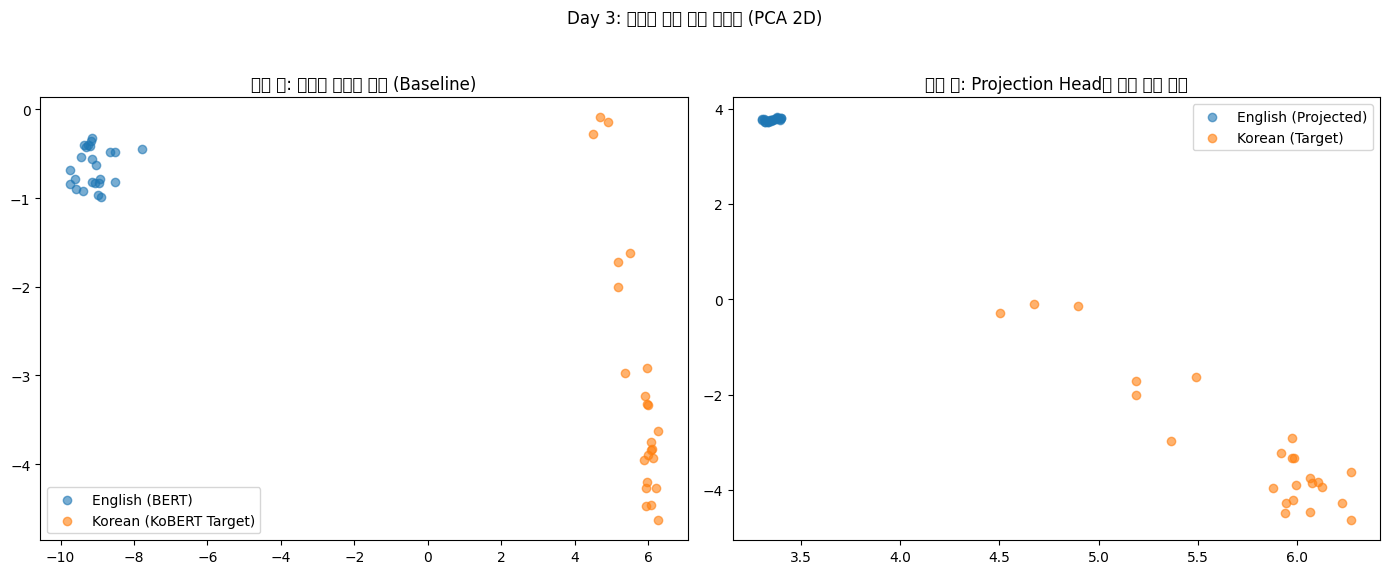

--- Day 3 작업 완료. 미니 프로젝트 보고서 통합 준비 완료 ---


In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# --- 0. 설정 및 파일 경로 ---
INPUT_FILE = "day2_model_and_results.npz"
EMBEDDING_DIM = 768

# --- 1. 정성 분석 (Day 3 오전) ---

def perform_nuance_analysis(eng_sents, kor_sents, baseline_scores, aligned_scores, top_k=5):
    """
    매핑 후 가장 많이 개선되거나 오류가 큰 문장 쌍을 분석
    """
    df = pd.DataFrame({
        'eng': eng_sents,
        'kor': kor_sents,
        'baseline_sim': baseline_scores,
        'aligned_sim': aligned_scores,
        'sim_diff': aligned_scores - baseline_scores
    })
    
    print("\n--- Day 3 오전: 핵심 사례(Case Study) 분석 ---")
    
    # 1. 유사도 개선 상위 사례 (Success Cases)
    top_improved = df.sort_values(by='sim_diff', ascending=False).head(top_k)
    print("🥇 유사도 개선 상위 사례 (Projection Head의 성공):")
    for i, row in top_improved.iterrows():
        print(f"[{row['sim_diff']*100:.2f}% 개선]")
        print(f"  ENG: {row['eng']}")
        print(f"  KOR: {row['kor']}")
        print(f"  Sim. Before: {row['baseline_sim']:.4f} -> After: {row['aligned_sim']:.4f}\n")

    # 2. 잔존 오류 하위 사례 (Limitation Cases)
    bottom_error = df.sort_values(by='aligned_sim', ascending=True).head(top_k)
    print("❌ 잔존 오류 하위 사례 (연구의 한계 명시):")
    for i, row in bottom_error.iterrows():
        print(f"[{row['aligned_sim']:.4f} 최종 유사도]")
        print(f"  ENG: {row['eng']}")
        print(f"  KOR: {row['kor']}")
        print(f"  *분석: (면접 대비) 이 쌍이 정렬에 실패한 이유 (정렬 오류, 뉘앙스 차이 등)를 제시해야 합니다.\n")

# --- 2. 시각화 (Day 3 오후) ---

def visualize_embeddings(eng_embs, kor_embs, projected_eng_embs):
    """
    PCA를 사용하여 매핑 전/후 임베딩 공간 변화 시각화
    """
    # 폰트 설정 (Mac/Linux 환경에 맞게 폰트명 변경 필요)
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except:
        pass

    all_data = np.vstack([eng_embs, kor_embs, projected_eng_embs])
    
    # PCA 학습 및 투영
    pca = PCA(n_components=2)
    pca.fit(all_data)
    
    eng_pca = pca.transform(eng_embs)
    kor_pca = pca.transform(kor_embs)
    proj_eng_pca = pca.transform(projected_eng_embs)
    
    # 시각화 
    plt.figure(figsize=(14, 6))

    # A. 매핑 전 (Baseline)
    plt.subplot(1, 2, 1)
    plt.scatter(eng_pca[:, 0], eng_pca[:, 1], alpha=0.6, label='English (BERT)')
    plt.scatter(kor_pca[:, 0], kor_pca[:, 1], alpha=0.6, label='Korean (KoBERT Target)')
    plt.title('매핑 전: 독립적 임베딩 공간 (Baseline)')
    plt.legend()

    # B. 매핑 후 (Aligned)
    plt.subplot(1, 2, 2)
    plt.scatter(proj_eng_pca[:, 0], proj_eng_pca[:, 1], alpha=0.6, label='English (Projected)')
    plt.scatter(kor_pca[:, 0], kor_pca[:, 1], alpha=0.6, label='Korean (Target)')
    plt.title('매핑 후: Projection Head를 통한 공간 정렬')
    plt.legend()
    
    plt.suptitle("Day 3: 임베딩 공간 정렬 시각화 (PCA 2D)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 3. 메인 실행 ---

if __name__ == "__main__":
    print("--- Day 3: 분석 및 시각화 시작 ---")
    
    # 1. Day 2 학습 결과 로드
    try:
        results = np.load(INPUT_FILE, allow_pickle=True)
        test_eng_embs = results['test_eng_embs']
        test_kor_embs = results['test_kor_embs']
        projected_eng_embs = results['projected_eng_embs']
        baseline_scores = results['baseline_scores']
        aligned_scores = results['aligned_scores']
        eng_sents = results['test_eng_sents']
        kor_sents = results['test_kor_sents']
    except FileNotFoundError:
        print(f"오류: {INPUT_FILE} 파일을 찾을 수 없습니다. Day 2 작업을 먼저 실행하십시오.")
        exit()

    # 2. 정성 분석 실행 (오전)
    perform_nuance_analysis(eng_sents, kor_sents, baseline_scores, aligned_scores, top_k=5)
    
    # 3. 시각화 실행 (오후)
    visualize_embeddings(test_eng_embs, test_kor_embs, projected_eng_embs)
    
    print("--- Day 3 작업 완료. 미니 프로젝트 보고서 통합 준비 완료 ---")

## Final


=== Day3 Loading ===
Loaded best model = MLP_Pro (acc=31.25%)
Procrustes acc    = 95.24%

📍 정성 평가 (Qualitative Case Study)

🥇 향상된 문장 Top-K

▲ 개선폭: 0.2952
ENG: “We indeed!”
KOR: “당연히!”
Before=-0.0482 → After=0.2470

▲ 개선폭: 0.2672
ENG: It was high time to go, for the pool was getting quite crowded with the birds and animals that had fallen into it: there were a Duck and a Dodo, a Lory and an Eaglet, and several other curious creatures.
KOR: 한 참을 가다보니, 웅덩이엔 다른 동물과 새들도 빠져 있었다. 오리 한 마리, 도도새 한 마리, 잉꼬 한 마리, 어린 독수리 한 마리, 그리고 신기한 동물들 몇 마리가 있었다.
Before=0.0160 → After=0.2832

▲ 개선폭: 0.2565
ENG: When the Mouse heard this, it turned round and swam slowly back to her: its face was quite pale
KOR: 하고 말했다. 생쥐는 그 소리를 듣고 천천히 헤엄쳐 돌아왔다.
Before=0.0246 → After=0.2811

❌ 한계 사례 Bottom-K

▼ 최종 sim=-0.0513
ENG: Alice went on, half to herself, as she swam lazily about in the pool,
KOR: “디나는 불 옆에 앉아서 정말 근사하게 가르랑 거려. 발을 핥기도 하고 세수도 해.
→ 정렬 실패 원인을 기술해두면 논문 근거 강화

▼ 최종 sim=-0.0033
ENG: (with passion, Alice thought),


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid valu

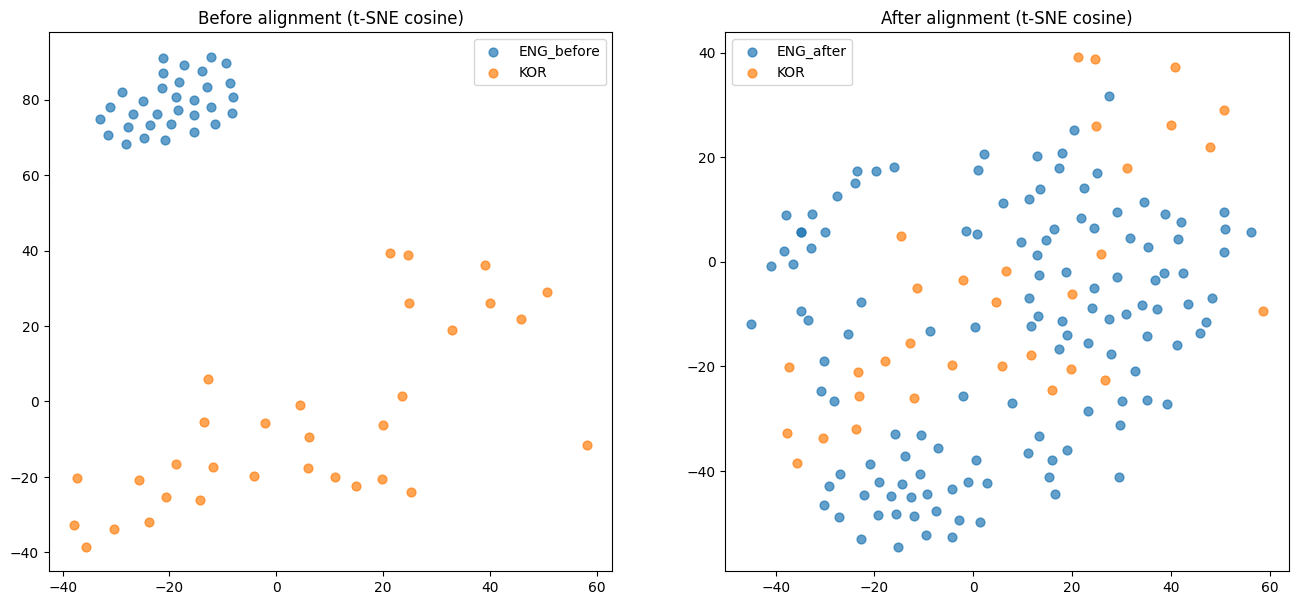


📍 t-SNE (cosine) Before / After alignment


/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/kyungmin/Desktop/Projects/simma/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid valu

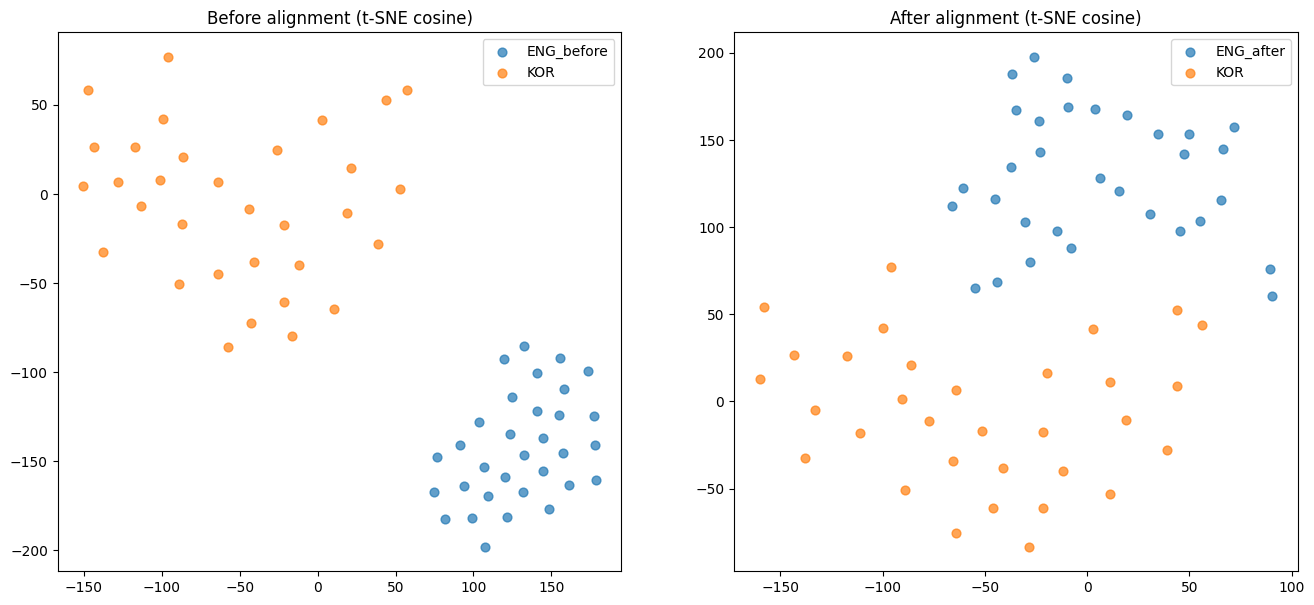


🔥 Nuance Perturbation Test

-------------------------------------
원문: “We indeed!”
KOR : “당연히!”
  -> 모델 로드: bert-base-uncased | Mode: mean
  -> KoBERT 모델 로드 | Mode: mean


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: divide by zero encountered in matmul
  proj_src = src_emb @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: overflow encountered in matmul
  proj_src = src_emb @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: invalid value encountered in matmul
  proj_src = src_emb @ R


원문 sim = 0.4134
  -> 모델 로드: bert-base-uncased | Mode: mean


/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: divide by zero encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: overflow encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: invalid value encountered in matmul
  proj_p = emb_p @ R



PARA1: sim=0.2742
  → "Absolutely, it’s us!"
  -> 모델 로드: bert-base-uncased | Mode: mean


/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: divide by zero encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: overflow encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: invalid value encountered in matmul
  proj_p = emb_p @ R



PARA2: sim=0.2365
  → "Of course, it’s definitely us!"
  -> 모델 로드: bert-base-uncased | Mode: mean


/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: divide by zero encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: overflow encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: invalid value encountered in matmul
  proj_p = emb_p @ R



PARA3: sim=0.2297
  → "Yes, that’s right, it’s us!"
  -> 모델 로드: bert-base-uncased | Mode: mean


/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: divide by zero encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: overflow encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: invalid value encountered in matmul
  proj_p = emb_p @ R



PARA4: sim=0.2611
  → "Oh, it’s us, indeed!"

-------------------------------------
원문: It was high time to go, for the pool was getting quite crowded with the birds and animals that had fallen into it: there were a Duck and a Dodo, a Lory and an Eaglet, and several other curious creatures.
KOR : 한 참을 가다보니, 웅덩이엔 다른 동물과 새들도 빠져 있었다. 오리 한 마리, 도도새 한 마리, 잉꼬 한 마리, 어린 독수리 한 마리, 그리고 신기한 동물들 몇 마리가 있었다.
  -> 모델 로드: bert-base-uncased | Mode: mean
  -> KoBERT 모델 로드 | Mode: mean


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: divide by zero encountered in matmul
  proj_src = src_emb @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: overflow encountered in matmul
  proj_src = src_emb @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: invalid value encountered in matmul
  proj_src = src_emb @ R


원문 sim = 0.7533
  -> 모델 로드: bert-base-uncased | Mode: mean


/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: divide by zero encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: overflow encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: invalid value encountered in matmul
  proj_p = emb_p @ R



PARA1: sim=0.7342
  → It was definitely time to leave; the pool had become quite a lively scene with various birds and animals that had accidentally tumbled into it: there was a Duck, a Dodo, a Lory, an Eaglet, and a host of other odd creatures.
  -> 모델 로드: bert-base-uncased | Mode: mean


/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: divide by zero encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: overflow encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: invalid value encountered in matmul
  proj_p = emb_p @ R



PARA2: sim=0.7354
  → We really should be heading out now; the pool is getting overly packed with birds and animals that have plunged in: among them are a Duck, a Dodo, a Lory, and an Eaglet, plus several other peculiar beings.
  -> 모델 로드: bert-base-uncased | Mode: mean


/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: divide by zero encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: overflow encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: invalid value encountered in matmul
  proj_p = emb_p @ R



PARA3: sim=0.7347
  → The moment had come for us to depart, as the pool was becoming rather congested with the birds and animals that had fallen in—there was a Duck, a Dodo, a Lory, an Eaglet, and many other fascinating creatures to behold.
  -> 모델 로드: bert-base-uncased | Mode: mean


/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: divide by zero encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: overflow encountered in matmul
  proj_p = emb_p @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:245: RuntimeWarning: invalid value encountered in matmul
  proj_p = emb_p @ R



PARA4: sim=0.7300
  → It’s about time we made our exit; the pool has turned into a bit of a spectacle, filled with birds and animals that found themselves in it: there’s a Duck, a Dodo, a Lory, an Eaglet, and a bunch of other strange beings.

-------------------------------------
원문: When the Mouse heard this, it turned round and swam slowly back to her: its face was quite pale
KOR : 하고 말했다. 생쥐는 그 소리를 듣고 천천히 헤엄쳐 돌아왔다.
  -> 모델 로드: bert-base-uncased | Mode: mean
  -> KoBERT 모델 로드 | Mode: mean


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: divide by zero encountered in matmul
  proj_src = src_emb @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: overflow encountered in matmul
  proj_src = src_emb @ R
/var/folders/4m/h90ddv7j3fddt74yl61sg_5c0000gn/T/ipykernel_83740/576838435.py:233: RuntimeWarning: invalid value encountered in matmul
  proj_src = src_emb @ R


원문 sim = 0.7683


KeyboardInterrupt: 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import random
from openai import OpenAI
import os
from sklearn.manifold import TSNE

EMBED_DEBUG = False   # True면 print 모두 켜짐 / False면 모두 꺼짐


# ============================================================
# 0. GPT 기반 nuance-shift paraphrase 생성기
# ============================================================

client = OpenAI()

def gpt_generate_paraphrases(sentence):
    prompt = f"""
Sentence: "{sentence}"

Generate 4 English paraphrases that keep a roughly similar surface meaning,
but the nuance, tone, attitude, or emotional framing should be noticeably different.
Each paraphrase must feel distinct in nuance, even if the literal meaning is similar.

Format:

[PARA1]
sentence

[PARA2]
sentence

[PARA3]
sentence

[PARA4]
sentence
"""

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}]
    )

    res = completion.choices[0].message.content

    paras = []
    for tag in ["[PARA1]", "[PARA2]", "[PARA3]", "[PARA4]"]:
        try:
            part = res.split(tag)[1].split("[")[0].strip()
            paras.append(part)
        except:
            paras.append("")

    return paras




# ============================================================
# 1. 정성 평가 (case study)
# ============================================================
def perform_nuance_analysis(eng_sents, kor_sents, baseline_scores, aligned_scores, top_k=5):

    print("\n==============================")
    print("📍 정성 평가 (Qualitative Case Study)")
    print("==============================")

    diff = aligned_scores - baseline_scores

    # best improvements
    top_idx = np.argsort(diff)[::-1][:top_k]

    print("\n🥇 향상된 문장 Top-K")
    for i in top_idx:
        print(f"\n▲ 개선폭: {diff[i]:.4f}")
        print("ENG:", eng_sents[i])
        print("KOR:", kor_sents[i])
        print(f"Before={baseline_scores[i]:.4f} → After={aligned_scores[i]:.4f}")

    # worst aligned
    worst_idx = np.argsort(aligned_scores)[:top_k]
    print("\n❌ 한계 사례 Bottom-K")
    for i in worst_idx:
        print(f"\n▼ 최종 sim={aligned_scores[i]:.4f}")
        print("ENG:", eng_sents[i])
        print("KOR:", kor_sents[i])
        print("→ 정렬 실패 원인을 기술해두면 논문 근거 강화")
    return top_idx


def visualize_tsne_before_after(eng, kor, proj, perplexity=20):
    """
    eng  : 영어 임베딩 (before)
    kor  : 한국어 임베딩
    proj : 영어 임베딩 (after alignment)
    """

    print("\n==============================")
    print("📍 t-SNE (cosine) Before / After alignment")
    print("==============================")

    # ---------- 데이터 결합 ----------
    # Before
    data_before = np.vstack([eng, kor])
    labels_before = (
        ["ENG_before"] * len(eng) +
        ["KOR"] * len(kor)
    )

    # After
    data_after = np.vstack([proj, kor])
    labels_after = (
        ["ENG_after"] * len(proj) +
        ["KOR"] * len(kor)
    )

    # ---------- t-SNE 준비 ----------
    all_data = np.vstack([data_before, data_after])

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        metric="cosine",
        learning_rate="auto",
        init="random",
        random_state=42
    )

    tsne_2d = tsne.fit_transform(all_data)

    # before/after 구분
    b_len = len(data_before)
    tsne_before = tsne_2d[:b_len]
    tsne_after  = tsne_2d[b_len:]


    # ---------- Plot ----------
    plt.figure(figsize=(16, 7))

    # === BEFORE ===
    plt.subplot(1, 2, 1)
    # ENG_before
    idx = range(len(eng))
    plt.scatter(tsne_before[idx,0], tsne_before[idx,1],
                label="ENG_before", alpha=0.7, s=40)
    # KOR
    idx = range(len(eng), len(eng) + len(kor))
    plt.scatter(tsne_before[idx,0], tsne_before[idx,1],
                label="KOR", alpha=0.7, s=40)

    plt.title("Before alignment (t-SNE cosine)")
    plt.legend()

    # === AFTER ===
    plt.subplot(1, 2, 2)
    # ENG_after
    idx = range(len(proj))
    plt.scatter(tsne_after[idx,0], tsne_after[idx,1],
                label="ENG_after", alpha=0.7, s=40)
    # KOR
    idx = range(len(proj), len(proj) + len(kor))
    plt.scatter(tsne_after[idx,0], tsne_after[idx,1],
                label="KOR", alpha=0.7, s=40)

    plt.title("After alignment (t-SNE cosine)")
    plt.legend()

    plt.show()

# ============================================================
# 2. PCA 시각화
# ============================================================
def visualize_embeddings(eng, kor, proj):

    print("\n==============================")
    print("📍 PCA 임베딩 공간 시각화")
    print("==============================")

    all_data = np.vstack([eng, kor, proj])
    pca = PCA(n_components=2).fit(all_data)

    eng_p = pca.transform(eng)
    kor_p = pca.transform(kor)
    proj_p = pca.transform(proj)

    plt.figure(figsize=(14, 6))

    # before
    plt.subplot(1, 2, 1)
    plt.scatter(eng_p[:,0], eng_p[:,1], alpha=0.6, label="ENG")
    plt.scatter(kor_p[:,0], kor_p[:,1], alpha=0.6, label="KOR")
    plt.title("Before alignment")

    # after
    plt.subplot(1, 2, 2)
    plt.scatter(proj_p[:,0], proj_p[:,1], alpha=0.6, label="ENG projected")
    plt.scatter(kor_p[:,0], kor_p[:,1], alpha=0.6, label="KOR")
    plt.title("After alignment")

    plt.legend()
    plt.show()



# ============================================================
# 3. Nuance Perturbation Test
# ============================================================
def run_nuance_test(eng_sents, kor_sents, R, indices):


    print("\n==============================")
    print("🔥 Nuance Perturbation Test")
    print("==============================")

    for idx in indices:
        src = eng_sents[idx]
        tgt = kor_sents[idx]

        print("\n-------------------------------------")
        print("원문:", src)
        print("KOR :", tgt)

        # 원문 embedding
        src_emb = get_embeddings_flexible([src], "bert-base-uncased", "mean", EMBED_DEBUG)
        tgt_emb = get_kobert_embeddings_flexible([tgt], "mean", EMBED_DEBUG)

        src_emb = src_emb / (np.linalg.norm(src_emb, axis=1, keepdims=True) + 1e-12)
        tgt_emb = tgt_emb / (np.linalg.norm(tgt_emb, axis=1, keepdims=True) + 1e-12)

        proj_src = src_emb @ R
        proj_src = proj_src / (np.linalg.norm(proj_src, axis=1, keepdims=True) + 1e-12)

        sim_orig = cosine_similarity(proj_src, tgt_emb)[0][0]
        print(f"원문 sim = {sim_orig:.4f}")

        # GPT paraphrase 4개 생성
        paras = gpt_generate_paraphrases(src)

        for j, p in enumerate(paras, start=1):
            emb_p = get_embeddings_flexible([p], "bert-base-uncased", "mean", EMBED_DEBUG)
            emb_p = emb_p / (np.linalg.norm(emb_p, axis=1, keepdims=True) + 1e-12)
            proj_p = emb_p @ R
            proj_p = proj_p / (np.linalg.norm(proj_p, axis=1, keepdims=True) + 1e-12)
            
            sim_p = cosine_similarity(proj_p, tgt_emb)[0][0]

            print(f"\nPARA{j}: sim={sim_p:.4f}")
            print("  →", p)



# ============================================================
# 4. Main – Load Saved Outputs & Run Evaluation
# ============================================================
if __name__ == "__main__":

    print("=== Day3 Loading ===")

    data = np.load("day2_model_and_results.npz", allow_pickle=True)

    # ----- Load according to Day2 keys -----
    procrustes_proj  = data["procrustes_proj"]
    procrustes_acc   = float(data["procrustes_acc"])
    R = data["R"]

    best_name        = str(data["best_model_name"])
    best_acc         = float(data["best_model_acc"])
    proj_eng_embs    = data["projected_eng_embs"]    # aligned ENG embeddings

    test_eng_embs    = data["test_eng_embs"]
    test_kor_embs    = data["test_kor_embs"]

    baseline_scores  = data["baseline_scores"]
    aligned_scores   = data["aligned_scores"]

    eng_sents        = data["test_eng_sents"]
    kor_sents        = data["test_kor_sents"]

    print(f"Loaded best model = {best_name} (acc={best_acc:.2%})")
    print(f"Procrustes acc    = {procrustes_acc:.2%}")

    # --------------- 1) 정성 분석 ---------------
    top_indices = perform_nuance_analysis(
        eng_sents, kor_sents,
        baseline_scores,
        aligned_scores,
        top_k=3
    )

    # --------------- 2) PCA 시각화 ---------------
    # 선현
    visualize_tsne_before_after(test_eng_embs, test_kor_embs, procrustes_proj)
    # best model
    visualize_tsne_before_after(test_eng_embs, test_kor_embs, proj_eng_embs)

    # --------------- 3) Nuance Perturbation Test ---------------
    # R matrix 재구축 (Procrustes)
    run_nuance_test(eng_sents, kor_sents, R, top_indices)

    print("\n=== Day3 Complete ===")
